# Set up Tensorflow

In [1]:
import tensorflow as tf
import tempfile
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import datetime
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import KFold
import numpy as np
import math
import itertools
print(f' tensorflow version: {tf.__version__}')

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [ ]:
pip install pyyaml h5py

In [ ]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Load data

In [ ]:
tmpdir = tempfile.gettempdir() # creating a temporary directory for storage
# ds, info = tfds.load('emnist/balanced', split=['train', 'test'], shuffle_files=True, with_info=True, data_dir=tmpdir)

# Test-Train Split 

In [3]:

train_ds, info = tfds.load('emnist/balanced', split='train', shuffle_files=True, with_info=True, data_dir=tmpdir)
test_ds = tfds.load('emnist/balanced', split='test', shuffle_files=True, data_dir=tmpdir)

NameError: name 'tfds' is not defined

In [ ]:
# Get a random sample of 9 images from the training dataset
sample = train_ds.shuffle(buffer_size=10000).take(9)

# Plot the images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
for img, ax in zip(sample, axes):
    image = img['image'].numpy().reshape(28, 28)
    label = chr(img['label'].numpy() + 96)
    ax.imshow(image, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [2]:
# Get number of classes in dataset
num_classes = info.features['label'].num_classes

# Get number of samples in training and testing sets
num_train_samples = info.splits['train'].num_examples
num_test_samples = info.splits['test'].num_examples

print('Number of training samples in dataset:', num_train_samples)
print('Number of testing samples in dataset:', num_test_samples)
print('Number of classes in dataset:', num_classes)

NameError: name 'info' is not defined

In [ ]:
# Preprocess the data

def preprocess(features):
    # Get the images and labels from the dataset
    images = []
    labels = []
    for example in features:
        images.append(example['image'].numpy())
        labels.append(example['label'].numpy())

    # Convert the lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Preprocess the images
    images = images/255.0
    return images, labels


ds_train_images, ds_train_labels = preprocess(train_ds)

ds_test_images, ds_test_labels = preprocess(test_ds)

# ds_train_images

In [11]:
# Define learning rate schedulers
def scheduler1(epoch, lr):
    """Learning rate scheduler function"""
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def scheduler2(epoch, lr, T=20, M=0.5):
    """Cosine annealing learning rate scheduler function"""
    alpha = lr * M
    cos_inner = (math.pi * epoch) / T
    cos_out = math.cos(cos_inner) + 1
    return alpha/2 * cos_out

## Build an MLP model

Build a `tf.keras.Sequential` model:

In [6]:
# Define the hyperparameters to be considered
hyperparams = {                  #creating a dictionary to store hyperparameters
    'optimizer': ['adam', 'sgd', 'adagrad'], # explore at least 3 optimizers
    'batchNorm': [True, False],              # with or without batch normalization
    'dropOut': [True, False],                # with or without dropout
    'reg': [None, regularizers.l1(0.001), regularizers.l2(0.001)], # with or without regularization
    'activation': ['relu', 'elu', 'leaky_relu'] # exploring at least 3 activation functions
}

# create a dictionary to map the activation functions to hyperparams 
# because leaky relu and elu are not built-in functions
activation_function = {
    'relu': tf.nn.relu,
    'elu': tf.nn.elu,
    'leaky_relu': tf.nn.leaky_relu
}

In [7]:

def mlp_model(optimizer, batchNorm, dropOut, activation, reg):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation_function[activation], kernel_regularizer=reg),
        tf.keras.layers.Dense(64, activation_function[activation], kernel_regularizer=reg),
        tf.keras.layers.Dense(32, activation_function[activation], kernel_regularizer=reg),
    ])
    
    if batchNorm:
        model.add(BatchNormalization())
    
    if dropOut:
        model.add(Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(info.features['label'].num_classes))

    model.compile(optimizer=optimizer,
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
    
    return model
    
    

# Train Model

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# define the splits for cross-validation
kf = KFold(n_splits=5, shuffle=True)

schedulers = [scheduler1, scheduler2]   # creating a list of learning rate schedulers

# initializing the basis for the best combination
best_model = None 
best_acc = 0.0            # best accuracy

for params in itertools.product(*hyperparams.values()): # performing a grid search
    param_dict = dict(zip(hyperparams.keys(), params))  # producing a combo of all possible hyperparams
    accuracies = []
    for train_index, val_index in kf.split(ds_train_images):
        # Split data into training and validation sets

        new_train_ds, new_train_labels = ds_train_images[train_index], ds_train_labels[train_index]
        new_val_ds, new_val_labels = ds_train_images[val_index], ds_train_labels[val_index]
        model = mlp_model(**param_dict) # double asterix to unpack key-value pairs in dictionary
        
        for scheduler in schedulers:
            # define the learning rate schedulers
            lr_scheduler = LearningRateScheduler(scheduler)
            # train the model
            start_time = datetime.datetime.now()            # start the timer
            # history = model.fit(train_ds.batch(128),
            history = model.fit(new_train_ds, new_train_labels, batch_size=128,
                                     epochs=20,
                                     validation_data=(new_val_ds, new_val_labels),
                                     callbacks=[lr_scheduler, early_stopping])
            accuracies.append(history.history['val_accuracy'][-1])
            end_time = datetime.datetime.now()             # end timer
            total_time = end_time - start_time
            print(f' Hyperparameter combinations for training, {param_dict}')
            print(f' Training time for the model is, {total_time}')
            
            
    avg_acc = np.mean(accuracies)
    
    # To ascertain if current set of hyperparameters are best
    if avg_acc > best_acc:
        best_acc = avg_acc
        best_model = mlp_model(**param_dict)
    
            
        
        

In [15]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
best_model.save("best_model.h5")
saved_model = keras.models.load_model("best_model.h5")

Epoch 1/20
882/882 [==============================] - 2s 2ms/step - loss: 1.7465 - accuracy: 0.5951 - val_loss: 0.9993 - val_accuracy: 0.7560
Epoch 2/20
882/882 [==============================] - 2s 2ms/step - loss: 0.9914 - accuracy: 0.7528 - val_loss: 0.7931 - val_accuracy: 0.8043
Epoch 3/20
882/882 [==============================] - 2s 2ms/step - loss: 0.8591 - accuracy: 0.7818 - val_loss: 0.7837 - val_accuracy: 0.7984
Epoch 4/20
882/882 [==============================] - 2s 2ms/step - loss: 0.7999 - accuracy: 0.7944 - val_loss: 0.6805 - val_accuracy: 0.8287
Epoch 5/20
882/882 [==============================] - 2s 2ms/step - loss: 0.7593 - accuracy: 0.8026 - val_loss: 0.6799 - val_accuracy: 0.8247
Epoch 6/20
882/882 [==============================] - 2s 2ms/step - loss: 0.7355 - accuracy: 0.8092 - val_loss: 0.6554 - val_accuracy: 0.8307
Epoch 7/20
882/882 [==============================] - 2s 2ms/step - loss: 0.7143 - accuracy: 0.8143 - val_loss: 0.6154 - val_accuracy: 0.8390
Epoch 

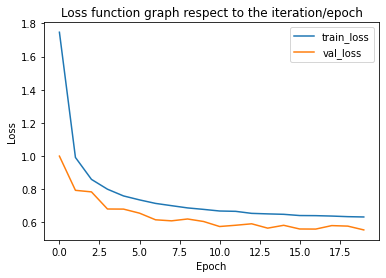

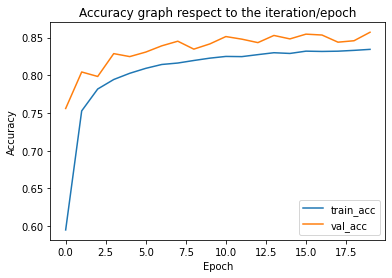

In [39]:
history = best_model.fit(ds_train_images, ds_train_labels, batch_size=128,
                             epochs=20,
                             validation_data=(new_val_ds, new_val_labels))


# plot the loss and accuracy graphs
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss function graph respect to the iteration/epoch')
plt.show()

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy graph respect to the iteration/epoch')
plt.show()

# Model Evaluation

In [40]:
best_model.evaluate(ds_test_images, ds_test_labels, verbose=2) # evaluating the model

588/588 - 0s - loss: 0.6636 - accuracy: 0.8287


[0.6636008024215698, 0.8287234306335449]

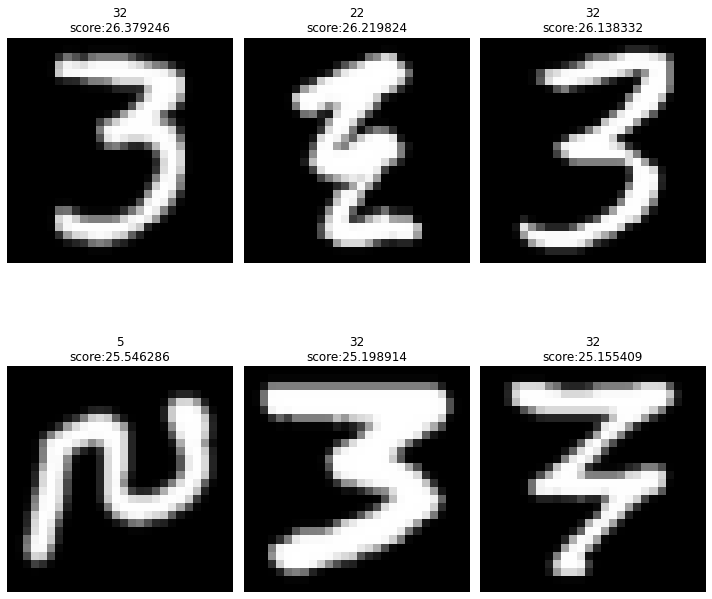

In [41]:
result = best_model.predict(ds_test_images)

#manual
# idx = np.argmax(result, axis = 1)
# resultValue = []
# for i in range(len(result)):
#   resultValue.append(result[i][idx[i]])
# resultValue = np.array(resultValue)

#same with above
resultValue = [max(row) for row in result]
resultValue = np.array(resultValue)

# Getting indices of N = 6 maximum values
six_best = np.argsort(resultValue)[::-1][:6]

# Getting N maximum values
# resultValue[six_best]

# Plot the images
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
axes = axes.flatten()
for img, label, value, ax in zip(ds_test_images[six_best], ds_test_labels[six_best], resultValue[six_best], axes):
    ax.imshow(img, cmap='gray')
    ax.set_title(str(label) + "\nscore:" + str(value))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# # get the predictions of the best model on the testing dataset
# test_pred = best_model.predict(ds_test_images)

# # get the indices of the top six samples with highest prediction scores
# top_six_indices = np.argsort(test_pred, axis=0)[-6:][::-1].flatten()

# for index in top_six_indices:
#     pred = np.argmax(test_pred[index])
#     true = ds_test_labels[index]
#     print(f'Sample {index}: Prediction: {pred}, True Label: {true}')
#     img = ds_test_images[index]

#     # plot the image
#     plt.imshow(img, cmap='gray')
#     plt.title(f'True Label: {true}')
#     plt.show()

In [42]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# get the predicted labels
y_pred_labels = np.argmax(result, axis=1)

# calculate the confusion matrix
conf_mat = confusion_matrix(ds_test_labels, y_pred_labels)

# calculate the precision, recall, and F1 score
precision = precision_score(ds_test_labels, y_pred_labels, average='weighted')
recall = recall_score(ds_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(ds_test_labels, y_pred_labels, average='weighted')

# print the confusion matrix and the metrics
print(f"Confusion matrix:\n{conf_mat}\n")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")


Confusion matrix:
[[319   0   0 ...   0   1   0]
 [  0 245   1 ...   0   1   1]
 [  0   0 315 ...   1   0   0]
 ...
 [  0   0   0 ... 213   0   1]
 [  0   1   0 ...   0 342   2]
 [  0   0   0 ...   0   2 348]]

Precision: 0.831
Recall: 0.829
F1 Score: 0.827


# CNN

### building the CNN model

In [43]:
def cnn_model(optimizer, batchNorm, dropOut, activation, reg):
    model = keras.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation=activation_function[activation], input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation=activation_function[activation]))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation_function[activation], kernel_regularizer=reg))
    
    if batchNorm:
        model.add(BatchNormalization())
    
    if dropOut:
        model.add(Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(info.features['label'].num_classes))

    model.compile(optimizer=optimizer,
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
    
    return model

### Training the CNN model

In [44]:
# initializing the basis for the best combination
best_cnn_model = None 
best_cnn_acc = 0.0            # best accuracy

for params in itertools.product(*hyperparams.values()): # performing a grid search
    param_dict = dict(zip(hyperparams.keys(), params))  # producing a combo of all possible hyperparams
    accuracies = []
    for train_index, val_index in kf.split(ds_train_images):
        # Split data into training and validation sets

        new_train_ds, new_train_labels = ds_train_images[train_index], ds_train_labels[train_index]
        new_val_ds, new_val_labels = ds_train_images[val_index], ds_train_labels[val_index]
        model = cnn_model(**param_dict) # double asterix to unpack key-value pairs in dictionary
        
        for scheduler in schedulers:
            # define the learning rate schedulers
            lr_scheduler = LearningRateScheduler(scheduler)
            # train the model
            start_time = datetime.datetime.now()            # start the timer
            # history = model.fit(train_ds.batch(128),
            history = model.fit(new_train_ds, new_train_labels, batch_size=128,
                                     epochs=20,
                                     validation_data=(new_val_ds, new_val_labels),
                                     callbacks=[lr_scheduler, early_stopping])
            accuracies.append(history.history['val_accuracy'][-1])
            end_time = datetime.datetime.now()             # end timer
            total_time = end_time - start_time
            print(f' Hyperparameter combinations for training, {param_dict}')
            print(f' Training time for the model is, {total_time}')
            
            
    avg_acc = np.mean(accuracies)
    
    # To ascertain if current set of hyperparameters are best
    if avg_acc > best_cnn_acc:
        best_cnn_acc = avg_acc
        best_cnn_model = cnn_model(**param_dict)
    

Epoch 1/20
705/705 [==============================] - 27s 39ms/step - loss: 0.8412 - accuracy: 0.7636 - val_loss: 0.4716 - val_accuracy: 0.8439
Epoch 2/20
705/705 [==============================] - 27s 39ms/step - loss: 0.4511 - accuracy: 0.8488 - val_loss: 0.4038 - val_accuracy: 0.8582
Epoch 3/20
705/705 [==============================] - 29s 41ms/step - loss: 0.3873 - accuracy: 0.8658 - val_loss: 0.3732 - val_accuracy: 0.8703
Epoch 4/20
705/705 [==============================] - 27s 39ms/step - loss: 0.3507 - accuracy: 0.8768 - val_loss: 0.3799 - val_accuracy: 0.8666
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 0.3258 - accuracy: 0.8824 - val_loss: 0.3510 - val_accuracy: 0.8777
Epoch 6/20
705/705 [==============================] - 28s 39ms/step - loss: 0.3020 - accuracy: 0.8897 - val_loss: 0.3558 - val_accuracy: 0.8727
Epoch 7/20
705/705 [==============================] - 28s 39ms/step - loss: 0.2791 - accuracy: 0.8967 - val_loss: 0.3541 - val_accuracy:

Epoch 1/20
705/705 [==============================] - 28s 39ms/step - loss: 0.7922 - accuracy: 0.7703 - val_loss: 0.4760 - val_accuracy: 0.8430
Epoch 2/20
705/705 [==============================] - 27s 39ms/step - loss: 0.4400 - accuracy: 0.8510 - val_loss: 0.4158 - val_accuracy: 0.8583
Epoch 3/20
705/705 [==============================] - 27s 39ms/step - loss: 0.3784 - accuracy: 0.8692 - val_loss: 0.3765 - val_accuracy: 0.8706
Epoch 4/20
705/705 [==============================] - 28s 39ms/step - loss: 0.3416 - accuracy: 0.8771 - val_loss: 0.3706 - val_accuracy: 0.8724
Epoch 5/20
705/705 [==============================] - 28s 39ms/step - loss: 0.3177 - accuracy: 0.8848 - val_loss: 0.3675 - val_accuracy: 0.8720
Epoch 6/20
705/705 [==============================] - 29s 41ms/step - loss: 0.2918 - accuracy: 0.8924 - val_loss: 0.3479 - val_accuracy: 0.8762
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 0.2708 - accuracy: 0.8977 - val_loss: 0.3458 - val_accuracy:

705/705 [==============================] - 27s 39ms/step - loss: 0.3076 - accuracy: 0.8885 - val_loss: 0.3865 - val_accuracy: 0.8643
Epoch 9/20
705/705 [==============================] - 28s 40ms/step - loss: 0.2896 - accuracy: 0.8940 - val_loss: 0.4309 - val_accuracy: 0.8518
Epoch 10/20
705/705 [==============================] - 28s 39ms/step - loss: 0.2723 - accuracy: 0.8993 - val_loss: 0.4013 - val_accuracy: 0.8645
Epoch 11/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2570 - accuracy: 0.9038 - val_loss: 0.3797 - val_accuracy: 0.8715
Epoch 12/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2431 - accuracy: 0.9081 - val_loss: 0.3942 - val_accuracy: 0.8676
Epoch 13/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2336 - accuracy: 0.9110 - val_loss: 0.3823 - val_accuracy: 0.8686
Epoch 14/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2201 - accuracy: 0.9157 - val_loss: 0.3784 - val_accuracy: 0.873

705/705 [==============================] - 126s 178ms/step - loss: 0.2204 - accuracy: 0.9143 - val_loss: 0.3598 - val_accuracy: 0.8761
Epoch 12/20
705/705 [==============================] - 29s 41ms/step - loss: 0.2084 - accuracy: 0.9185 - val_loss: 0.3688 - val_accuracy: 0.8756
Epoch 13/20
705/705 [==============================] - 29s 42ms/step - loss: 0.1967 - accuracy: 0.9227 - val_loss: 0.3602 - val_accuracy: 0.8781
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': True, 'dropOut': True, 'reg': None, 'activation': 'leaky_relu'}
 Training time for the model is, 0:08:00.255967
Epoch 1/20
705/705 [==============================] - 29s 42ms/step - loss: 0.2038 - accuracy: 0.9220 - val_loss: 0.3453 - val_accuracy: 0.8819
Epoch 2/20
705/705 [==============================] - 29s 42ms/step - loss: 0.1882 - accuracy: 0.9273 - val_loss: 0.3389 - val_accuracy: 0.8838
Epoch 3/20
705/705 [==============================] - 29s 42ms/step - loss: 0.1813 - accuracy: 0.

Epoch 6/20
705/705 [==============================] - 27s 39ms/step - loss: 0.3890 - accuracy: 0.8910 - val_loss: 0.4186 - val_accuracy: 0.8839
Epoch 7/20
705/705 [==============================] - 27s 39ms/step - loss: 0.3868 - accuracy: 0.8917 - val_loss: 0.4181 - val_accuracy: 0.8836
Epoch 8/20
705/705 [==============================] - 28s 39ms/step - loss: 0.3877 - accuracy: 0.8914 - val_loss: 0.4180 - val_accuracy: 0.8840
Epoch 9/20
705/705 [==============================] - 27s 39ms/step - loss: 0.3872 - accuracy: 0.8916 - val_loss: 0.4179 - val_accuracy: 0.8835
Epoch 10/20
705/705 [==============================] - 27s 39ms/step - loss: 0.3862 - accuracy: 0.8918 - val_loss: 0.4179 - val_accuracy: 0.8836
Epoch 11/20
705/705 [==============================] - 27s 39ms/step - loss: 0.3858 - accuracy: 0.8921 - val_loss: 0.4179 - val_accuracy: 0.8833
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': True, 'dropOut': True, 'reg': <tensorflow.python.keras.r

705/705 [==============================] - 27s 38ms/step - loss: 0.5627 - accuracy: 0.8684 - val_loss: 0.5472 - val_accuracy: 0.8684
Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5001 - accuracy: 0.8745 - val_loss: 0.4960 - val_accuracy: 0.8760
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4655 - accuracy: 0.8792 - val_loss: 0.4644 - val_accuracy: 0.8775
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4454 - accuracy: 0.8810 - val_loss: 0.4492 - val_accuracy: 0.8790
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4357 - accuracy: 0.8821 - val_loss: 0.4419 - val_accuracy: 0.8793
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4306 - accuracy: 0.8812 - val_loss: 0.4390 - val_accuracy: 0.8798
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4286 - accuracy: 0.8832 - val_loss: 0.4379 - val_accuracy: 0.8800
Epo

705/705 [==============================] - 25s 36ms/step - loss: 0.5318 - accuracy: 0.8731 - val_loss: 0.5233 - val_accuracy: 0.8700
Epoch 2/20
705/705 [==============================] - 25s 36ms/step - loss: 0.4803 - accuracy: 0.8788 - val_loss: 0.4828 - val_accuracy: 0.8737
Epoch 3/20
705/705 [==============================] - 25s 35ms/step - loss: 0.4520 - accuracy: 0.8806 - val_loss: 0.4591 - val_accuracy: 0.8759
Epoch 4/20
705/705 [==============================] - 25s 36ms/step - loss: 0.4354 - accuracy: 0.8823 - val_loss: 0.4484 - val_accuracy: 0.8768
Epoch 5/20
705/705 [==============================] - 25s 36ms/step - loss: 0.4279 - accuracy: 0.8832 - val_loss: 0.4426 - val_accuracy: 0.8775
Epoch 6/20
705/705 [==============================] - 25s 36ms/step - loss: 0.4245 - accuracy: 0.8845 - val_loss: 0.4398 - val_accuracy: 0.8780
Epoch 7/20
705/705 [==============================] - 25s 36ms/step - loss: 0.4220 - accuracy: 0.8841 - val_loss: 0.4389 - val_accuracy: 0.8777
Epo

705/705 [==============================] - 28s 40ms/step - loss: 0.5510 - accuracy: 0.8540 - val_loss: 0.5314 - val_accuracy: 0.8585
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 0.5500 - accuracy: 0.8534 - val_loss: 0.5300 - val_accuracy: 0.8588
Epoch 9/20
705/705 [==============================] - 28s 40ms/step - loss: 0.5482 - accuracy: 0.8544 - val_loss: 0.5295 - val_accuracy: 0.8587
Epoch 10/20
705/705 [==============================] - 28s 40ms/step - loss: 0.5484 - accuracy: 0.8533 - val_loss: 0.5293 - val_accuracy: 0.8586
Epoch 11/20
705/705 [==============================] - 28s 40ms/step - loss: 0.5475 - accuracy: 0.8547 - val_loss: 0.5293 - val_accuracy: 0.8585
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': True, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'elu'}
 Training time for the model is, 0:05:09.726426
Epoch 1/20
705/705 [====================

Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4487 - accuracy: 0.8777 - val_loss: 0.4523 - val_accuracy: 0.8769
Epoch 6/20
705/705 [==============================] - 29s 40ms/step - loss: 0.4434 - accuracy: 0.8795 - val_loss: 0.4498 - val_accuracy: 0.8767
Epoch 7/20
705/705 [==============================] - 29s 41ms/step - loss: 0.4417 - accuracy: 0.8797 - val_loss: 0.4487 - val_accuracy: 0.8769
Epoch 8/20
705/705 [==============================] - 29s 41ms/step - loss: 0.4422 - accuracy: 0.8786 - val_loss: 0.4483 - val_accuracy: 0.8772
Epoch 9/20
705/705 [==============================] - 29s 41ms/step - loss: 0.4402 - accuracy: 0.8796 - val_loss: 0.4482 - val_accuracy: 0.8768
Epoch 10/20
705/705 [==============================] - 29s 40ms/step - loss: 0.4410 - accuracy: 0.8786 - val_loss: 0.4480 - val_accuracy: 0.8771
Epoch 11/20
705/705 [==============================] - 29s 41ms/step - loss: 0.4405 - accuracy: 0.8793 - val_loss: 0.4480 - val_accurac

Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4821 - accuracy: 0.8725 - val_loss: 0.4698 - val_accuracy: 0.8729
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4716 - accuracy: 0.8741 - val_loss: 0.4609 - val_accuracy: 0.8735
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4636 - accuracy: 0.8760 - val_loss: 0.4570 - val_accuracy: 0.8736
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4605 - accuracy: 0.8761 - val_loss: 0.4555 - val_accuracy: 0.8733
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4596 - accuracy: 0.8762 - val_loss: 0.4549 - val_accuracy: 0.8733
Epoch 9/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4599 - accuracy: 0.8741 - val_loss: 0.4546 - val_accuracy: 0.8731
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': True, 'dropOut': True, 'reg': <tensorflow.python.keras.reg

705/705 [==============================] - 27s 39ms/step - loss: 0.2498 - accuracy: 0.9263 - val_loss: 0.3949 - val_accuracy: 0.8819
Epoch 2/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2282 - accuracy: 0.9336 - val_loss: 0.3915 - val_accuracy: 0.8835
Epoch 3/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2172 - accuracy: 0.9380 - val_loss: 0.3908 - val_accuracy: 0.8835
Epoch 4/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2126 - accuracy: 0.9398 - val_loss: 0.3915 - val_accuracy: 0.8828
Epoch 5/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2088 - accuracy: 0.9410 - val_loss: 0.3909 - val_accuracy: 0.8826
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': True, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'relu'}
 Training time for the model is, 0:02:16.883361
Epoch 1/20
705/705 [=====================

Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 0.2157 - accuracy: 0.9381 - val_loss: 0.3895 - val_accuracy: 0.8858
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 0.2123 - accuracy: 0.9394 - val_loss: 0.3892 - val_accuracy: 0.8857
Epoch 6/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2123 - accuracy: 0.9395 - val_loss: 0.3892 - val_accuracy: 0.8857
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': True, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'relu'}
 Training time for the model is, 0:02:43.226749
Epoch 1/20
705/705 [==============================] - 27s 38ms/step - loss: 0.9461 - accuracy: 0.7704 - val_loss: 0.6124 - val_accuracy: 0.8378
Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5461 - accuracy: 0.8490 - val_loss: 0.5262 - val_accuracy: 0.8537
Epoch 3/20
705/705 [==========

705/705 [==============================] - 28s 39ms/step - loss: 0.2992 - accuracy: 0.9138 - val_loss: 0.4194 - val_accuracy: 0.8767
Epoch 5/20
705/705 [==============================] - 28s 39ms/step - loss: 0.2938 - accuracy: 0.9152 - val_loss: 0.4189 - val_accuracy: 0.8778
Epoch 6/20
705/705 [==============================] - 28s 39ms/step - loss: 0.2914 - accuracy: 0.9155 - val_loss: 0.4186 - val_accuracy: 0.8779
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 0.2905 - accuracy: 0.9155 - val_loss: 0.4185 - val_accuracy: 0.8782
Epoch 8/20
705/705 [==============================] - 28s 39ms/step - loss: 0.2895 - accuracy: 0.9163 - val_loss: 0.4188 - val_accuracy: 0.8779
Epoch 9/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2878 - accuracy: 0.9175 - val_loss: 0.4186 - val_accuracy: 0.8779
Epoch 10/20
705/705 [==============================] - 28s 40ms/step - loss: 0.2899 - accuracy: 0.9164 - val_loss: 0.4185 - val_accuracy: 0.8781
 H

Epoch 13/20
705/705 [==============================] - 29s 41ms/step - loss: 0.3289 - accuracy: 0.9019 - val_loss: 0.4351 - val_accuracy: 0.8763
Epoch 14/20
705/705 [==============================] - 29s 41ms/step - loss: 0.3144 - accuracy: 0.9051 - val_loss: 0.4244 - val_accuracy: 0.8801
Epoch 15/20
705/705 [==============================] - 29s 41ms/step - loss: 0.3009 - accuracy: 0.9099 - val_loss: 0.4299 - val_accuracy: 0.8767
Epoch 16/20
705/705 [==============================] - 29s 41ms/step - loss: 0.2894 - accuracy: 0.9125 - val_loss: 0.4187 - val_accuracy: 0.8808
Epoch 17/20
705/705 [==============================] - 31s 44ms/step - loss: 0.2741 - accuracy: 0.9176 - val_loss: 0.4211 - val_accuracy: 0.8791
Epoch 18/20
705/705 [==============================] - 30s 43ms/step - loss: 0.2646 - accuracy: 0.9195 - val_loss: 0.4232 - val_accuracy: 0.8798
Epoch 19/20
705/705 [==============================] - 30s 43ms/step - loss: 0.2531 - accuracy: 0.9238 - val_loss: 0.4232 - val_ac

Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 0.2566 - accuracy: 0.9260 - val_loss: 0.3751 - val_accuracy: 0.8905
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 0.2478 - accuracy: 0.9294 - val_loss: 0.3741 - val_accuracy: 0.8903
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 0.2430 - accuracy: 0.9309 - val_loss: 0.3735 - val_accuracy: 0.8910
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 0.2406 - accuracy: 0.9318 - val_loss: 0.3733 - val_accuracy: 0.8913
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 0.2392 - accuracy: 0.9320 - val_loss: 0.3732 - val_accuracy: 0.8914
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 0.2387 - accuracy: 0.9318 - val_loss: 0.3730 - val_accuracy: 0.8911
Epoch 9/20
705/705 [==============================] - 29s 41ms/step - loss: 0.2392 - accuracy: 0.9324 - val_loss: 0.3731 - val_accuracy:

Epoch 7/20
705/705 [==============================] - 25s 36ms/step - loss: 0.2240 - accuracy: 0.9142 - val_loss: 0.3910 - val_accuracy: 0.8680
Epoch 8/20
705/705 [==============================] - 25s 36ms/step - loss: 0.2035 - accuracy: 0.9210 - val_loss: 0.3774 - val_accuracy: 0.8725
Epoch 9/20
705/705 [==============================] - 25s 36ms/step - loss: 0.1843 - accuracy: 0.9281 - val_loss: 0.3617 - val_accuracy: 0.8777
Epoch 10/20
705/705 [==============================] - 25s 36ms/step - loss: 0.1659 - accuracy: 0.9353 - val_loss: 0.3862 - val_accuracy: 0.8732
Epoch 11/20
705/705 [==============================] - 25s 36ms/step - loss: 0.1493 - accuracy: 0.9417 - val_loss: 0.4040 - val_accuracy: 0.8720
Epoch 12/20
705/705 [==============================] - 25s 36ms/step - loss: 0.1356 - accuracy: 0.9472 - val_loss: 0.4059 - val_accuracy: 0.8750
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': True, 'dropOut': False, 'reg': None, 'activation': 'rel

705/705 [==============================] - 27s 39ms/step - loss: 0.2287 - accuracy: 0.9193 - val_loss: 0.3690 - val_accuracy: 0.8753
Epoch 5/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2241 - accuracy: 0.9215 - val_loss: 0.3690 - val_accuracy: 0.8754
Epoch 6/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2214 - accuracy: 0.9220 - val_loss: 0.3693 - val_accuracy: 0.8755
Epoch 7/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2204 - accuracy: 0.9224 - val_loss: 0.3691 - val_accuracy: 0.8755
Epoch 8/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2200 - accuracy: 0.9226 - val_loss: 0.3693 - val_accuracy: 0.8751
Epoch 9/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2202 - accuracy: 0.9226 - val_loss: 0.3692 - val_accuracy: 0.8754
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': True, 'dropOut': False, 'reg': None, 'activation': 'elu'}
 Training t

Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4042 - accuracy: 0.8627 - val_loss: 0.4375 - val_accuracy: 0.8504
Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 0.3473 - accuracy: 0.8775 - val_loss: 0.4197 - val_accuracy: 0.8539
Epoch 4/20
705/705 [==============================] - 28s 39ms/step - loss: 0.3156 - accuracy: 0.8875 - val_loss: 0.3894 - val_accuracy: 0.8609
Epoch 5/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2872 - accuracy: 0.8961 - val_loss: 0.3845 - val_accuracy: 0.8636
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.2590 - accuracy: 0.9040 - val_loss: 0.3831 - val_accuracy: 0.8666
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 0.2347 - accuracy: 0.9115 - val_loss: 0.3775 - val_accuracy: 0.8704
Epoch 8/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2117 - accuracy: 0.9193 - val_loss: 0.3863 - val_accuracy:

Epoch 10/20
705/705 [==============================] - 27s 39ms/step - loss: 0.4071 - accuracy: 0.8895 - val_loss: 0.4543 - val_accuracy: 0.8770
Epoch 11/20
705/705 [==============================] - 27s 39ms/step - loss: 0.4070 - accuracy: 0.8895 - val_loss: 0.4543 - val_accuracy: 0.8767
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': True, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'relu'}
 Training time for the model is, 0:05:05.282328
Epoch 1/20
705/705 [==============================] - 27s 39ms/step - loss: 1.7956 - accuracy: 0.7748 - val_loss: 1.0915 - val_accuracy: 0.7614
Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 0.8186 - accuracy: 0.8343 - val_loss: 0.8675 - val_accuracy: 0.8109
Epoch 3/20
705/705 [==============================] - 27s 39ms/step - loss: 0.7474 - accuracy: 0.8446 - val_loss: 0.7861 - val_accuracy: 0.8271
Epoch 4/20
705/705 [=======

Epoch 7/20
705/705 [==============================] - 27s 39ms/step - loss: 0.3391 - accuracy: 0.9053 - val_loss: 0.4017 - val_accuracy: 0.8842
Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3386 - accuracy: 0.9054 - val_loss: 0.4016 - val_accuracy: 0.8839
Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3383 - accuracy: 0.9054 - val_loss: 0.4015 - val_accuracy: 0.8840
Epoch 10/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3385 - accuracy: 0.9055 - val_loss: 0.4016 - val_accuracy: 0.8840
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': True, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'relu'}
 Training time for the model is, 0:04:31.801438
Epoch 1/20
705/705 [==============================] - 28s 39ms/step - loss: 1.7667 - accuracy: 0.7754 - val_loss: 0.9728 - val_accuracy: 0.7950
Epoch 2/20
705/705 [========

Epoch 2/20
705/705 [==============================] - 26s 37ms/step - loss: 0.3957 - accuracy: 0.8952 - val_loss: 0.4335 - val_accuracy: 0.8822
Epoch 3/20
705/705 [==============================] - 26s 37ms/step - loss: 0.3796 - accuracy: 0.8977 - val_loss: 0.4216 - val_accuracy: 0.8824
Epoch 4/20
705/705 [==============================] - 26s 37ms/step - loss: 0.3694 - accuracy: 0.9003 - val_loss: 0.4161 - val_accuracy: 0.8842
Epoch 5/20
705/705 [==============================] - 26s 37ms/step - loss: 0.3651 - accuracy: 0.8999 - val_loss: 0.4134 - val_accuracy: 0.8840
Epoch 6/20
705/705 [==============================] - 26s 37ms/step - loss: 0.3625 - accuracy: 0.8999 - val_loss: 0.4122 - val_accuracy: 0.8841
Epoch 7/20
705/705 [==============================] - 26s 37ms/step - loss: 0.3612 - accuracy: 0.9001 - val_loss: 0.4119 - val_accuracy: 0.8839
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': True, 'dropOut': False, 'reg': <tensorflow.python.keras.re

705/705 [==============================] - 27s 38ms/step - loss: 0.7558 - accuracy: 0.8513 - val_loss: 0.7778 - val_accuracy: 0.8400
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7160 - accuracy: 0.8567 - val_loss: 0.7320 - val_accuracy: 0.8450
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6894 - accuracy: 0.8610 - val_loss: 0.7094 - val_accuracy: 0.8534
Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6645 - accuracy: 0.8625 - val_loss: 0.7080 - val_accuracy: 0.8476
Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6384 - accuracy: 0.8654 - val_loss: 0.6624 - val_accuracy: 0.8578
Epoch 10/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6106 - accuracy: 0.8682 - val_loss: 0.6361 - val_accuracy: 0.8641
Epoch 11/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5941 - accuracy: 0.8710 - val_loss: 0.6218 - val_accuracy: 0.8625
E

Epoch 2/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8823 - accuracy: 0.8293 - val_loss: 0.8806 - val_accuracy: 0.8198
Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8053 - accuracy: 0.8414 - val_loss: 0.8186 - val_accuracy: 0.8378
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7765 - accuracy: 0.8485 - val_loss: 0.7962 - val_accuracy: 0.8383
Epoch 5/20
705/705 [==============================] - 29s 41ms/step - loss: 0.7558 - accuracy: 0.8525 - val_loss: 0.8554 - val_accuracy: 0.8282
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7214 - accuracy: 0.8571 - val_loss: 0.7738 - val_accuracy: 0.8378
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 0.6870 - accuracy: 0.8602 - val_loss: 0.7513 - val_accuracy: 0.8386
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 0.6576 - accuracy: 0.8634 - val_loss: 0.7277 - val_accuracy:

Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 0.1895 - accuracy: 0.9482 - val_loss: 0.3826 - val_accuracy: 0.8847
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': True, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'relu'}
 Training time for the model is, 0:03:59.597845
Epoch 1/20
705/705 [==============================] - 26s 37ms/step - loss: 0.8613 - accuracy: 0.7938 - val_loss: 0.6133 - val_accuracy: 0.8278
Epoch 2/20
705/705 [==============================] - 26s 37ms/step - loss: 0.4923 - accuracy: 0.8635 - val_loss: 0.5186 - val_accuracy: 0.8479
Epoch 3/20
705/705 [==============================] - 26s 37ms/step - loss: 0.4330 - accuracy: 0.8745 - val_loss: 0.4890 - val_accuracy: 0.8583
Epoch 4/20
705/705 [==============================] - 26s 37ms/step - loss: 0.4093 - accuracy: 0.8797 - val_loss: 0.4823 - val_accuracy: 0.8576
Epoch 5/20
705/705 [=========

Epoch 14/20
705/705 [==============================] - 25s 36ms/step - loss: 0.3098 - accuracy: 0.9079 - val_loss: 0.4439 - val_accuracy: 0.8678
Epoch 15/20
705/705 [==============================] - 26s 36ms/step - loss: 0.2934 - accuracy: 0.9123 - val_loss: 0.4431 - val_accuracy: 0.8688
Epoch 16/20
705/705 [==============================] - 25s 36ms/step - loss: 0.2824 - accuracy: 0.9162 - val_loss: 0.4382 - val_accuracy: 0.8693
Epoch 17/20
705/705 [==============================] - 25s 36ms/step - loss: 0.2671 - accuracy: 0.9204 - val_loss: 0.4455 - val_accuracy: 0.8674
Epoch 18/20
705/705 [==============================] - 25s 36ms/step - loss: 0.2545 - accuracy: 0.9243 - val_loss: 0.4381 - val_accuracy: 0.8711
Epoch 19/20
705/705 [==============================] - 25s 36ms/step - loss: 0.2423 - accuracy: 0.9283 - val_loss: 0.4390 - val_accuracy: 0.8704
Epoch 20/20
705/705 [==============================] - 26s 37ms/step - loss: 0.2322 - accuracy: 0.9307 - val_loss: 0.4448 - val_ac

Epoch 12/20
705/705 [==============================] - 27s 39ms/step - loss: 0.3386 - accuracy: 0.8992 - val_loss: 0.4584 - val_accuracy: 0.8651
Epoch 13/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3201 - accuracy: 0.9051 - val_loss: 0.4564 - val_accuracy: 0.8642
Epoch 14/20
705/705 [==============================] - 27s 39ms/step - loss: 0.3067 - accuracy: 0.9086 - val_loss: 0.4436 - val_accuracy: 0.8696
Epoch 15/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2925 - accuracy: 0.9128 - val_loss: 0.4721 - val_accuracy: 0.8584
Epoch 16/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2781 - accuracy: 0.9169 - val_loss: 0.4393 - val_accuracy: 0.8736
Epoch 17/20
705/705 [==============================] - 27s 38ms/step - loss: 0.2650 - accuracy: 0.9218 - val_loss: 0.4452 - val_accuracy: 0.8691
Epoch 18/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2513 - accuracy: 0.9259 - val_loss: 0.4443 - val_ac

Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3878 - accuracy: 0.8858 - val_loss: 0.5330 - val_accuracy: 0.8484
Epoch 10/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3714 - accuracy: 0.8910 - val_loss: 0.5036 - val_accuracy: 0.8566
Epoch 11/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3533 - accuracy: 0.8971 - val_loss: 0.4997 - val_accuracy: 0.8576
Epoch 12/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3362 - accuracy: 0.9011 - val_loss: 0.4867 - val_accuracy: 0.8623
Epoch 13/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3221 - accuracy: 0.9049 - val_loss: 0.4888 - val_accuracy: 0.8648
Epoch 14/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3050 - accuracy: 0.9090 - val_loss: 0.4771 - val_accuracy: 0.8677
Epoch 15/20
705/705 [==============================] - 27s 38ms/step - loss: 0.2909 - accuracy: 0.9135 - val_loss: 0.4823 - val_acc

705/705 [==============================] - 28s 39ms/step - loss: 0.2379 - accuracy: 0.9333 - val_loss: 0.4051 - val_accuracy: 0.8810
Epoch 2/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2076 - accuracy: 0.9433 - val_loss: 0.3975 - val_accuracy: 0.8826
Epoch 3/20
705/705 [==============================] - 28s 39ms/step - loss: 0.1933 - accuracy: 0.9484 - val_loss: 0.3955 - val_accuracy: 0.8822
Epoch 4/20
705/705 [==============================] - 28s 39ms/step - loss: 0.1857 - accuracy: 0.9514 - val_loss: 0.3955 - val_accuracy: 0.8826
Epoch 5/20
705/705 [==============================] - 28s 39ms/step - loss: 0.1822 - accuracy: 0.9529 - val_loss: 0.3956 - val_accuracy: 0.8820
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': True, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'leaky_relu'}
 Training time for the model is, 0:02:18.240357
Epoch 1/20
705/705 [==============

Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4404 - accuracy: 0.8740 - val_loss: 0.5326 - val_accuracy: 0.8493
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4241 - accuracy: 0.8778 - val_loss: 0.4673 - val_accuracy: 0.8681
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4039 - accuracy: 0.8833 - val_loss: 0.4837 - val_accuracy: 0.8634
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3815 - accuracy: 0.8904 - val_loss: 0.4447 - val_accuracy: 0.8729
Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3655 - accuracy: 0.8931 - val_loss: 0.4541 - val_accuracy: 0.8722
Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3466 - accuracy: 0.8998 - val_loss: 0.4426 - val_accuracy: 0.8714
Epoch 10/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3275 - accuracy: 0.9041 - val_loss: 0.4353 - val_accuracy

Epoch 1/20
705/705 [==============================] - 24s 35ms/step - loss: 1.0972 - accuracy: 0.6715 - val_loss: 0.5253 - val_accuracy: 0.8245
Epoch 2/20
705/705 [==============================] - 24s 34ms/step - loss: 0.5628 - accuracy: 0.8138 - val_loss: 0.4476 - val_accuracy: 0.8478
Epoch 3/20
705/705 [==============================] - 24s 34ms/step - loss: 0.4795 - accuracy: 0.8378 - val_loss: 0.4048 - val_accuracy: 0.8582
Epoch 4/20
705/705 [==============================] - 24s 34ms/step - loss: 0.4325 - accuracy: 0.8512 - val_loss: 0.3871 - val_accuracy: 0.8662
Epoch 5/20
705/705 [==============================] - 24s 35ms/step - loss: 0.4030 - accuracy: 0.8586 - val_loss: 0.3818 - val_accuracy: 0.8650
Epoch 6/20
705/705 [==============================] - 24s 34ms/step - loss: 0.3719 - accuracy: 0.8685 - val_loss: 0.3634 - val_accuracy: 0.8710
Epoch 7/20
705/705 [==============================] - 24s 34ms/step - loss: 0.3494 - accuracy: 0.8748 - val_loss: 0.3544 - val_accuracy:

Epoch 6/20
705/705 [==============================] - 24s 33ms/step - loss: 0.3648 - accuracy: 0.8696 - val_loss: 0.3614 - val_accuracy: 0.8752
Epoch 7/20
705/705 [==============================] - 24s 34ms/step - loss: 0.3445 - accuracy: 0.8752 - val_loss: 0.3550 - val_accuracy: 0.8752
Epoch 8/20
705/705 [==============================] - 24s 34ms/step - loss: 0.3192 - accuracy: 0.8828 - val_loss: 0.3461 - val_accuracy: 0.8797
Epoch 9/20
705/705 [==============================] - 23s 33ms/step - loss: 0.3053 - accuracy: 0.8871 - val_loss: 0.3446 - val_accuracy: 0.8783
Epoch 10/20
705/705 [==============================] - 23s 33ms/step - loss: 0.2881 - accuracy: 0.8926 - val_loss: 0.3441 - val_accuracy: 0.8792
Epoch 11/20
705/705 [==============================] - 23s 33ms/step - loss: 0.2739 - accuracy: 0.8963 - val_loss: 0.3503 - val_accuracy: 0.8806
Epoch 12/20
705/705 [==============================] - 23s 33ms/step - loss: 0.2634 - accuracy: 0.9001 - val_loss: 0.3505 - val_accura

705/705 [==============================] - 27s 39ms/step - loss: 0.2746 - accuracy: 0.8980 - val_loss: 0.3329 - val_accuracy: 0.8847
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 0.2671 - accuracy: 0.9011 - val_loss: 0.3318 - val_accuracy: 0.8841
Epoch 5/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2648 - accuracy: 0.9011 - val_loss: 0.3313 - val_accuracy: 0.8846
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.2629 - accuracy: 0.9024 - val_loss: 0.3313 - val_accuracy: 0.8841
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': False, 'dropOut': True, 'reg': None, 'activation': 'elu'}
 Training time for the model is, 0:02:43.214492
Epoch 1/20
705/705 [==============================] - 27s 39ms/step - loss: 0.8994 - accuracy: 0.7305 - val_loss: 0.4956 - val_accuracy: 0.8352
Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4901 - accuracy: 0.8348 - val

705/705 [==============================] - 28s 40ms/step - loss: 0.2229 - accuracy: 0.9143 - val_loss: 0.3292 - val_accuracy: 0.8863
Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 0.2186 - accuracy: 0.9160 - val_loss: 0.3284 - val_accuracy: 0.8866
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 0.2150 - accuracy: 0.9173 - val_loss: 0.3289 - val_accuracy: 0.8869
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 0.2140 - accuracy: 0.9175 - val_loss: 0.3291 - val_accuracy: 0.8867
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 0.2105 - accuracy: 0.9192 - val_loss: 0.3290 - val_accuracy: 0.8870
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 0.2118 - accuracy: 0.9186 - val_loss: 0.3290 - val_accuracy: 0.8869
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 0.2110 - accuracy: 0.9178 - val_loss: 0.3291 - val_accuracy: 0.8869
Epo

705/705 [==============================] - 28s 40ms/step - loss: 0.5475 - accuracy: 0.8616 - val_loss: 0.5321 - val_accuracy: 0.8643
Epoch 2/20
705/705 [==============================] - 27s 39ms/step - loss: 0.5209 - accuracy: 0.8669 - val_loss: 0.5187 - val_accuracy: 0.8660
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5060 - accuracy: 0.8691 - val_loss: 0.5093 - val_accuracy: 0.8672
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5018 - accuracy: 0.8708 - val_loss: 0.5050 - val_accuracy: 0.8671
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4971 - accuracy: 0.8702 - val_loss: 0.5042 - val_accuracy: 0.8669
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4953 - accuracy: 0.8699 - val_loss: 0.5029 - val_accuracy: 0.8676
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4946 - accuracy: 0.8693 - val_loss: 0.5026 - val_accuracy: 0.8673
Epo

Epoch 7/20
705/705 [==============================] - 28s 39ms/step - loss: 0.8669 - accuracy: 0.8340 - val_loss: 0.8266 - val_accuracy: 0.8416
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8219 - accuracy: 0.8381 - val_loss: 0.8034 - val_accuracy: 0.8449
Epoch 9/20
705/705 [==============================] - 28s 39ms/step - loss: 0.7913 - accuracy: 0.8413 - val_loss: 0.7876 - val_accuracy: 0.8505
Epoch 10/20
705/705 [==============================] - 28s 39ms/step - loss: 0.7641 - accuracy: 0.8449 - val_loss: 0.7550 - val_accuracy: 0.8471
Epoch 11/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7337 - accuracy: 0.8464 - val_loss: 0.7261 - val_accuracy: 0.8553
Epoch 12/20
705/705 [==============================] - 28s 39ms/step - loss: 0.7152 - accuracy: 0.8487 - val_loss: 0.7009 - val_accuracy: 0.8568
Epoch 13/20
705/705 [==============================] - 28s 40ms/step - loss: 0.6890 - accuracy: 0.8509 - val_loss: 0.6720 - val_accur

Epoch 2/20
705/705 [==============================] - 28s 39ms/step - loss: 1.1412 - accuracy: 0.7869 - val_loss: 0.9968 - val_accuracy: 0.8206
Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 1.0356 - accuracy: 0.8055 - val_loss: 0.9498 - val_accuracy: 0.8349
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 0.9867 - accuracy: 0.8154 - val_loss: 0.9183 - val_accuracy: 0.8343
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 0.9587 - accuracy: 0.8200 - val_loss: 0.9014 - val_accuracy: 0.8467
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 0.9093 - accuracy: 0.8270 - val_loss: 0.8584 - val_accuracy: 0.8462
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8739 - accuracy: 0.8315 - val_loss: 0.8228 - val_accuracy: 0.8497
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8269 - accuracy: 0.8353 - val_loss: 0.7829 - val_accuracy:

Epoch 4/20
705/705 [==============================] - 29s 41ms/step - loss: 0.5439 - accuracy: 0.8599 - val_loss: 0.5268 - val_accuracy: 0.8631
Epoch 5/20
705/705 [==============================] - 29s 41ms/step - loss: 0.5393 - accuracy: 0.8596 - val_loss: 0.5229 - val_accuracy: 0.8616
Epoch 6/20
705/705 [==============================] - 29s 41ms/step - loss: 0.5363 - accuracy: 0.8608 - val_loss: 0.5211 - val_accuracy: 0.8626
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': False, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'leaky_relu'}
 Training time for the model is, 0:02:59.725339
Epoch 1/20
705/705 [==============================] - 29s 41ms/step - loss: 2.0523 - accuracy: 0.6522 - val_loss: 1.1442 - val_accuracy: 0.7884
Epoch 2/20
705/705 [==============================] - 29s 41ms/step - loss: 1.1051 - accuracy: 0.7846 - val_loss: 0.9890 - val_accuracy: 0.8067
Epoch 3/20
705/705 [===

Epoch 15/20
705/705 [==============================] - 28s 40ms/step - loss: 0.6731 - accuracy: 0.8470 - val_loss: 0.6459 - val_accuracy: 0.8607
Epoch 16/20
705/705 [==============================] - 29s 41ms/step - loss: 0.6560 - accuracy: 0.8506 - val_loss: 0.6234 - val_accuracy: 0.8615
Epoch 17/20
705/705 [==============================] - 29s 40ms/step - loss: 0.6450 - accuracy: 0.8512 - val_loss: 0.6146 - val_accuracy: 0.8618
Epoch 18/20
705/705 [==============================] - 28s 40ms/step - loss: 0.6275 - accuracy: 0.8534 - val_loss: 0.6031 - val_accuracy: 0.8618
Epoch 19/20
705/705 [==============================] - 28s 40ms/step - loss: 0.6147 - accuracy: 0.8536 - val_loss: 0.5886 - val_accuracy: 0.8649
Epoch 20/20
705/705 [==============================] - 29s 40ms/step - loss: 0.5999 - accuracy: 0.8558 - val_loss: 0.5794 - val_accuracy: 0.8659
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': False, 'dropOut': True, 'reg': <tensorflow.python.ke

Epoch 6/20
705/705 [==============================] - 26s 37ms/step - loss: 0.4992 - accuracy: 0.8586 - val_loss: 0.4770 - val_accuracy: 0.8680
Epoch 7/20
705/705 [==============================] - 26s 37ms/step - loss: 0.4748 - accuracy: 0.8652 - val_loss: 0.4538 - val_accuracy: 0.8739
Epoch 8/20
705/705 [==============================] - 26s 37ms/step - loss: 0.4566 - accuracy: 0.8694 - val_loss: 0.4482 - val_accuracy: 0.8746
Epoch 9/20
705/705 [==============================] - 26s 37ms/step - loss: 0.4376 - accuracy: 0.8733 - val_loss: 0.4469 - val_accuracy: 0.8723
Epoch 10/20
705/705 [==============================] - 26s 37ms/step - loss: 0.4224 - accuracy: 0.8776 - val_loss: 0.4383 - val_accuracy: 0.8742
Epoch 11/20
705/705 [==============================] - 26s 37ms/step - loss: 0.4073 - accuracy: 0.8818 - val_loss: 0.4253 - val_accuracy: 0.8777
Epoch 12/20
705/705 [==============================] - 26s 37ms/step - loss: 0.3926 - accuracy: 0.8854 - val_loss: 0.4215 - val_accura

Epoch 4/20
705/705 [==============================] - 27s 39ms/step - loss: 0.5612 - accuracy: 0.8424 - val_loss: 0.4852 - val_accuracy: 0.8623
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5334 - accuracy: 0.8490 - val_loss: 0.4721 - val_accuracy: 0.8703
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5070 - accuracy: 0.8558 - val_loss: 0.4591 - val_accuracy: 0.8731
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4834 - accuracy: 0.8628 - val_loss: 0.4509 - val_accuracy: 0.8731
Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4610 - accuracy: 0.8671 - val_loss: 0.4431 - val_accuracy: 0.8746
Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4430 - accuracy: 0.8713 - val_loss: 0.4269 - val_accuracy: 0.8768
Epoch 10/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4289 - accuracy: 0.8756 - val_loss: 0.4215 - val_accuracy

705/705 [==============================] - 27s 39ms/step - loss: 0.3123 - accuracy: 0.9037 - val_loss: 0.3907 - val_accuracy: 0.8852
Epoch 20/20
705/705 [==============================] - 28s 39ms/step - loss: 0.3043 - accuracy: 0.9067 - val_loss: 0.3912 - val_accuracy: 0.8824
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': False, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'elu'}
 Training time for the model is, 0:09:18.487862
Epoch 1/20
705/705 [==============================] - 28s 39ms/step - loss: 0.2822 - accuracy: 0.9145 - val_loss: 0.3846 - val_accuracy: 0.8865
Epoch 2/20
705/705 [==============================] - 28s 39ms/step - loss: 0.2687 - accuracy: 0.9190 - val_loss: 0.3791 - val_accuracy: 0.8874
Epoch 3/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2614 - accuracy: 0.9219 - val_loss: 0.3774 - val_accuracy: 0.8873
Epoch 4/20
705/705 [====================

Epoch 14/20
705/705 [==============================] - 28s 39ms/step - loss: 0.3629 - accuracy: 0.8910 - val_loss: 0.4106 - val_accuracy: 0.8790
Epoch 15/20
705/705 [==============================] - 28s 39ms/step - loss: 0.3510 - accuracy: 0.8941 - val_loss: 0.4117 - val_accuracy: 0.8807
Epoch 16/20
705/705 [==============================] - 28s 39ms/step - loss: 0.3396 - accuracy: 0.8972 - val_loss: 0.4108 - val_accuracy: 0.8790
Epoch 17/20
705/705 [==============================] - 28s 40ms/step - loss: 0.3296 - accuracy: 0.8992 - val_loss: 0.4043 - val_accuracy: 0.8804
Epoch 18/20
705/705 [==============================] - 28s 40ms/step - loss: 0.3220 - accuracy: 0.9018 - val_loss: 0.4027 - val_accuracy: 0.8819
Epoch 19/20
705/705 [==============================] - 28s 39ms/step - loss: 0.3114 - accuracy: 0.9046 - val_loss: 0.4009 - val_accuracy: 0.8824
Epoch 20/20
705/705 [==============================] - 28s 39ms/step - loss: 0.3035 - accuracy: 0.9069 - val_loss: 0.4003 - val_ac

Epoch 10/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4143 - accuracy: 0.8788 - val_loss: 0.4315 - val_accuracy: 0.8746
Epoch 11/20
705/705 [==============================] - 29s 41ms/step - loss: 0.4032 - accuracy: 0.8818 - val_loss: 0.4289 - val_accuracy: 0.8759
Epoch 12/20
705/705 [==============================] - 28s 40ms/step - loss: 0.3913 - accuracy: 0.8844 - val_loss: 0.4142 - val_accuracy: 0.8810
Epoch 13/20
705/705 [==============================] - 29s 40ms/step - loss: 0.3778 - accuracy: 0.8886 - val_loss: 0.4119 - val_accuracy: 0.8792
Epoch 14/20
705/705 [==============================] - 28s 40ms/step - loss: 0.3677 - accuracy: 0.8913 - val_loss: 0.4102 - val_accuracy: 0.8799
Epoch 15/20
705/705 [==============================] - 29s 41ms/step - loss: 0.3572 - accuracy: 0.8929 - val_loss: 0.4015 - val_accuracy: 0.8817
Epoch 16/20
705/705 [==============================] - 29s 41ms/step - loss: 0.3456 - accuracy: 0.8959 - val_loss: 0.3982 - val_ac

Epoch 13/20
705/705 [==============================] - 28s 40ms/step - loss: 0.3778 - accuracy: 0.8875 - val_loss: 0.4173 - val_accuracy: 0.8783
Epoch 14/20
705/705 [==============================] - 28s 40ms/step - loss: 0.3654 - accuracy: 0.8899 - val_loss: 0.4103 - val_accuracy: 0.8810
Epoch 15/20
705/705 [==============================] - 28s 40ms/step - loss: 0.3550 - accuracy: 0.8931 - val_loss: 0.4101 - val_accuracy: 0.8789
Epoch 16/20
705/705 [==============================] - 28s 40ms/step - loss: 0.3441 - accuracy: 0.8957 - val_loss: 0.4076 - val_accuracy: 0.8812
Epoch 17/20
705/705 [==============================] - 28s 40ms/step - loss: 0.3351 - accuracy: 0.8979 - val_loss: 0.4002 - val_accuracy: 0.8821
Epoch 18/20
705/705 [==============================] - 28s 40ms/step - loss: 0.3276 - accuracy: 0.9002 - val_loss: 0.4008 - val_accuracy: 0.8809
Epoch 19/20
705/705 [==============================] - 28s 40ms/step - loss: 0.3164 - accuracy: 0.9031 - val_loss: 0.4013 - val_ac

705/705 [==============================] - 27s 38ms/step - loss: 0.3638 - accuracy: 0.8723 - val_loss: 0.4344 - val_accuracy: 0.8462
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3323 - accuracy: 0.8804 - val_loss: 0.3820 - val_accuracy: 0.8673
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3022 - accuracy: 0.8898 - val_loss: 0.3736 - val_accuracy: 0.8693
Epoch 7/20
705/705 [==============================] - 26s 38ms/step - loss: 0.2782 - accuracy: 0.8968 - val_loss: 0.3689 - val_accuracy: 0.8726
Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 0.2561 - accuracy: 0.9028 - val_loss: 0.3547 - val_accuracy: 0.8770
Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 0.2358 - accuracy: 0.9098 - val_loss: 0.3642 - val_accuracy: 0.8734
Epoch 10/20
705/705 [==============================] - 26s 38ms/step - loss: 0.2173 - accuracy: 0.9160 - val_loss: 0.3702 - val_accuracy: 0.8752
Ep

705/705 [==============================] - 27s 38ms/step - loss: 0.1575 - accuracy: 0.9411 - val_loss: 0.3843 - val_accuracy: 0.8787
Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 0.1573 - accuracy: 0.9413 - val_loss: 0.3844 - val_accuracy: 0.8788
Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 0.1571 - accuracy: 0.9413 - val_loss: 0.3844 - val_accuracy: 0.8789
Epoch 10/20
705/705 [==============================] - 27s 38ms/step - loss: 0.1571 - accuracy: 0.9413 - val_loss: 0.3844 - val_accuracy: 0.8789
Epoch 11/20
705/705 [==============================] - 27s 38ms/step - loss: 0.1571 - accuracy: 0.9413 - val_loss: 0.3844 - val_accuracy: 0.8789
Epoch 12/20
705/705 [==============================] - 27s 38ms/step - loss: 0.1571 - accuracy: 0.9413 - val_loss: 0.3844 - val_accuracy: 0.8789
Epoch 13/20
705/705 [==============================] - 27s 38ms/step - loss: 0.1571 - accuracy: 0.9413 - val_loss: 0.3844 - val_accuracy: 0.8789

Epoch 1/20
705/705 [==============================] - 27s 38ms/step - loss: 1.9823 - accuracy: 0.6723 - val_loss: 1.1205 - val_accuracy: 0.7901
Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 1.0114 - accuracy: 0.7912 - val_loss: 0.9218 - val_accuracy: 0.8049
Epoch 3/20
705/705 [==============================] - 26s 38ms/step - loss: 0.8771 - accuracy: 0.8115 - val_loss: 0.8339 - val_accuracy: 0.8217
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 0.8152 - accuracy: 0.8237 - val_loss: 0.7913 - val_accuracy: 0.8282
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7772 - accuracy: 0.8288 - val_loss: 0.7682 - val_accuracy: 0.8329
Epoch 6/20
705/705 [==============================] - 26s 38ms/step - loss: 0.7346 - accuracy: 0.8370 - val_loss: 0.7462 - val_accuracy: 0.8342
Epoch 7/20
705/705 [==============================] - 26s 37ms/step - loss: 0.7010 - accuracy: 0.8421 - val_loss: 0.7088 - val_accuracy:

705/705 [==============================] - 27s 39ms/step - loss: 0.5707 - accuracy: 0.8641 - val_loss: 0.5960 - val_accuracy: 0.8563
Epoch 14/20
705/705 [==============================] - 27s 39ms/step - loss: 0.5580 - accuracy: 0.8646 - val_loss: 0.5813 - val_accuracy: 0.8568
Epoch 15/20
705/705 [==============================] - 27s 39ms/step - loss: 0.5453 - accuracy: 0.8665 - val_loss: 0.5725 - val_accuracy: 0.8569
Epoch 16/20
705/705 [==============================] - 27s 39ms/step - loss: 0.5328 - accuracy: 0.8693 - val_loss: 0.5614 - val_accuracy: 0.8596
Epoch 17/20
705/705 [==============================] - 27s 39ms/step - loss: 0.5209 - accuracy: 0.8708 - val_loss: 0.5469 - val_accuracy: 0.8620
Epoch 18/20
705/705 [==============================] - 27s 39ms/step - loss: 0.5116 - accuracy: 0.8728 - val_loss: 0.5551 - val_accuracy: 0.8595
Epoch 19/20
705/705 [==============================] - 27s 39ms/step - loss: 0.5013 - accuracy: 0.8738 - val_loss: 0.5343 - val_accuracy: 0.86

Epoch 5/20
705/705 [==============================] - 27s 39ms/step - loss: 0.8301 - accuracy: 0.8407 - val_loss: 0.8262 - val_accuracy: 0.8374
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7731 - accuracy: 0.8461 - val_loss: 0.7692 - val_accuracy: 0.8467
Epoch 7/20
705/705 [==============================] - 27s 39ms/step - loss: 0.7373 - accuracy: 0.8514 - val_loss: 0.7727 - val_accuracy: 0.8463
Epoch 8/20
705/705 [==============================] - 27s 39ms/step - loss: 0.7068 - accuracy: 0.8550 - val_loss: 0.7250 - val_accuracy: 0.8508
Epoch 9/20
705/705 [==============================] - 27s 39ms/step - loss: 0.6757 - accuracy: 0.8579 - val_loss: 0.6925 - val_accuracy: 0.8524
Epoch 10/20
705/705 [==============================] - 27s 39ms/step - loss: 0.6470 - accuracy: 0.8608 - val_loss: 0.7012 - val_accuracy: 0.8465
Epoch 11/20
705/705 [==============================] - 27s 39ms/step - loss: 0.6326 - accuracy: 0.8635 - val_loss: 0.6328 - val_accurac

Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4237 - accuracy: 0.8888 - val_loss: 0.4762 - val_accuracy: 0.8738
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4171 - accuracy: 0.8903 - val_loss: 0.4716 - val_accuracy: 0.8734
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4136 - accuracy: 0.8910 - val_loss: 0.4699 - val_accuracy: 0.8727
Epoch 6/20
705/705 [==============================] - 27s 39ms/step - loss: 0.4119 - accuracy: 0.8914 - val_loss: 0.4690 - val_accuracy: 0.8734
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': False, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'elu'}
 Training time for the model is, 0:02:43.051502
Epoch 1/20
705/705 [==============================] - 27s 39ms/step - loss: 1.9357 - accuracy: 0.7005 - val_loss: 1.1233 - val_accuracy: 0.7894
Epoch 2/20
705/705 [=========

705/705 [==============================] - 28s 40ms/step - loss: 0.4759 - accuracy: 0.8802 - val_loss: 0.5114 - val_accuracy: 0.8703
Epoch 2/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4540 - accuracy: 0.8831 - val_loss: 0.4961 - val_accuracy: 0.8714
Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4428 - accuracy: 0.8851 - val_loss: 0.4879 - val_accuracy: 0.8723
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4362 - accuracy: 0.8862 - val_loss: 0.4842 - val_accuracy: 0.8719
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4330 - accuracy: 0.8868 - val_loss: 0.4826 - val_accuracy: 0.8722
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4314 - accuracy: 0.8873 - val_loss: 0.4816 - val_accuracy: 0.8721
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': False, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers

Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 0.5021 - accuracy: 0.8745 - val_loss: 0.5344 - val_accuracy: 0.8593
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4884 - accuracy: 0.8771 - val_loss: 0.5249 - val_accuracy: 0.8603
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4815 - accuracy: 0.8780 - val_loss: 0.5195 - val_accuracy: 0.8612
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4778 - accuracy: 0.8787 - val_loss: 0.5176 - val_accuracy: 0.8624
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4762 - accuracy: 0.8789 - val_loss: 0.5167 - val_accuracy: 0.8623
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4754 - accuracy: 0.8790 - val_loss: 0.5164 - val_accuracy: 0.8621
Epoch 9/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4751 - accuracy: 0.8792 - val_loss: 0.5163 - val_accuracy:

705/705 [==============================] - 27s 38ms/step - loss: 0.2489 - accuracy: 0.9278 - val_loss: 0.4110 - val_accuracy: 0.8781
Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 0.2317 - accuracy: 0.9349 - val_loss: 0.4050 - val_accuracy: 0.8817
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 0.2232 - accuracy: 0.9376 - val_loss: 0.4023 - val_accuracy: 0.8833
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 0.2190 - accuracy: 0.9393 - val_loss: 0.4020 - val_accuracy: 0.8838
Epoch 5/20
705/705 [==============================] - 26s 37ms/step - loss: 0.2165 - accuracy: 0.9404 - val_loss: 0.4022 - val_accuracy: 0.8838
Epoch 6/20
705/705 [==============================] - 26s 38ms/step - loss: 0.2155 - accuracy: 0.9411 - val_loss: 0.4021 - val_accuracy: 0.8830
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 0.2149 - accuracy: 0.9411 - val_loss: 0.4021 - val_accuracy: 0.8834
Epo

705/705 [==============================] - 28s 39ms/step - loss: 0.2296 - accuracy: 0.9350 - val_loss: 0.4165 - val_accuracy: 0.8807
Epoch 2/20
705/705 [==============================] - 28s 39ms/step - loss: 0.2120 - accuracy: 0.9415 - val_loss: 0.4161 - val_accuracy: 0.8816
Epoch 3/20
705/705 [==============================] - 28s 39ms/step - loss: 0.2036 - accuracy: 0.9451 - val_loss: 0.4162 - val_accuracy: 0.8805
Epoch 4/20
705/705 [==============================] - 27s 39ms/step - loss: 0.1993 - accuracy: 0.9467 - val_loss: 0.4159 - val_accuracy: 0.8826
Epoch 5/20
705/705 [==============================] - 28s 39ms/step - loss: 0.1970 - accuracy: 0.9474 - val_loss: 0.4160 - val_accuracy: 0.8831
Epoch 6/20
705/705 [==============================] - 28s 39ms/step - loss: 0.1959 - accuracy: 0.9481 - val_loss: 0.4163 - val_accuracy: 0.8828
Epoch 7/20
705/705 [==============================] - 28s 39ms/step - loss: 0.1954 - accuracy: 0.9485 - val_loss: 0.4163 - val_accuracy: 0.8829
Epo

Epoch 4/20
705/705 [==============================] - 28s 39ms/step - loss: 0.2163 - accuracy: 0.9395 - val_loss: 0.4159 - val_accuracy: 0.8821
Epoch 5/20
705/705 [==============================] - 28s 39ms/step - loss: 0.2137 - accuracy: 0.9408 - val_loss: 0.4158 - val_accuracy: 0.8825
Epoch 6/20
705/705 [==============================] - 28s 39ms/step - loss: 0.2124 - accuracy: 0.9411 - val_loss: 0.4159 - val_accuracy: 0.8824
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': False, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'elu'}
 Training time for the model is, 0:02:45.815079
Epoch 1/20
705/705 [==============================] - 28s 39ms/step - loss: 0.9971 - accuracy: 0.7585 - val_loss: 0.6620 - val_accuracy: 0.8291
Epoch 2/20
705/705 [==============================] - 27s 39ms/step - loss: 0.5780 - accuracy: 0.8455 - val_loss: 0.5498 - val_accuracy: 0.8489
Epoch 3/20
705/705 [=========

Epoch 6/20
705/705 [==============================] - 28s 39ms/step - loss: 0.2166 - accuracy: 0.9409 - val_loss: 0.4010 - val_accuracy: 0.8861
Epoch 7/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2159 - accuracy: 0.9409 - val_loss: 0.4010 - val_accuracy: 0.8858
Epoch 8/20
705/705 [==============================] - 27s 39ms/step - loss: 0.2157 - accuracy: 0.9410 - val_loss: 0.4010 - val_accuracy: 0.8859
Epoch 9/20
705/705 [==============================] - 28s 39ms/step - loss: 0.2156 - accuracy: 0.9410 - val_loss: 0.4010 - val_accuracy: 0.8859
 Hyperparameter combinations for training, {'optimizer': 'adam', 'batchNorm': False, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'elu'}
 Training time for the model is, 0:04:08.321161
Epoch 1/20
705/705 [==============================] - 29s 41ms/step - loss: 1.0563 - accuracy: 0.7380 - val_loss: 0.6853 - val_accuracy: 0.8270
Epoch 2/20
705/705 [=========

Epoch 2/20
705/705 [==============================] - 28s 40ms/step - loss: 0.6026 - accuracy: 0.8405 - val_loss: 0.5680 - val_accuracy: 0.8469
Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 0.5235 - accuracy: 0.8552 - val_loss: 0.5158 - val_accuracy: 0.8561
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4832 - accuracy: 0.8633 - val_loss: 0.4866 - val_accuracy: 0.8629
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4636 - accuracy: 0.8681 - val_loss: 0.4805 - val_accuracy: 0.8651
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4380 - accuracy: 0.8740 - val_loss: 0.4791 - val_accuracy: 0.8605
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4189 - accuracy: 0.8791 - val_loss: 0.4575 - val_accuracy: 0.8694
Epoch 8/20
705/705 [==============================] - 29s 40ms/step - loss: 0.3999 - accuracy: 0.8839 - val_loss: 0.4553 - val_accuracy:

Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4038 - accuracy: 0.8653 - val_loss: 0.4093 - val_accuracy: 0.8652
Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4022 - accuracy: 0.8663 - val_loss: 0.4094 - val_accuracy: 0.8655
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': True, 'dropOut': True, 'reg': None, 'activation': 'relu'}
 Training time for the model is, 0:03:37.283238
Epoch 1/20
705/705 [==============================] - 27s 38ms/step - loss: 1.6539 - accuracy: 0.5734 - val_loss: 0.9818 - val_accuracy: 0.7456
Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 0.8817 - accuracy: 0.7528 - val_loss: 0.7070 - val_accuracy: 0.8007
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7040 - accuracy: 0.7923 - val_loss: 0.5959 - val_accuracy: 0.8199
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6231 - accuracy: 0.

705/705 [==============================] - 27s 38ms/step - loss: 0.4184 - accuracy: 0.8621 - val_loss: 0.4059 - val_accuracy: 0.8605
Epoch 19/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4152 - accuracy: 0.8640 - val_loss: 0.4065 - val_accuracy: 0.8624
Epoch 20/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4109 - accuracy: 0.8651 - val_loss: 0.4018 - val_accuracy: 0.8625
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': True, 'dropOut': True, 'reg': None, 'activation': 'relu'}
 Training time for the model is, 0:09:02.954914
Epoch 1/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4074 - accuracy: 0.8645 - val_loss: 0.3988 - val_accuracy: 0.8637
Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4045 - accuracy: 0.8660 - val_loss: 0.3980 - val_accuracy: 0.8648
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4035 - accuracy: 0.8660 - va

Epoch 20/20
705/705 [==============================] - 27s 39ms/step - loss: 0.4439 - accuracy: 0.8552 - val_loss: 0.4339 - val_accuracy: 0.8558
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': True, 'dropOut': True, 'reg': None, 'activation': 'elu'}
 Training time for the model is, 0:09:07.781152
Epoch 1/20
705/705 [==============================] - 27s 39ms/step - loss: 0.4396 - accuracy: 0.8558 - val_loss: 0.4304 - val_accuracy: 0.8581
Epoch 2/20
705/705 [==============================] - 27s 39ms/step - loss: 0.4374 - accuracy: 0.8562 - val_loss: 0.4288 - val_accuracy: 0.8583
Epoch 3/20
705/705 [==============================] - 27s 39ms/step - loss: 0.4372 - accuracy: 0.8567 - val_loss: 0.4289 - val_accuracy: 0.8582
Epoch 4/20
705/705 [==============================] - 27s 39ms/step - loss: 0.4358 - accuracy: 0.8572 - val_loss: 0.4286 - val_accuracy: 0.8581
Epoch 5/20
705/705 [==============================] - 27s 39ms/step - loss: 0.4364 - accuracy: 0.

705/705 [==============================] - 28s 40ms/step - loss: 0.4226 - accuracy: 0.8594 - val_loss: 0.4099 - val_accuracy: 0.8645
Epoch 19/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4196 - accuracy: 0.8616 - val_loss: 0.4072 - val_accuracy: 0.8645
Epoch 20/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4173 - accuracy: 0.8611 - val_loss: 0.4056 - val_accuracy: 0.8641
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': True, 'dropOut': True, 'reg': None, 'activation': 'leaky_relu'}
 Training time for the model is, 0:09:27.131133
Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4117 - accuracy: 0.8639 - val_loss: 0.4034 - val_accuracy: 0.8656
Epoch 2/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4116 - accuracy: 0.8626 - val_loss: 0.4025 - val_accuracy: 0.8660
Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4094 - accuracy: 0.864

705/705 [==============================] - 28s 40ms/step - loss: 0.5380 - accuracy: 0.8287 - val_loss: 0.5049 - val_accuracy: 0.8371
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 0.5130 - accuracy: 0.8356 - val_loss: 0.4882 - val_accuracy: 0.8395
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4955 - accuracy: 0.8398 - val_loss: 0.4808 - val_accuracy: 0.8433
Epoch 9/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4800 - accuracy: 0.8443 - val_loss: 0.4647 - val_accuracy: 0.8466
Epoch 10/20
705/705 [==============================] - 28s 39ms/step - loss: 0.4686 - accuracy: 0.8473 - val_loss: 0.4581 - val_accuracy: 0.8502
Epoch 11/20
705/705 [==============================] - 28s 39ms/step - loss: 0.4591 - accuracy: 0.8499 - val_loss: 0.4542 - val_accuracy: 0.8494
Epoch 12/20
705/705 [==============================] - 28s 39ms/step - loss: 0.4507 - accuracy: 0.8520 - val_loss: 0.4486 - val_accuracy: 0.8515


Epoch 7/20
705/705 [==============================] - 27s 39ms/step - loss: 1.1007 - accuracy: 0.8317 - val_loss: 0.9824 - val_accuracy: 0.8355
Epoch 8/20
705/705 [==============================] - 27s 39ms/step - loss: 0.9190 - accuracy: 0.8347 - val_loss: 0.8453 - val_accuracy: 0.8398
Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 0.8205 - accuracy: 0.8363 - val_loss: 0.7972 - val_accuracy: 0.8305
Epoch 10/20
705/705 [==============================] - 27s 39ms/step - loss: 0.7677 - accuracy: 0.8386 - val_loss: 0.7533 - val_accuracy: 0.8335
Epoch 11/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7339 - accuracy: 0.8406 - val_loss: 0.7334 - val_accuracy: 0.8302
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': True, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'relu'}
 Training time for the model is, 0:05:01.824634
Epoch 1/20
705/705 [=========

705/705 [==============================] - 27s 38ms/step - loss: 1.4412 - accuracy: 0.8209 - val_loss: 1.2319 - val_accuracy: 0.8345
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 1.1295 - accuracy: 0.8235 - val_loss: 1.0409 - val_accuracy: 0.8183
Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 0.9657 - accuracy: 0.8227 - val_loss: 0.9183 - val_accuracy: 0.8219
Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 0.8812 - accuracy: 0.8235 - val_loss: 0.8383 - val_accuracy: 0.8240
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': True, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'elu'}
 Training time for the model is, 0:04:04.402622
Epoch 1/20
705/705 [==============================] - 27s 38ms/step - loss: 1.1441 - accuracy: 0.8342 - val_loss: 1.0608 - val_accuracy: 0.8419
Epoch 2/20
705/705 [=======================

705/705 [==============================] - 27s 38ms/step - loss: 0.6325 - accuracy: 0.8492 - val_loss: 0.6247 - val_accuracy: 0.8504
Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6078 - accuracy: 0.8547 - val_loss: 0.6032 - val_accuracy: 0.8556
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5935 - accuracy: 0.8567 - val_loss: 0.5934 - val_accuracy: 0.8562
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5870 - accuracy: 0.8590 - val_loss: 0.5884 - val_accuracy: 0.8577
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5844 - accuracy: 0.8582 - val_loss: 0.5860 - val_accuracy: 0.8577
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5822 - accuracy: 0.8586 - val_loss: 0.5853 - val_accuracy: 0.8573
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5797 - accuracy: 0.8590 - val_loss: 0.5851 - val_accuracy: 0.8576
Epo

Epoch 2/20
705/705 [==============================] - 28s 40ms/step - loss: 0.5559 - accuracy: 0.8642 - val_loss: 0.5505 - val_accuracy: 0.8686
Epoch 3/20
705/705 [==============================] - 28s 39ms/step - loss: 0.5440 - accuracy: 0.8674 - val_loss: 0.5417 - val_accuracy: 0.8695
Epoch 4/20
705/705 [==============================] - 28s 39ms/step - loss: 0.5369 - accuracy: 0.8680 - val_loss: 0.5370 - val_accuracy: 0.8696
Epoch 5/20
705/705 [==============================] - 28s 39ms/step - loss: 0.5339 - accuracy: 0.8681 - val_loss: 0.5354 - val_accuracy: 0.8699
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 0.5319 - accuracy: 0.8698 - val_loss: 0.5344 - val_accuracy: 0.8708
Epoch 7/20
705/705 [==============================] - 28s 39ms/step - loss: 0.5312 - accuracy: 0.8695 - val_loss: 0.5339 - val_accuracy: 0.8704
Epoch 8/20
705/705 [==============================] - 28s 39ms/step - loss: 0.5309 - accuracy: 0.8682 - val_loss: 0.5339 - val_accuracy:

705/705 [==============================] - 28s 40ms/step - loss: 3.6765 - accuracy: 0.7978 - val_loss: 3.1036 - val_accuracy: 0.8244
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 2.7011 - accuracy: 0.8152 - val_loss: 2.2691 - val_accuracy: 0.8206
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 1.9463 - accuracy: 0.8246 - val_loss: 1.6023 - val_accuracy: 0.8361
Epoch 6/20
705/705 [==============================] - 29s 41ms/step - loss: 1.4198 - accuracy: 0.8297 - val_loss: 1.2143 - val_accuracy: 0.8354
Epoch 7/20
705/705 [==============================] - 29s 41ms/step - loss: 1.1037 - accuracy: 0.8302 - val_loss: 0.9637 - val_accuracy: 0.8436
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 0.9269 - accuracy: 0.8319 - val_loss: 0.8546 - val_accuracy: 0.8376
Epoch 9/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8359 - accuracy: 0.8326 - val_loss: 0.7928 - val_accuracy: 0.8328
Epo

Epoch 17/20
705/705 [==============================] - 27s 39ms/step - loss: 0.5945 - accuracy: 0.8625 - val_loss: 0.5915 - val_accuracy: 0.8618
Epoch 18/20
705/705 [==============================] - 27s 39ms/step - loss: 0.5906 - accuracy: 0.8633 - val_loss: 0.5909 - val_accuracy: 0.8605
Epoch 19/20
705/705 [==============================] - 27s 39ms/step - loss: 0.5836 - accuracy: 0.8645 - val_loss: 0.5833 - val_accuracy: 0.8631
Epoch 20/20
705/705 [==============================] - 28s 39ms/step - loss: 0.5788 - accuracy: 0.8671 - val_loss: 0.5814 - val_accuracy: 0.8624
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': True, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'relu'}
 Training time for the model is, 0:09:12.312989
Epoch 1/20
705/705 [==============================] - 28s 39ms/step - loss: 0.5738 - accuracy: 0.8667 - val_loss: 0.5775 - val_accuracy: 0.8635
Epoch 2/20
705/705 [=======

Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6889 - accuracy: 0.8415 - val_loss: 0.6662 - val_accuracy: 0.8478
Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6707 - accuracy: 0.8478 - val_loss: 0.6465 - val_accuracy: 0.8511
Epoch 10/20
705/705 [==============================] - 27s 39ms/step - loss: 0.6534 - accuracy: 0.8500 - val_loss: 0.6387 - val_accuracy: 0.8529
Epoch 11/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6394 - accuracy: 0.8529 - val_loss: 0.6244 - val_accuracy: 0.8556
Epoch 12/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6277 - accuracy: 0.8560 - val_loss: 0.6133 - val_accuracy: 0.8602
Epoch 13/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6169 - accuracy: 0.8584 - val_loss: 0.6072 - val_accuracy: 0.8609
Epoch 14/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6094 - accuracy: 0.8586 - val_loss: 0.5997 - val_accu

Epoch 11/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6420 - accuracy: 0.8529 - val_loss: 0.6211 - val_accuracy: 0.8593
Epoch 12/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6300 - accuracy: 0.8543 - val_loss: 0.6091 - val_accuracy: 0.8609
Epoch 13/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6213 - accuracy: 0.8561 - val_loss: 0.6018 - val_accuracy: 0.8611
Epoch 14/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6111 - accuracy: 0.8600 - val_loss: 0.5978 - val_accuracy: 0.8625
Epoch 15/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6035 - accuracy: 0.8604 - val_loss: 0.5915 - val_accuracy: 0.8621
Epoch 16/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5976 - accuracy: 0.8613 - val_loss: 0.5864 - val_accuracy: 0.8636
Epoch 17/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5889 - accuracy: 0.8636 - val_loss: 0.5821 - val_ac

Epoch 9/20
705/705 [==============================] - 27s 39ms/step - loss: 0.6986 - accuracy: 0.8379 - val_loss: 0.6719 - val_accuracy: 0.8449
Epoch 10/20
705/705 [==============================] - 27s 39ms/step - loss: 0.6807 - accuracy: 0.8415 - val_loss: 0.6662 - val_accuracy: 0.8484
Epoch 11/20
705/705 [==============================] - 27s 39ms/step - loss: 0.6709 - accuracy: 0.8436 - val_loss: 0.6508 - val_accuracy: 0.8515
Epoch 12/20
705/705 [==============================] - 27s 39ms/step - loss: 0.6575 - accuracy: 0.8465 - val_loss: 0.6435 - val_accuracy: 0.8512
Epoch 13/20
705/705 [==============================] - 27s 39ms/step - loss: 0.6491 - accuracy: 0.8479 - val_loss: 0.6351 - val_accuracy: 0.8527
Epoch 14/20
705/705 [==============================] - 27s 39ms/step - loss: 0.6415 - accuracy: 0.8504 - val_loss: 0.6323 - val_accuracy: 0.8535
Epoch 15/20
705/705 [==============================] - 27s 39ms/step - loss: 0.6336 - accuracy: 0.8520 - val_loss: 0.6228 - val_acc

Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7743 - accuracy: 0.8214 - val_loss: 0.7262 - val_accuracy: 0.8335
Epoch 7/20
705/705 [==============================] - 27s 39ms/step - loss: 0.7450 - accuracy: 0.8280 - val_loss: 0.7070 - val_accuracy: 0.8379
Epoch 8/20
705/705 [==============================] - 27s 39ms/step - loss: 0.7202 - accuracy: 0.8345 - val_loss: 0.6905 - val_accuracy: 0.8414
Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7008 - accuracy: 0.8386 - val_loss: 0.6855 - val_accuracy: 0.8397
Epoch 10/20
705/705 [==============================] - 27s 39ms/step - loss: 0.6875 - accuracy: 0.8405 - val_loss: 0.6647 - val_accuracy: 0.8470
Epoch 11/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6723 - accuracy: 0.8442 - val_loss: 0.6552 - val_accuracy: 0.8477
Epoch 12/20
705/705 [==============================] - 27s 39ms/step - loss: 0.6616 - accuracy: 0.8460 - val_loss: 0.6514 - val_accura

Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 1.7937 - accuracy: 0.5851 - val_loss: 1.1690 - val_accuracy: 0.7436
Epoch 2/20
705/705 [==============================] - 28s 40ms/step - loss: 1.0919 - accuracy: 0.7527 - val_loss: 0.9093 - val_accuracy: 0.8020
Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 0.9228 - accuracy: 0.7919 - val_loss: 0.8042 - val_accuracy: 0.8229
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8346 - accuracy: 0.8116 - val_loss: 0.7489 - val_accuracy: 0.8349
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7826 - accuracy: 0.8219 - val_loss: 0.7079 - val_accuracy: 0.8432
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7420 - accuracy: 0.8305 - val_loss: 0.6839 - val_accuracy: 0.8480
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7150 - accuracy: 0.8358 - val_loss: 0.6661 - val_accuracy:

705/705 [==============================] - 29s 41ms/step - loss: 0.5781 - accuracy: 0.8663 - val_loss: 0.5796 - val_accuracy: 0.8625
Epoch 2/20
705/705 [==============================] - 29s 41ms/step - loss: 0.5765 - accuracy: 0.8670 - val_loss: 0.5784 - val_accuracy: 0.8627
Epoch 3/20
705/705 [==============================] - 29s 41ms/step - loss: 0.5747 - accuracy: 0.8682 - val_loss: 0.5776 - val_accuracy: 0.8632
Epoch 4/20
705/705 [==============================] - 29s 41ms/step - loss: 0.5733 - accuracy: 0.8677 - val_loss: 0.5774 - val_accuracy: 0.8628
Epoch 5/20
705/705 [==============================] - 29s 41ms/step - loss: 0.5732 - accuracy: 0.8682 - val_loss: 0.5774 - val_accuracy: 0.8628
Epoch 6/20
705/705 [==============================] - 29s 41ms/step - loss: 0.5717 - accuracy: 0.8687 - val_loss: 0.5773 - val_accuracy: 0.8629
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': True, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L2

705/705 [==============================] - 27s 38ms/step - loss: 0.3597 - accuracy: 0.8822 - val_loss: 0.4082 - val_accuracy: 0.8622
Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3578 - accuracy: 0.8830 - val_loss: 0.4066 - val_accuracy: 0.8628
Epoch 3/20
705/705 [==============================] - 26s 37ms/step - loss: 0.3564 - accuracy: 0.8840 - val_loss: 0.4062 - val_accuracy: 0.8630
Epoch 4/20
705/705 [==============================] - 26s 38ms/step - loss: 0.3554 - accuracy: 0.8839 - val_loss: 0.4059 - val_accuracy: 0.8634
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3557 - accuracy: 0.8833 - val_loss: 0.4060 - val_accuracy: 0.8632
Epoch 6/20
705/705 [==============================] - 26s 37ms/step - loss: 0.3550 - accuracy: 0.8845 - val_loss: 0.4059 - val_accuracy: 0.8628
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3547 - accuracy: 0.8846 - val_loss: 0.4059 - val_accuracy: 0.8633
 Hy

 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': True, 'dropOut': False, 'reg': None, 'activation': 'relu'}
 Training time for the model is, 0:08:55.853919
Epoch 1/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3605 - accuracy: 0.8819 - val_loss: 0.4124 - val_accuracy: 0.8641
Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3576 - accuracy: 0.8829 - val_loss: 0.4110 - val_accuracy: 0.8643
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3565 - accuracy: 0.8829 - val_loss: 0.4106 - val_accuracy: 0.8648
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3562 - accuracy: 0.8832 - val_loss: 0.4103 - val_accuracy: 0.8647
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3561 - accuracy: 0.8830 - val_loss: 0.4104 - val_accuracy: 0.8648
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3557 - accuracy: 0

705/705 [==============================] - 27s 38ms/step - loss: 0.3560 - accuracy: 0.8836 - val_loss: 0.4059 - val_accuracy: 0.8651
Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3540 - accuracy: 0.8842 - val_loss: 0.4047 - val_accuracy: 0.8644
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3530 - accuracy: 0.8843 - val_loss: 0.4048 - val_accuracy: 0.8652
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3520 - accuracy: 0.8852 - val_loss: 0.4044 - val_accuracy: 0.8654
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3514 - accuracy: 0.8851 - val_loss: 0.4045 - val_accuracy: 0.8653
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3520 - accuracy: 0.8847 - val_loss: 0.4045 - val_accuracy: 0.8651
Epoch 7/20
705/705 [==============================] - 26s 38ms/step - loss: 0.3516 - accuracy: 0.8856 - val_loss: 0.4044 - val_accuracy: 0.8650
 Hy

Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3937 - accuracy: 0.8733 - val_loss: 0.4287 - val_accuracy: 0.8624
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3923 - accuracy: 0.8742 - val_loss: 0.4278 - val_accuracy: 0.8627
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 0.3913 - accuracy: 0.8744 - val_loss: 0.4280 - val_accuracy: 0.8629
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': True, 'dropOut': False, 'reg': None, 'activation': 'elu'}
 Training time for the model is, 0:01:47.249446
Epoch 1/20
705/705 [==============================] - 27s 38ms/step - loss: 1.4349 - accuracy: 0.6312 - val_loss: 0.9594 - val_accuracy: 0.7361
Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 0.8140 - accuracy: 0.7723 - val_loss: 0.7234 - val_accuracy: 0.7926
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6603 - accuracy: 0.

Epoch 6/20
705/705 [==============================] - 27s 39ms/step - loss: 0.3603 - accuracy: 0.8826 - val_loss: 0.4122 - val_accuracy: 0.8613
Epoch 7/20
705/705 [==============================] - 27s 39ms/step - loss: 0.3599 - accuracy: 0.8826 - val_loss: 0.4121 - val_accuracy: 0.8614
Epoch 8/20
705/705 [==============================] - 27s 39ms/step - loss: 0.3601 - accuracy: 0.8828 - val_loss: 0.4122 - val_accuracy: 0.8608
Epoch 9/20
705/705 [==============================] - 27s 39ms/step - loss: 0.3598 - accuracy: 0.8836 - val_loss: 0.4120 - val_accuracy: 0.8610
Epoch 10/20
705/705 [==============================] - 27s 39ms/step - loss: 0.3601 - accuracy: 0.8826 - val_loss: 0.4122 - val_accuracy: 0.8610
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': True, 'dropOut': False, 'reg': None, 'activation': 'leaky_relu'}
 Training time for the model is, 0:04:33.244891
Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 1.4645 - accu

705/705 [==============================] - 28s 40ms/step - loss: 0.3661 - accuracy: 0.8805 - val_loss: 0.4175 - val_accuracy: 0.8635
Epoch 2/20
705/705 [==============================] - 28s 39ms/step - loss: 0.3640 - accuracy: 0.8820 - val_loss: 0.4165 - val_accuracy: 0.8637
Epoch 3/20
705/705 [==============================] - 28s 39ms/step - loss: 0.3621 - accuracy: 0.8819 - val_loss: 0.4161 - val_accuracy: 0.8638
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 0.3621 - accuracy: 0.8828 - val_loss: 0.4161 - val_accuracy: 0.8637
Epoch 5/20
705/705 [==============================] - 28s 39ms/step - loss: 0.3617 - accuracy: 0.8832 - val_loss: 0.4159 - val_accuracy: 0.8629
Epoch 6/20
705/705 [==============================] - 28s 39ms/step - loss: 0.3614 - accuracy: 0.8825 - val_loss: 0.4160 - val_accuracy: 0.8637
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': True, 'dropOut': False, 'reg': None, 'activation': 'leaky_relu'}
 Trai

Epoch 1/20
705/705 [==============================] - 26s 37ms/step - loss: 6.9308 - accuracy: 0.6115 - val_loss: 5.7040 - val_accuracy: 0.7352
Epoch 2/20
705/705 [==============================] - 26s 37ms/step - loss: 4.9082 - accuracy: 0.7776 - val_loss: 4.2199 - val_accuracy: 0.7963
Epoch 3/20
705/705 [==============================] - 26s 37ms/step - loss: 3.6398 - accuracy: 0.8152 - val_loss: 3.1320 - val_accuracy: 0.8134
Epoch 4/20
705/705 [==============================] - 26s 37ms/step - loss: 2.6562 - accuracy: 0.8317 - val_loss: 2.2695 - val_accuracy: 0.8207
Epoch 5/20
705/705 [==============================] - 26s 37ms/step - loss: 1.9009 - accuracy: 0.8373 - val_loss: 1.6174 - val_accuracy: 0.8307
Epoch 6/20
705/705 [==============================] - 26s 37ms/step - loss: 1.3678 - accuracy: 0.8453 - val_loss: 1.2177 - val_accuracy: 0.8306
Epoch 7/20
705/705 [==============================] - 26s 37ms/step - loss: 1.0448 - accuracy: 0.8461 - val_loss: 0.9980 - val_accuracy:

705/705 [==============================] - 26s 38ms/step - loss: 0.7582 - accuracy: 0.8632 - val_loss: 0.7743 - val_accuracy: 0.8537
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7493 - accuracy: 0.8645 - val_loss: 0.7686 - val_accuracy: 0.8546
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7455 - accuracy: 0.8653 - val_loss: 0.7660 - val_accuracy: 0.8553
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7434 - accuracy: 0.8649 - val_loss: 0.7650 - val_accuracy: 0.8548
Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7427 - accuracy: 0.8656 - val_loss: 0.7645 - val_accuracy: 0.8546
Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7427 - accuracy: 0.8655 - val_loss: 0.7645 - val_accuracy: 0.8548
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': True, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L

705/705 [==============================] - 29s 40ms/step - loss: 3.6106 - accuracy: 0.8225 - val_loss: 3.1205 - val_accuracy: 0.8187
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 2.6405 - accuracy: 0.8349 - val_loss: 2.2674 - val_accuracy: 0.8238
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 1.8869 - accuracy: 0.8429 - val_loss: 1.6098 - val_accuracy: 0.8381
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 1.3582 - accuracy: 0.8470 - val_loss: 1.2453 - val_accuracy: 0.8198
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 1.0379 - accuracy: 0.8472 - val_loss: 1.0023 - val_accuracy: 0.8194
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8590 - accuracy: 0.8469 - val_loss: 0.8638 - val_accuracy: 0.8279
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': True, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L

705/705 [==============================] - 29s 41ms/step - loss: 0.6636 - accuracy: 0.8674 - val_loss: 0.6868 - val_accuracy: 0.8550
Epoch 4/20
705/705 [==============================] - 28s 39ms/step - loss: 0.6498 - accuracy: 0.8696 - val_loss: 0.6717 - val_accuracy: 0.8580
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 0.6421 - accuracy: 0.8708 - val_loss: 0.6668 - val_accuracy: 0.8590
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 0.6387 - accuracy: 0.8715 - val_loss: 0.6648 - val_accuracy: 0.8594
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 0.6373 - accuracy: 0.8725 - val_loss: 0.6639 - val_accuracy: 0.8583
Epoch 8/20
705/705 [==============================] - 28s 39ms/step - loss: 0.6373 - accuracy: 0.8718 - val_loss: 0.6635 - val_accuracy: 0.8589
Epoch 9/20
705/705 [==============================] - 28s 40ms/step - loss: 0.6362 - accuracy: 0.8724 - val_loss: 0.6635 - val_accuracy: 0.8589
 Hy

Epoch 14/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5693 - accuracy: 0.8748 - val_loss: 0.6054 - val_accuracy: 0.8599
Epoch 15/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5609 - accuracy: 0.8759 - val_loss: 0.6011 - val_accuracy: 0.8609
Epoch 16/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5544 - accuracy: 0.8777 - val_loss: 0.5924 - val_accuracy: 0.8618
Epoch 17/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5486 - accuracy: 0.8785 - val_loss: 0.5890 - val_accuracy: 0.8630
Epoch 18/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5429 - accuracy: 0.8795 - val_loss: 0.5847 - val_accuracy: 0.8629
Epoch 19/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5389 - accuracy: 0.8804 - val_loss: 0.5795 - val_accuracy: 0.8620
Epoch 20/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5340 - accuracy: 0.8825 - val_loss: 0.5791 - val_ac

Epoch 12/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6121 - accuracy: 0.8648 - val_loss: 0.6465 - val_accuracy: 0.8493
Epoch 13/20
705/705 [==============================] - 26s 38ms/step - loss: 0.6030 - accuracy: 0.8664 - val_loss: 0.6404 - val_accuracy: 0.8505
Epoch 14/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5944 - accuracy: 0.8679 - val_loss: 0.6385 - val_accuracy: 0.8517
Epoch 15/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5873 - accuracy: 0.8700 - val_loss: 0.6278 - val_accuracy: 0.8525
Epoch 16/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5807 - accuracy: 0.8713 - val_loss: 0.6240 - val_accuracy: 0.8543
Epoch 17/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5748 - accuracy: 0.8722 - val_loss: 0.6213 - val_accuracy: 0.8545
Epoch 18/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5703 - accuracy: 0.8734 - val_loss: 0.6179 - val_ac

Epoch 11/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6156 - accuracy: 0.8636 - val_loss: 0.6473 - val_accuracy: 0.8506
Epoch 12/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6044 - accuracy: 0.8658 - val_loss: 0.6422 - val_accuracy: 0.8512
Epoch 13/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5961 - accuracy: 0.8671 - val_loss: 0.6342 - val_accuracy: 0.8513
Epoch 14/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5869 - accuracy: 0.8690 - val_loss: 0.6269 - val_accuracy: 0.8535
Epoch 15/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5814 - accuracy: 0.8704 - val_loss: 0.6247 - val_accuracy: 0.8534
Epoch 16/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5748 - accuracy: 0.8723 - val_loss: 0.6189 - val_accuracy: 0.8543
Epoch 17/20
705/705 [==============================] - 27s 38ms/step - loss: 0.5689 - accuracy: 0.8732 - val_loss: 0.6147 - val_ac

Epoch 4/20
705/705 [==============================] - 27s 39ms/step - loss: 0.7912 - accuracy: 0.8272 - val_loss: 0.7773 - val_accuracy: 0.8315
Epoch 5/20
705/705 [==============================] - 27s 39ms/step - loss: 0.7423 - accuracy: 0.8369 - val_loss: 0.7395 - val_accuracy: 0.8357
Epoch 6/20
705/705 [==============================] - 27s 39ms/step - loss: 0.7070 - accuracy: 0.8442 - val_loss: 0.7183 - val_accuracy: 0.8397
Epoch 7/20
705/705 [==============================] - 27s 39ms/step - loss: 0.6810 - accuracy: 0.8492 - val_loss: 0.6920 - val_accuracy: 0.8452
Epoch 8/20
705/705 [==============================] - 27s 39ms/step - loss: 0.6578 - accuracy: 0.8542 - val_loss: 0.6776 - val_accuracy: 0.8482
Epoch 9/20
705/705 [==============================] - 27s 39ms/step - loss: 0.6414 - accuracy: 0.8584 - val_loss: 0.6701 - val_accuracy: 0.8489
Epoch 10/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6273 - accuracy: 0.8601 - val_loss: 0.6601 - val_accuracy

Epoch 17/20
705/705 [==============================] - 28s 40ms/step - loss: 0.5492 - accuracy: 0.8786 - val_loss: 0.5908 - val_accuracy: 0.8637
Epoch 18/20
705/705 [==============================] - 28s 40ms/step - loss: 0.5437 - accuracy: 0.8806 - val_loss: 0.5868 - val_accuracy: 0.8643
Epoch 19/20
705/705 [==============================] - 28s 40ms/step - loss: 0.5399 - accuracy: 0.8818 - val_loss: 0.5836 - val_accuracy: 0.8648
Epoch 20/20
705/705 [==============================] - 28s 40ms/step - loss: 0.5356 - accuracy: 0.8825 - val_loss: 0.5809 - val_accuracy: 0.8650
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': True, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'leaky_relu'}
 Training time for the model is, 0:09:23.774775
Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 0.5307 - accuracy: 0.8833 - val_loss: 0.5788 - val_accuracy: 0.8652
Epoch 2/20
705/705 [

Epoch 13/20
705/705 [==============================] - 26s 37ms/step - loss: 0.6122 - accuracy: 0.8017 - val_loss: 0.5246 - val_accuracy: 0.8277
Epoch 14/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5985 - accuracy: 0.8050 - val_loss: 0.5167 - val_accuracy: 0.8286
Epoch 15/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5888 - accuracy: 0.8089 - val_loss: 0.5086 - val_accuracy: 0.8335
Epoch 16/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5819 - accuracy: 0.8085 - val_loss: 0.5017 - val_accuracy: 0.8332
Epoch 17/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5772 - accuracy: 0.8116 - val_loss: 0.4983 - val_accuracy: 0.8365
Epoch 18/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5688 - accuracy: 0.8147 - val_loss: 0.4936 - val_accuracy: 0.8368
Epoch 19/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5617 - accuracy: 0.8156 - val_loss: 0.4920 - val_ac

Epoch 10/20
705/705 [==============================] - 26s 37ms/step - loss: 0.6016 - accuracy: 0.8052 - val_loss: 0.5269 - val_accuracy: 0.8280
Epoch 11/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5869 - accuracy: 0.8086 - val_loss: 0.5176 - val_accuracy: 0.8309
Epoch 12/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5676 - accuracy: 0.8142 - val_loss: 0.5048 - val_accuracy: 0.8355
Epoch 13/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5586 - accuracy: 0.8175 - val_loss: 0.5010 - val_accuracy: 0.8355
Epoch 14/20
705/705 [==============================] - 26s 38ms/step - loss: 0.5466 - accuracy: 0.8213 - val_loss: 0.4910 - val_accuracy: 0.8384
Epoch 15/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5389 - accuracy: 0.8233 - val_loss: 0.4872 - val_accuracy: 0.8394
Epoch 16/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5336 - accuracy: 0.8247 - val_loss: 0.4808 - val_ac

Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6349 - accuracy: 0.7957 - val_loss: 0.5682 - val_accuracy: 0.8209
Epoch 9/20
705/705 [==============================] - 26s 37ms/step - loss: 0.6082 - accuracy: 0.8028 - val_loss: 0.5532 - val_accuracy: 0.8238
Epoch 10/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5860 - accuracy: 0.8097 - val_loss: 0.5306 - val_accuracy: 0.8324
Epoch 11/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5693 - accuracy: 0.8135 - val_loss: 0.5233 - val_accuracy: 0.8342
Epoch 12/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5560 - accuracy: 0.8175 - val_loss: 0.5129 - val_accuracy: 0.8367
Epoch 13/20
705/705 [==============================] - 26s 38ms/step - loss: 0.5429 - accuracy: 0.8208 - val_loss: 0.5072 - val_accuracy: 0.8379
Epoch 14/20
705/705 [==============================] - 26s 37ms/step - loss: 0.5342 - accuracy: 0.8238 - val_loss: 0.4970 - val_accu

705/705 [==============================] - 28s 40ms/step - loss: 1.2261 - accuracy: 0.6379 - val_loss: 0.9656 - val_accuracy: 0.7135
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 1.0335 - accuracy: 0.6900 - val_loss: 0.8182 - val_accuracy: 0.7517
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 0.9052 - accuracy: 0.7235 - val_loss: 0.7299 - val_accuracy: 0.7758
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8107 - accuracy: 0.7455 - val_loss: 0.6703 - val_accuracy: 0.7927
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7485 - accuracy: 0.7644 - val_loss: 0.6330 - val_accuracy: 0.7997
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7016 - accuracy: 0.7776 - val_loss: 0.5996 - val_accuracy: 0.8085
Epoch 9/20
705/705 [==============================] - 28s 40ms/step - loss: 0.6704 - accuracy: 0.7852 - val_loss: 0.5711 - val_accuracy: 0.8173
Epo

Epoch 8/20
705/705 [==============================] - 28s 39ms/step - loss: 0.5294 - accuracy: 0.8251 - val_loss: 0.4843 - val_accuracy: 0.8400
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': False, 'dropOut': True, 'reg': None, 'activation': 'leaky_relu'}
 Training time for the model is, 0:03:41.689024
Epoch 1/20
705/705 [==============================] - 26s 38ms/step - loss: 8.9089 - accuracy: 0.1086 - val_loss: 6.9766 - val_accuracy: 0.4187
Epoch 2/20
705/705 [==============================] - 26s 37ms/step - loss: 5.9522 - accuracy: 0.4810 - val_loss: 4.8387 - val_accuracy: 0.6387
Epoch 3/20
705/705 [==============================] - 26s 37ms/step - loss: 4.4372 - accuracy: 0.6011 - val_loss: 3.6743 - val_accuracy: 0.6863
Epoch 4/20
705/705 [==============================] - 26s 37ms/step - loss: 3.3574 - accuracy: 0.6576 - val_loss: 2.7628 - val_accuracy: 0.7255
Epoch 5/20
705/705 [==============================] - 26s 37ms/step - loss: 2.5369 - accur

705/705 [==============================] - 26s 37ms/step - loss: 0.8703 - accuracy: 0.7960 - val_loss: 0.7989 - val_accuracy: 0.8193
Epoch 20/20
705/705 [==============================] - 26s 37ms/step - loss: 0.8613 - accuracy: 0.7972 - val_loss: 0.7828 - val_accuracy: 0.8203
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': False, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'relu'}
 Training time for the model is, 0:08:46.534193
Epoch 1/20
705/705 [==============================] - 26s 37ms/step - loss: 0.8397 - accuracy: 0.8031 - val_loss: 0.7701 - val_accuracy: 0.8236
Epoch 2/20
705/705 [==============================] - 26s 37ms/step - loss: 0.8245 - accuracy: 0.8059 - val_loss: 0.7597 - val_accuracy: 0.8254
Epoch 3/20
705/705 [==============================] - 26s 37ms/step - loss: 0.8190 - accuracy: 0.8085 - val_loss: 0.7553 - val_accuracy: 0.8257
Epoch 4/20
705/705 [====================

Epoch 12/20
705/705 [==============================] - 27s 38ms/step - loss: 0.9844 - accuracy: 0.7864 - val_loss: 0.9070 - val_accuracy: 0.8068
Epoch 13/20
705/705 [==============================] - 27s 38ms/step - loss: 0.9527 - accuracy: 0.7920 - val_loss: 0.8948 - val_accuracy: 0.8023
Epoch 14/20
705/705 [==============================] - 27s 38ms/step - loss: 0.9247 - accuracy: 0.7951 - val_loss: 0.8602 - val_accuracy: 0.8138
Epoch 15/20
705/705 [==============================] - 27s 38ms/step - loss: 0.9066 - accuracy: 0.7962 - val_loss: 0.8436 - val_accuracy: 0.8145
Epoch 16/20
705/705 [==============================] - 27s 38ms/step - loss: 0.8867 - accuracy: 0.7992 - val_loss: 0.8277 - val_accuracy: 0.8162
Epoch 17/20
705/705 [==============================] - 27s 38ms/step - loss: 0.8714 - accuracy: 0.8017 - val_loss: 0.8203 - val_accuracy: 0.8160
Epoch 18/20
705/705 [==============================] - 27s 38ms/step - loss: 0.8566 - accuracy: 0.8046 - val_loss: 0.8038 - val_ac

Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 4.2041 - accuracy: 0.6665 - val_loss: 3.5190 - val_accuracy: 0.7320
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 3.1632 - accuracy: 0.7114 - val_loss: 2.6306 - val_accuracy: 0.7555
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 2.3717 - accuracy: 0.7380 - val_loss: 1.9725 - val_accuracy: 0.7767
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 1.8234 - accuracy: 0.7551 - val_loss: 1.5512 - val_accuracy: 0.7853
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 1.4861 - accuracy: 0.7616 - val_loss: 1.2887 - val_accuracy: 0.7887
Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 1.2794 - accuracy: 0.7693 - val_loss: 1.1470 - val_accuracy: 0.7937
Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 1.1566 - accuracy: 0.7733 - val_loss: 1.0561 - val_accuracy:

705/705 [==============================] - 29s 41ms/step - loss: 0.8961 - accuracy: 0.7937 - val_loss: 0.8367 - val_accuracy: 0.8100
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': False, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'leaky_relu'}
 Training time for the model is, 0:08:26.197397
Epoch 1/20
705/705 [==============================] - 31s 44ms/step - loss: 0.9021 - accuracy: 0.7957 - val_loss: 0.8314 - val_accuracy: 0.8157
Epoch 2/20
705/705 [==============================] - 32s 45ms/step - loss: 0.8848 - accuracy: 0.7989 - val_loss: 0.8182 - val_accuracy: 0.8176
Epoch 3/20
705/705 [==============================] - 31s 44ms/step - loss: 0.8764 - accuracy: 0.8013 - val_loss: 0.8116 - val_accuracy: 0.8214
Epoch 4/20
705/705 [==============================] - 30s 43ms/step - loss: 0.8698 - accuracy: 0.8027 - val_loss: 0.8081 - val_accuracy: 0.8215
Epoch 5/20
705/705 [===============

Epoch 12/20
705/705 [==============================] - 28s 39ms/step - loss: 1.0598 - accuracy: 0.7713 - val_loss: 0.9800 - val_accuracy: 0.7926
Epoch 13/20
705/705 [==============================] - 28s 39ms/step - loss: 1.0277 - accuracy: 0.7745 - val_loss: 0.9378 - val_accuracy: 0.8025
Epoch 14/20
705/705 [==============================] - 28s 39ms/step - loss: 0.9981 - accuracy: 0.7782 - val_loss: 0.9205 - val_accuracy: 0.8021
Epoch 15/20
705/705 [==============================] - 28s 39ms/step - loss: 0.9701 - accuracy: 0.7818 - val_loss: 0.8890 - val_accuracy: 0.8084
Epoch 16/20
705/705 [==============================] - 28s 39ms/step - loss: 0.9490 - accuracy: 0.7859 - val_loss: 0.8710 - val_accuracy: 0.8112
Epoch 17/20
705/705 [==============================] - 28s 39ms/step - loss: 0.9310 - accuracy: 0.7872 - val_loss: 0.8552 - val_accuracy: 0.8115
Epoch 18/20
705/705 [==============================] - 28s 40ms/step - loss: 0.9115 - accuracy: 0.7919 - val_loss: 0.8413 - val_ac

Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 1.8372 - accuracy: 0.5372 - val_loss: 1.3973 - val_accuracy: 0.6598
Epoch 3/20
705/705 [==============================] - 27s 39ms/step - loss: 1.4528 - accuracy: 0.6329 - val_loss: 1.1614 - val_accuracy: 0.7162
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 1.2491 - accuracy: 0.6869 - val_loss: 1.0280 - val_accuracy: 0.7502
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 1.1190 - accuracy: 0.7226 - val_loss: 0.9372 - val_accuracy: 0.7731
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 1.0254 - accuracy: 0.7470 - val_loss: 0.8703 - val_accuracy: 0.7928
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 0.9625 - accuracy: 0.7641 - val_loss: 0.8258 - val_accuracy: 0.8022
Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 0.9172 - accuracy: 0.7742 - val_loss: 0.7907 - val_accuracy:

Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7291 - accuracy: 0.8227 - val_loss: 0.6726 - val_accuracy: 0.8400
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7268 - accuracy: 0.8245 - val_loss: 0.6725 - val_accuracy: 0.8402
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7258 - accuracy: 0.8240 - val_loss: 0.6716 - val_accuracy: 0.8408
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7253 - accuracy: 0.8238 - val_loss: 0.6714 - val_accuracy: 0.8404
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7233 - accuracy: 0.8252 - val_loss: 0.6713 - val_accuracy: 0.8405
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7258 - accuracy: 0.8230 - val_loss: 0.6714 - val_accuracy: 0.8408
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': False, 'dropOut': True, 'reg': <tensorflow.python.keras.reg

Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 0.8152 - accuracy: 0.8030 - val_loss: 0.7293 - val_accuracy: 0.8272
Epoch 10/20
705/705 [==============================] - 27s 39ms/step - loss: 0.7920 - accuracy: 0.8097 - val_loss: 0.7202 - val_accuracy: 0.8281
Epoch 11/20
705/705 [==============================] - 27s 39ms/step - loss: 0.7719 - accuracy: 0.8137 - val_loss: 0.7048 - val_accuracy: 0.8314
Epoch 12/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7566 - accuracy: 0.8161 - val_loss: 0.6928 - val_accuracy: 0.8348
Epoch 13/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7426 - accuracy: 0.8216 - val_loss: 0.6849 - val_accuracy: 0.8370
Epoch 14/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7312 - accuracy: 0.8229 - val_loss: 0.6736 - val_accuracy: 0.8404
Epoch 15/20
705/705 [==============================] - 27s 39ms/step - loss: 0.7200 - accuracy: 0.8252 - val_loss: 0.6677 - val_acc

Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 0.9425 - accuracy: 0.7711 - val_loss: 0.8121 - val_accuracy: 0.8085
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8980 - accuracy: 0.7817 - val_loss: 0.7799 - val_accuracy: 0.8170
Epoch 9/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8626 - accuracy: 0.7908 - val_loss: 0.7635 - val_accuracy: 0.8181
Epoch 10/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8363 - accuracy: 0.7969 - val_loss: 0.7438 - val_accuracy: 0.8247
Epoch 11/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8166 - accuracy: 0.8035 - val_loss: 0.7265 - val_accuracy: 0.8305
Epoch 12/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7966 - accuracy: 0.8069 - val_loss: 0.7102 - val_accuracy: 0.8351
Epoch 13/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7850 - accuracy: 0.8095 - val_loss: 0.7015 - val_accur

705/705 [==============================] - 28s 40ms/step - loss: 0.7097 - accuracy: 0.8294 - val_loss: 0.6589 - val_accuracy: 0.8449
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': False, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'leaky_relu'}
 Training time for the model is, 0:03:44.057409
Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 3.4062 - accuracy: 0.1889 - val_loss: 1.9635 - val_accuracy: 0.5308
Epoch 2/20
705/705 [==============================] - 28s 40ms/step - loss: 1.7798 - accuracy: 0.5554 - val_loss: 1.4083 - val_accuracy: 0.6618
Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 1.4351 - accuracy: 0.6440 - val_loss: 1.2158 - val_accuracy: 0.7044
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 1.2476 - accuracy: 0.6932 - val_loss: 1.0711 - val_accuracy: 0.7420
Epoch 5/20
705/705 [===============

Epoch 5/20
705/705 [==============================] - 26s 37ms/step - loss: 0.4242 - accuracy: 0.8601 - val_loss: 0.4825 - val_accuracy: 0.8416
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4239 - accuracy: 0.8600 - val_loss: 0.4824 - val_accuracy: 0.8422
Epoch 7/20
705/705 [==============================] - 26s 37ms/step - loss: 0.4238 - accuracy: 0.8601 - val_loss: 0.4824 - val_accuracy: 0.8424
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': False, 'dropOut': False, 'reg': None, 'activation': 'relu'}
 Training time for the model is, 0:03:04.664527
Epoch 1/20
705/705 [==============================] - 26s 37ms/step - loss: 3.3085 - accuracy: 0.1733 - val_loss: 1.8061 - val_accuracy: 0.4897
Epoch 2/20
705/705 [==============================] - 26s 37ms/step - loss: 1.3797 - accuracy: 0.5982 - val_loss: 1.2070 - val_accuracy: 0.6338
Epoch 3/20
705/705 [==============================] - 26s 37ms/step - loss: 1.0139 - accuracy: 

705/705 [==============================] - 27s 38ms/step - loss: 0.4305 - accuracy: 0.8578 - val_loss: 0.4925 - val_accuracy: 0.8382
Epoch 2/20
705/705 [==============================] - 26s 37ms/step - loss: 0.4268 - accuracy: 0.8603 - val_loss: 0.4894 - val_accuracy: 0.8384
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 0.4249 - accuracy: 0.8605 - val_loss: 0.4883 - val_accuracy: 0.8385
Epoch 4/20
705/705 [==============================] - 26s 37ms/step - loss: 0.4239 - accuracy: 0.8603 - val_loss: 0.4883 - val_accuracy: 0.8395
Epoch 5/20
705/705 [==============================] - 26s 37ms/step - loss: 0.4233 - accuracy: 0.8608 - val_loss: 0.4882 - val_accuracy: 0.8396
Epoch 6/20
705/705 [==============================] - 26s 37ms/step - loss: 0.4231 - accuracy: 0.8610 - val_loss: 0.4881 - val_accuracy: 0.8395
Epoch 7/20
705/705 [==============================] - 26s 37ms/step - loss: 0.4229 - accuracy: 0.8610 - val_loss: 0.4881 - val_accuracy: 0.8393
Epo

Epoch 19/20
705/705 [==============================] - 27s 39ms/step - loss: 0.4157 - accuracy: 0.8608 - val_loss: 0.4763 - val_accuracy: 0.8447
Epoch 20/20
705/705 [==============================] - 27s 39ms/step - loss: 0.4113 - accuracy: 0.8621 - val_loss: 0.4756 - val_accuracy: 0.8446
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': False, 'dropOut': False, 'reg': None, 'activation': 'elu'}
 Training time for the model is, 0:09:12.416611
Epoch 1/20
705/705 [==============================] - 28s 39ms/step - loss: 0.4050 - accuracy: 0.8646 - val_loss: 0.4688 - val_accuracy: 0.8488
Epoch 2/20
705/705 [==============================] - 27s 39ms/step - loss: 0.4015 - accuracy: 0.8662 - val_loss: 0.4683 - val_accuracy: 0.8494
Epoch 3/20
705/705 [==============================] - 27s 39ms/step - loss: 0.3997 - accuracy: 0.8671 - val_loss: 0.4677 - val_accuracy: 0.8495
Epoch 4/20
705/705 [==============================] - 27s 39ms/step - loss: 0.3987 - accuracy:

Epoch 12/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4898 - accuracy: 0.8394 - val_loss: 0.5373 - val_accuracy: 0.8290
Epoch 13/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4784 - accuracy: 0.8425 - val_loss: 0.5239 - val_accuracy: 0.8319
Epoch 14/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4686 - accuracy: 0.8467 - val_loss: 0.5232 - val_accuracy: 0.8320
Epoch 15/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4609 - accuracy: 0.8471 - val_loss: 0.5127 - val_accuracy: 0.8354
Epoch 16/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4538 - accuracy: 0.8511 - val_loss: 0.5087 - val_accuracy: 0.8376
Epoch 17/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4478 - accuracy: 0.8529 - val_loss: 0.5083 - val_accuracy: 0.8354
Epoch 18/20
705/705 [==============================] - 28s 40ms/step - loss: 0.4427 - accuracy: 0.8545 - val_loss: 0.5026 - val_ac

705/705 [==============================] - 28s 40ms/step - loss: 0.9776 - accuracy: 0.7100 - val_loss: 0.8824 - val_accuracy: 0.7320
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8043 - accuracy: 0.7539 - val_loss: 0.7674 - val_accuracy: 0.7577
Epoch 5/20
705/705 [==============================] - 28s 39ms/step - loss: 0.7000 - accuracy: 0.7826 - val_loss: 0.6593 - val_accuracy: 0.7948
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 0.6308 - accuracy: 0.8009 - val_loss: 0.6376 - val_accuracy: 0.7942
Epoch 7/20
705/705 [==============================] - 28s 39ms/step - loss: 0.5870 - accuracy: 0.8131 - val_loss: 0.5788 - val_accuracy: 0.8152
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 0.5556 - accuracy: 0.8213 - val_loss: 0.5585 - val_accuracy: 0.8188
Epoch 9/20
705/705 [==============================] - 28s 39ms/step - loss: 0.5322 - accuracy: 0.8293 - val_loss: 0.5437 - val_accuracy: 0.8235
Epo

Epoch 1/20
705/705 [==============================] - 27s 38ms/step - loss: 8.7708 - accuracy: 0.1576 - val_loss: 6.5789 - val_accuracy: 0.4895
Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 5.6157 - accuracy: 0.5716 - val_loss: 4.8447 - val_accuracy: 0.6329
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 4.1799 - accuracy: 0.6773 - val_loss: 3.6181 - val_accuracy: 0.7003
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 3.1232 - accuracy: 0.7267 - val_loss: 2.6458 - val_accuracy: 0.7563
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 2.3270 - accuracy: 0.7565 - val_loss: 2.0097 - val_accuracy: 0.7612
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 1.7673 - accuracy: 0.7735 - val_loss: 1.5399 - val_accuracy: 0.7850
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 1.4105 - accuracy: 0.7832 - val_loss: 1.2614 - val_accuracy:

Epoch 1/20
705/705 [==============================] - 27s 38ms/step - loss: 8.3346 - accuracy: 0.2462 - val_loss: 6.3769 - val_accuracy: 0.5350
Epoch 2/20
705/705 [==============================] - 26s 37ms/step - loss: 5.5266 - accuracy: 0.6023 - val_loss: 4.8258 - val_accuracy: 0.6407
Epoch 3/20
705/705 [==============================] - 26s 37ms/step - loss: 4.1978 - accuracy: 0.6740 - val_loss: 3.6374 - val_accuracy: 0.7008
Epoch 4/20
705/705 [==============================] - 26s 37ms/step - loss: 3.1566 - accuracy: 0.7211 - val_loss: 2.7627 - val_accuracy: 0.7221
Epoch 5/20
705/705 [==============================] - 26s 38ms/step - loss: 2.3600 - accuracy: 0.7480 - val_loss: 2.0328 - val_accuracy: 0.7623
Epoch 6/20
705/705 [==============================] - 26s 37ms/step - loss: 1.7838 - accuracy: 0.7670 - val_loss: 1.6188 - val_accuracy: 0.7616
Epoch 7/20
705/705 [==============================] - 26s 38ms/step - loss: 1.4170 - accuracy: 0.7792 - val_loss: 1.2827 - val_accuracy:

Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 1.2128 - accuracy: 0.7934 - val_loss: 1.1725 - val_accuracy: 0.7833
Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 1.0917 - accuracy: 0.7963 - val_loss: 1.0821 - val_accuracy: 0.7880
Epoch 10/20
705/705 [==============================] - 27s 38ms/step - loss: 1.0135 - accuracy: 0.7999 - val_loss: 1.0097 - val_accuracy: 0.7977
Epoch 11/20
705/705 [==============================] - 27s 38ms/step - loss: 0.9545 - accuracy: 0.8054 - val_loss: 0.9807 - val_accuracy: 0.7925
Epoch 12/20
705/705 [==============================] - 27s 39ms/step - loss: 0.9131 - accuracy: 0.8085 - val_loss: 0.9684 - val_accuracy: 0.7778
Epoch 13/20
705/705 [==============================] - 27s 38ms/step - loss: 0.8798 - accuracy: 0.8119 - val_loss: 0.9243 - val_accuracy: 0.7940
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': False, 'dropOut': False, 'reg': <tensorflow.python.kera

Epoch 7/20
705/705 [==============================] - 27s 39ms/step - loss: 1.4268 - accuracy: 0.7885 - val_loss: 1.2944 - val_accuracy: 0.7949
Epoch 8/20
705/705 [==============================] - 28s 39ms/step - loss: 1.2232 - accuracy: 0.7934 - val_loss: 1.1796 - val_accuracy: 0.7824
Epoch 9/20
705/705 [==============================] - 27s 39ms/step - loss: 1.1029 - accuracy: 0.7962 - val_loss: 1.0669 - val_accuracy: 0.7959
Epoch 10/20
705/705 [==============================] - 28s 39ms/step - loss: 1.0222 - accuracy: 0.8007 - val_loss: 0.9828 - val_accuracy: 0.8080
Epoch 11/20
705/705 [==============================] - 27s 38ms/step - loss: 0.9669 - accuracy: 0.8044 - val_loss: 0.9797 - val_accuracy: 0.7956
Epoch 12/20
705/705 [==============================] - 27s 38ms/step - loss: 0.9237 - accuracy: 0.8093 - val_loss: 0.9225 - val_accuracy: 0.8047
Epoch 13/20
705/705 [==============================] - 28s 39ms/step - loss: 0.8898 - accuracy: 0.8118 - val_loss: 0.8899 - val_accur

Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 4.0604 - accuracy: 0.7088 - val_loss: 3.5345 - val_accuracy: 0.7194
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 3.0448 - accuracy: 0.7485 - val_loss: 2.6131 - val_accuracy: 0.7654
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 2.2776 - accuracy: 0.7676 - val_loss: 1.9930 - val_accuracy: 0.7682
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 1.7377 - accuracy: 0.7819 - val_loss: 1.5797 - val_accuracy: 0.7718
Epoch 7/20
705/705 [==============================] - 27s 39ms/step - loss: 1.4030 - accuracy: 0.7872 - val_loss: 1.3280 - val_accuracy: 0.7727
Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 1.1996 - accuracy: 0.7935 - val_loss: 1.1350 - val_accuracy: 0.7927
Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 1.0773 - accuracy: 0.7965 - val_loss: 1.0451 - val_accuracy:

705/705 [==============================] - 28s 40ms/step - loss: 0.8018 - accuracy: 0.8194 - val_loss: 0.8053 - val_accuracy: 0.8187
Epoch 17/20
705/705 [==============================] - 29s 40ms/step - loss: 0.7858 - accuracy: 0.8222 - val_loss: 0.7961 - val_accuracy: 0.8178
Epoch 18/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7712 - accuracy: 0.8249 - val_loss: 0.7907 - val_accuracy: 0.8131
Epoch 19/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7586 - accuracy: 0.8265 - val_loss: 0.7596 - val_accuracy: 0.8262
Epoch 20/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7478 - accuracy: 0.8280 - val_loss: 0.7517 - val_accuracy: 0.8249
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': False, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'leaky_relu'}
 Training time for the model is, 0:09:34.645361
Epoch 1/20
705/705 [==========

Epoch 12/20
705/705 [==============================] - 29s 40ms/step - loss: 0.9021 - accuracy: 0.8057 - val_loss: 0.9210 - val_accuracy: 0.7993
Epoch 13/20
705/705 [==============================] - 29s 40ms/step - loss: 0.8728 - accuracy: 0.8073 - val_loss: 0.8941 - val_accuracy: 0.8042
Epoch 14/20
705/705 [==============================] - 29s 41ms/step - loss: 0.8463 - accuracy: 0.8121 - val_loss: 0.8497 - val_accuracy: 0.8119
Epoch 15/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8252 - accuracy: 0.8159 - val_loss: 0.8364 - val_accuracy: 0.8129
Epoch 16/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8062 - accuracy: 0.8184 - val_loss: 0.8189 - val_accuracy: 0.8152
Epoch 17/20
705/705 [==============================] - 29s 40ms/step - loss: 0.7916 - accuracy: 0.8196 - val_loss: 0.8286 - val_accuracy: 0.8095
Epoch 18/20
705/705 [==============================] - 29s 41ms/step - loss: 0.7773 - accuracy: 0.8216 - val_loss: 0.8023 - val_ac

Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7387 - accuracy: 0.8265 - val_loss: 0.7689 - val_accuracy: 0.8164
Epoch 10/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7165 - accuracy: 0.8333 - val_loss: 0.7395 - val_accuracy: 0.8289
Epoch 11/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6989 - accuracy: 0.8372 - val_loss: 0.7283 - val_accuracy: 0.8297
Epoch 12/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6827 - accuracy: 0.8413 - val_loss: 0.7184 - val_accuracy: 0.8318
Epoch 13/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6702 - accuracy: 0.8440 - val_loss: 0.7073 - val_accuracy: 0.8359
Epoch 14/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6585 - accuracy: 0.8474 - val_loss: 0.6991 - val_accuracy: 0.8359
Epoch 15/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6484 - accuracy: 0.8492 - val_loss: 0.6866 - val_acc

Epoch 1/20
705/705 [==============================] - 27s 38ms/step - loss: 3.2456 - accuracy: 0.2329 - val_loss: 1.7764 - val_accuracy: 0.5640
Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 1.5329 - accuracy: 0.6210 - val_loss: 1.3889 - val_accuracy: 0.6516
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 1.2147 - accuracy: 0.7053 - val_loss: 1.1234 - val_accuracy: 0.7258
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 1.0334 - accuracy: 0.7516 - val_loss: 0.9859 - val_accuracy: 0.7664
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 0.9225 - accuracy: 0.7802 - val_loss: 0.9218 - val_accuracy: 0.7718
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.8470 - accuracy: 0.7993 - val_loss: 0.8438 - val_accuracy: 0.7976
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7983 - accuracy: 0.8121 - val_loss: 0.8023 - val_accuracy:

Epoch 5/20
705/705 [==============================] - 27s 39ms/step - loss: 0.5897 - accuracy: 0.8669 - val_loss: 0.6337 - val_accuracy: 0.8535
Epoch 6/20
705/705 [==============================] - 27s 39ms/step - loss: 0.5894 - accuracy: 0.8670 - val_loss: 0.6335 - val_accuracy: 0.8536
 Hyperparameter combinations for training, {'optimizer': 'sgd', 'batchNorm': False, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'elu'}
 Training time for the model is, 0:02:43.747376
Epoch 1/20
705/705 [==============================] - 27s 39ms/step - loss: 2.8246 - accuracy: 0.3575 - val_loss: 1.6830 - val_accuracy: 0.5881
Epoch 2/20
705/705 [==============================] - 27s 39ms/step - loss: 1.4364 - accuracy: 0.6507 - val_loss: 1.2741 - val_accuracy: 0.6900
Epoch 3/20
705/705 [==============================] - 27s 39ms/step - loss: 1.1683 - accuracy: 0.7200 - val_loss: 1.0791 - val_accuracy: 0.7419
Epoch 4/20
705/705 [==========

Epoch 2/20
705/705 [==============================] - 30s 43ms/step - loss: 0.5925 - accuracy: 0.8661 - val_loss: 0.6565 - val_accuracy: 0.8452
Epoch 3/20
705/705 [==============================] - 27s 39ms/step - loss: 0.5904 - accuracy: 0.8661 - val_loss: 0.6556 - val_accuracy: 0.8444
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 0.5892 - accuracy: 0.8665 - val_loss: 0.6546 - val_accuracy: 0.8453
Epoch 5/20
705/705 [==============================] - 28s 39ms/step - loss: 0.5887 - accuracy: 0.8671 - val_loss: 0.6546 - val_accuracy: 0.8457
Epoch 6/20
705/705 [==============================] - 27s 39ms/step - loss: 0.5884 - accuracy: 0.8671 - val_loss: 0.6546 - val_accuracy: 0.8457
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 0.5883 - accuracy: 0.8671 - val_loss: 0.6546 - val_accuracy: 0.8457
Epoch 8/20
705/705 [==============================] - 27s 39ms/step - loss: 0.5882 - accuracy: 0.8673 - val_loss: 0.6545 - val_accuracy:

Epoch 9/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7435 - accuracy: 0.8264 - val_loss: 0.7703 - val_accuracy: 0.8208
Epoch 10/20
705/705 [==============================] - 29s 41ms/step - loss: 0.7199 - accuracy: 0.8322 - val_loss: 0.7526 - val_accuracy: 0.8218
Epoch 11/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7009 - accuracy: 0.8362 - val_loss: 0.7344 - val_accuracy: 0.8270
Epoch 12/20
705/705 [==============================] - 28s 40ms/step - loss: 0.6852 - accuracy: 0.8400 - val_loss: 0.7252 - val_accuracy: 0.8301
Epoch 13/20
705/705 [==============================] - 28s 40ms/step - loss: 0.6728 - accuracy: 0.8429 - val_loss: 0.7177 - val_accuracy: 0.8313
Epoch 14/20
705/705 [==============================] - 29s 41ms/step - loss: 0.6596 - accuracy: 0.8457 - val_loss: 0.7124 - val_accuracy: 0.8317
Epoch 15/20
705/705 [==============================] - 29s 41ms/step - loss: 0.6502 - accuracy: 0.8497 - val_loss: 0.7020 - val_acc

705/705 [==============================] - 26s 37ms/step - loss: 1.6889 - accuracy: 0.5786 - val_loss: 1.4046 - val_accuracy: 0.6596
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 1.4260 - accuracy: 0.6378 - val_loss: 1.2228 - val_accuracy: 0.6980
Epoch 4/20
705/705 [==============================] - 26s 37ms/step - loss: 1.2685 - accuracy: 0.6717 - val_loss: 1.0998 - val_accuracy: 0.7244
Epoch 5/20
705/705 [==============================] - 26s 37ms/step - loss: 1.1548 - accuracy: 0.6975 - val_loss: 1.0053 - val_accuracy: 0.7415
Epoch 6/20
705/705 [==============================] - 26s 37ms/step - loss: 1.0687 - accuracy: 0.7170 - val_loss: 0.9407 - val_accuracy: 0.7536
Epoch 7/20
705/705 [==============================] - 26s 37ms/step - loss: 1.0089 - accuracy: 0.7290 - val_loss: 0.8937 - val_accuracy: 0.7639
Epoch 8/20
705/705 [==============================] - 26s 37ms/step - loss: 0.9667 - accuracy: 0.7384 - val_loss: 0.8599 - val_accuracy: 0.7715
Epo

Epoch 3/20
705/705 [==============================] - 26s 37ms/step - loss: 0.7983 - accuracy: 0.7792 - val_loss: 0.7279 - val_accuracy: 0.7988
Epoch 4/20
705/705 [==============================] - 26s 37ms/step - loss: 0.7974 - accuracy: 0.7785 - val_loss: 0.7272 - val_accuracy: 0.7992
Epoch 5/20
705/705 [==============================] - 26s 37ms/step - loss: 0.7972 - accuracy: 0.7790 - val_loss: 0.7273 - val_accuracy: 0.7988
Epoch 6/20
705/705 [==============================] - 26s 37ms/step - loss: 0.7971 - accuracy: 0.7794 - val_loss: 0.7268 - val_accuracy: 0.7991
Epoch 7/20
705/705 [==============================] - 26s 37ms/step - loss: 0.7973 - accuracy: 0.7781 - val_loss: 0.7268 - val_accuracy: 0.7992
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': True, 'dropOut': True, 'reg': None, 'activation': 'relu'}
 Training time for the model is, 0:03:05.358811
Epoch 1/20
705/705 [==============================] - 27s 38ms/step - loss: 2.2771 - accuracy

Epoch 18/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7765 - accuracy: 0.7753 - val_loss: 0.7182 - val_accuracy: 0.7953
Epoch 19/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7738 - accuracy: 0.7762 - val_loss: 0.7146 - val_accuracy: 0.7965
Epoch 20/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7680 - accuracy: 0.7782 - val_loss: 0.7110 - val_accuracy: 0.7967
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': True, 'dropOut': True, 'reg': None, 'activation': 'elu'}
 Training time for the model is, 0:08:56.609526
Epoch 1/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7652 - accuracy: 0.7789 - val_loss: 0.7101 - val_accuracy: 0.7973
Epoch 2/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7645 - accuracy: 0.7779 - val_loss: 0.7087 - val_accuracy: 0.7973
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 0.7641 - accura

705/705 [==============================] - 28s 39ms/step - loss: 0.8426 - accuracy: 0.7607 - val_loss: 0.7416 - val_accuracy: 0.7922
Epoch 11/20
705/705 [==============================] - 28s 39ms/step - loss: 0.8256 - accuracy: 0.7655 - val_loss: 0.7261 - val_accuracy: 0.7966
Epoch 12/20
705/705 [==============================] - 28s 39ms/step - loss: 0.8118 - accuracy: 0.7683 - val_loss: 0.7145 - val_accuracy: 0.7991
Epoch 13/20
705/705 [==============================] - 27s 39ms/step - loss: 0.7985 - accuracy: 0.7701 - val_loss: 0.7043 - val_accuracy: 0.8012
Epoch 14/20
705/705 [==============================] - 28s 39ms/step - loss: 0.7874 - accuracy: 0.7736 - val_loss: 0.6959 - val_accuracy: 0.8037
Epoch 15/20
705/705 [==============================] - 28s 39ms/step - loss: 0.7791 - accuracy: 0.7750 - val_loss: 0.6889 - val_accuracy: 0.8040
Epoch 16/20
705/705 [==============================] - 28s 39ms/step - loss: 0.7717 - accuracy: 0.7771 - val_loss: 0.6826 - val_accuracy: 0.80

Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 8.4929 - accuracy: 0.3357 - val_loss: 7.6122 - val_accuracy: 0.5475
Epoch 2/20
705/705 [==============================] - 28s 39ms/step - loss: 7.2032 - accuracy: 0.5614 - val_loss: 6.7100 - val_accuracy: 0.6475
Epoch 3/20
705/705 [==============================] - 28s 39ms/step - loss: 6.5213 - accuracy: 0.6348 - val_loss: 6.1420 - val_accuracy: 0.6977
Epoch 4/20
705/705 [==============================] - 28s 39ms/step - loss: 6.0053 - accuracy: 0.6752 - val_loss: 5.6798 - val_accuracy: 0.7243
Epoch 5/20
705/705 [==============================] - 28s 39ms/step - loss: 5.5681 - accuracy: 0.7035 - val_loss: 5.2813 - val_accuracy: 0.7447
Epoch 6/20
705/705 [==============================] - 28s 39ms/step - loss: 5.2061 - accuracy: 0.7227 - val_loss: 4.9630 - val_accuracy: 0.7609
Epoch 7/20
705/705 [==============================] - 28s 39ms/step - loss: 4.9134 - accuracy: 0.7379 - val_loss: 4.7010 - val_accuracy:

Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 3.4703 - accuracy: 0.7867 - val_loss: 3.3909 - val_accuracy: 0.8082
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 3.4674 - accuracy: 0.7871 - val_loss: 3.3897 - val_accuracy: 0.8084
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 3.4655 - accuracy: 0.7867 - val_loss: 3.3881 - val_accuracy: 0.8081
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 3.4651 - accuracy: 0.7875 - val_loss: 3.3879 - val_accuracy: 0.8082
Epoch 7/20
705/705 [==============================] - 28s 39ms/step - loss: 3.4649 - accuracy: 0.7871 - val_loss: 3.3877 - val_accuracy: 0.8084
Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 3.4633 - accuracy: 0.7878 - val_loss: 3.3882 - val_accuracy: 0.8083
Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 3.4656 - accuracy: 0.7864 - val_loss: 3.3880 - val_accuracy:

Epoch 17/20
705/705 [==============================] - 27s 39ms/step - loss: 3.7897 - accuracy: 0.7802 - val_loss: 3.7040 - val_accuracy: 0.8019
Epoch 18/20
705/705 [==============================] - 27s 38ms/step - loss: 3.7462 - accuracy: 0.7808 - val_loss: 3.6622 - val_accuracy: 0.8014
Epoch 19/20
705/705 [==============================] - 27s 39ms/step - loss: 3.7065 - accuracy: 0.7830 - val_loss: 3.6261 - val_accuracy: 0.8029
Epoch 20/20
705/705 [==============================] - 27s 39ms/step - loss: 3.6721 - accuracy: 0.7839 - val_loss: 3.5939 - val_accuracy: 0.8043
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': True, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'elu'}
 Training time for the model is, 0:09:05.300800
Epoch 1/20
705/705 [==============================] - 27s 39ms/step - loss: 3.6472 - accuracy: 0.7841 - val_loss: 3.5781 - val_accuracy: 0.8041
Epoch 2/20
705/705 [====

Epoch 13/20
705/705 [==============================] - 28s 40ms/step - loss: 3.9315 - accuracy: 0.7824 - val_loss: 3.8323 - val_accuracy: 0.8015
Epoch 14/20
705/705 [==============================] - 28s 40ms/step - loss: 3.8466 - accuracy: 0.7849 - val_loss: 3.7533 - val_accuracy: 0.8037
Epoch 15/20
705/705 [==============================] - 29s 41ms/step - loss: 3.7721 - accuracy: 0.7861 - val_loss: 3.6859 - val_accuracy: 0.8049
Epoch 16/20
705/705 [==============================] - 29s 40ms/step - loss: 3.7088 - accuracy: 0.7891 - val_loss: 3.6273 - val_accuracy: 0.8051
Epoch 17/20
705/705 [==============================] - 28s 40ms/step - loss: 3.6548 - accuracy: 0.7878 - val_loss: 3.5763 - val_accuracy: 0.8070
Epoch 18/20
705/705 [==============================] - 28s 40ms/step - loss: 3.6018 - accuracy: 0.7921 - val_loss: 3.5309 - val_accuracy: 0.8079
Epoch 19/20
705/705 [==============================] - 28s 40ms/step - loss: 3.5624 - accuracy: 0.7924 - val_loss: 3.4917 - val_ac

705/705 [==============================] - 28s 40ms/step - loss: 6.3694 - accuracy: 0.6546 - val_loss: 6.0023 - val_accuracy: 0.7117
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 5.8865 - accuracy: 0.6896 - val_loss: 5.5652 - val_accuracy: 0.7394
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 5.4734 - accuracy: 0.7160 - val_loss: 5.1861 - val_accuracy: 0.7586
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 5.1243 - accuracy: 0.7333 - val_loss: 4.8778 - val_accuracy: 0.7726
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 4.8395 - accuracy: 0.7463 - val_loss: 4.6249 - val_accuracy: 0.7814
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 4.6053 - accuracy: 0.7563 - val_loss: 4.4158 - val_accuracy: 0.7883
Epoch 9/20
705/705 [==============================] - 28s 40ms/step - loss: 4.4120 - accuracy: 0.7639 - val_loss: 4.2399 - val_accuracy: 0.7941
Epo

Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 2.6858 - accuracy: 0.3814 - val_loss: 2.0509 - val_accuracy: 0.5771
Epoch 2/20
705/705 [==============================] - 28s 40ms/step - loss: 1.9253 - accuracy: 0.5796 - val_loss: 1.6585 - val_accuracy: 0.6604
Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 1.6576 - accuracy: 0.6402 - val_loss: 1.4604 - val_accuracy: 0.6989
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 1.4937 - accuracy: 0.6773 - val_loss: 1.3370 - val_accuracy: 0.7235
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 1.3815 - accuracy: 0.7016 - val_loss: 1.2422 - val_accuracy: 0.7446
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 1.2998 - accuracy: 0.7185 - val_loss: 1.1797 - val_accuracy: 0.7566
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 1.2431 - accuracy: 0.7330 - val_loss: 1.1346 - val_accuracy:

705/705 [==============================] - 28s 39ms/step - loss: 1.0152 - accuracy: 0.7803 - val_loss: 0.9466 - val_accuracy: 0.8032
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': True, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'relu'}
 Training time for the model is, 0:09:10.449719
Epoch 1/20
705/705 [==============================] - 27s 39ms/step - loss: 1.0088 - accuracy: 0.7820 - val_loss: 0.9437 - val_accuracy: 0.8038
Epoch 2/20
705/705 [==============================] - 27s 39ms/step - loss: 1.0099 - accuracy: 0.7817 - val_loss: 0.9435 - val_accuracy: 0.8039
Epoch 3/20
705/705 [==============================] - 28s 39ms/step - loss: 1.0077 - accuracy: 0.7826 - val_loss: 0.9431 - val_accuracy: 0.8042
Epoch 4/20
705/705 [==============================] - 27s 39ms/step - loss: 1.0071 - accuracy: 0.7825 - val_loss: 0.9431 - val_accuracy: 0.8046
Epoch 5/20
705/705 [==================

Epoch 19/20
705/705 [==============================] - 28s 40ms/step - loss: 0.9797 - accuracy: 0.7811 - val_loss: 0.9163 - val_accuracy: 0.8017
Epoch 20/20
705/705 [==============================] - 28s 40ms/step - loss: 0.9783 - accuracy: 0.7823 - val_loss: 0.9124 - val_accuracy: 0.8025
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': True, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'elu'}
 Training time for the model is, 0:09:27.892159
Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 0.9727 - accuracy: 0.7826 - val_loss: 0.9111 - val_accuracy: 0.8029
Epoch 2/20
705/705 [==============================] - 28s 39ms/step - loss: 0.9726 - accuracy: 0.7846 - val_loss: 0.9102 - val_accuracy: 0.8033
Epoch 3/20
705/705 [==============================] - 28s 39ms/step - loss: 0.9705 - accuracy: 0.7853 - val_loss: 0.9098 - val_accuracy: 0.8033
Epoch 4/20
705/705 [======

Epoch 15/20
705/705 [==============================] - 28s 39ms/step - loss: 1.0164 - accuracy: 0.7716 - val_loss: 0.9478 - val_accuracy: 0.7949
Epoch 16/20
705/705 [==============================] - 28s 39ms/step - loss: 1.0086 - accuracy: 0.7748 - val_loss: 0.9415 - val_accuracy: 0.7959
Epoch 17/20
705/705 [==============================] - 28s 39ms/step - loss: 1.0005 - accuracy: 0.7771 - val_loss: 0.9361 - val_accuracy: 0.7972
Epoch 18/20
705/705 [==============================] - 28s 39ms/step - loss: 0.9973 - accuracy: 0.7766 - val_loss: 0.9317 - val_accuracy: 0.7986
Epoch 19/20
705/705 [==============================] - 28s 39ms/step - loss: 0.9910 - accuracy: 0.7791 - val_loss: 0.9275 - val_accuracy: 0.8002
Epoch 20/20
705/705 [==============================] - 28s 39ms/step - loss: 0.9861 - accuracy: 0.7794 - val_loss: 0.9236 - val_accuracy: 0.8009
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': True, 'dropOut': True, 'reg': <tensorflow.python.

Epoch 11/20
705/705 [==============================] - 29s 41ms/step - loss: 1.0544 - accuracy: 0.7661 - val_loss: 0.9655 - val_accuracy: 0.7948
Epoch 12/20
705/705 [==============================] - 29s 41ms/step - loss: 1.0385 - accuracy: 0.7689 - val_loss: 0.9526 - val_accuracy: 0.7977
Epoch 13/20
705/705 [==============================] - 29s 41ms/step - loss: 1.0259 - accuracy: 0.7717 - val_loss: 0.9403 - val_accuracy: 0.7991
Epoch 14/20
705/705 [==============================] - 29s 41ms/step - loss: 1.0153 - accuracy: 0.7737 - val_loss: 0.9324 - val_accuracy: 0.8013
Epoch 15/20
705/705 [==============================] - 29s 41ms/step - loss: 1.0025 - accuracy: 0.7767 - val_loss: 0.9248 - val_accuracy: 0.8029
Epoch 16/20
705/705 [==============================] - 29s 41ms/step - loss: 0.9962 - accuracy: 0.7791 - val_loss: 0.9178 - val_accuracy: 0.8049
Epoch 17/20
705/705 [==============================] - 29s 41ms/step - loss: 0.9884 - accuracy: 0.7803 - val_loss: 0.9123 - val_ac

Epoch 1/20
705/705 [==============================] - 29s 41ms/step - loss: 2.5684 - accuracy: 0.4062 - val_loss: 1.8824 - val_accuracy: 0.6106
Epoch 2/20
705/705 [==============================] - 29s 41ms/step - loss: 1.7665 - accuracy: 0.6008 - val_loss: 1.4971 - val_accuracy: 0.6793
Epoch 3/20
705/705 [==============================] - 29s 41ms/step - loss: 1.5173 - accuracy: 0.6578 - val_loss: 1.3359 - val_accuracy: 0.7127
Epoch 4/20
705/705 [==============================] - 29s 41ms/step - loss: 1.3696 - accuracy: 0.6925 - val_loss: 1.2205 - val_accuracy: 0.7376
Epoch 5/20
705/705 [==============================] - 29s 41ms/step - loss: 1.2674 - accuracy: 0.7152 - val_loss: 1.1359 - val_accuracy: 0.7586
Epoch 6/20
705/705 [==============================] - 29s 41ms/step - loss: 1.1931 - accuracy: 0.7318 - val_loss: 1.0781 - val_accuracy: 0.7715
Epoch 7/20
705/705 [==============================] - 29s 42ms/step - loss: 1.1386 - accuracy: 0.7430 - val_loss: 1.0379 - val_accuracy:

Epoch 2/20
705/705 [==============================] - 29s 41ms/step - loss: 0.6868 - accuracy: 0.8117 - val_loss: 0.6927 - val_accuracy: 0.8067
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6868 - accuracy: 0.8110 - val_loss: 0.6917 - val_accuracy: 0.8073
Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6864 - accuracy: 0.8114 - val_loss: 0.6915 - val_accuracy: 0.8070
Epoch 5/20
705/705 [==============================] - 28s 39ms/step - loss: 0.6857 - accuracy: 0.8118 - val_loss: 0.6914 - val_accuracy: 0.8077
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6862 - accuracy: 0.8120 - val_loss: 0.6912 - val_accuracy: 0.8073
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6865 - accuracy: 0.8111 - val_loss: 0.6921 - val_accuracy: 0.8067
Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 0.6861 - accuracy: 0.8112 - val_loss: 0.6916 - val_accuracy:

Epoch 17/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7262 - accuracy: 0.8045 - val_loss: 0.7244 - val_accuracy: 0.8014
Epoch 18/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7208 - accuracy: 0.8055 - val_loss: 0.7192 - val_accuracy: 0.8019
Epoch 19/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7157 - accuracy: 0.8058 - val_loss: 0.7138 - val_accuracy: 0.8034
Epoch 20/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7106 - accuracy: 0.8077 - val_loss: 0.7099 - val_accuracy: 0.8042
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': True, 'dropOut': False, 'reg': None, 'activation': 'relu'}
 Training time for the model is, 0:09:21.529836
Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7068 - accuracy: 0.8083 - val_loss: 0.7076 - val_accuracy: 0.8043
Epoch 2/20
705/705 [==============================] - 28s 39ms/step - loss: 0.7050 - acc

705/705 [==============================] - 28s 40ms/step - loss: 0.9451 - accuracy: 0.7477 - val_loss: 0.9085 - val_accuracy: 0.7568
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8827 - accuracy: 0.7619 - val_loss: 0.8577 - val_accuracy: 0.7681
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8384 - accuracy: 0.7723 - val_loss: 0.8198 - val_accuracy: 0.7786
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 0.8050 - accuracy: 0.7792 - val_loss: 0.7928 - val_accuracy: 0.7847
Epoch 9/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7797 - accuracy: 0.7853 - val_loss: 0.7716 - val_accuracy: 0.7898
Epoch 10/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7605 - accuracy: 0.7903 - val_loss: 0.7535 - val_accuracy: 0.7948
Epoch 11/20
705/705 [==============================] - 28s 40ms/step - loss: 0.7436 - accuracy: 0.7953 - val_loss: 0.7393 - val_accuracy: 0.7977
E

Epoch 11/20
705/705 [==============================] - 28s 40ms/step - loss: 0.6742 - accuracy: 0.8105 - val_loss: 0.6865 - val_accuracy: 0.8045
Epoch 12/20
705/705 [==============================] - 28s 40ms/step - loss: 0.6747 - accuracy: 0.8099 - val_loss: 0.6868 - val_accuracy: 0.8045
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': True, 'dropOut': False, 'reg': None, 'activation': 'elu'}
 Training time for the model is, 0:05:37.960861
Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 2.0657 - accuracy: 0.4772 - val_loss: 1.5120 - val_accuracy: 0.6258
Epoch 2/20
705/705 [==============================] - 28s 40ms/step - loss: 1.3507 - accuracy: 0.6546 - val_loss: 1.2119 - val_accuracy: 0.6893
Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 1.1489 - accuracy: 0.7011 - val_loss: 1.0634 - val_accuracy: 0.7211
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 1.0240 - accura

705/705 [==============================] - 29s 41ms/step - loss: 0.6678 - accuracy: 0.8116 - val_loss: 0.6846 - val_accuracy: 0.8067
Epoch 4/20
705/705 [==============================] - 29s 41ms/step - loss: 0.6672 - accuracy: 0.8122 - val_loss: 0.6843 - val_accuracy: 0.8065
Epoch 5/20
705/705 [==============================] - 29s 41ms/step - loss: 0.6671 - accuracy: 0.8112 - val_loss: 0.6840 - val_accuracy: 0.8067
Epoch 6/20
705/705 [==============================] - 29s 42ms/step - loss: 0.6669 - accuracy: 0.8116 - val_loss: 0.6842 - val_accuracy: 0.8064
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': True, 'dropOut': False, 'reg': None, 'activation': 'leaky_relu'}
 Training time for the model is, 0:02:55.862813
Epoch 1/20
705/705 [==============================] - 29s 41ms/step - loss: 2.2215 - accuracy: 0.4478 - val_loss: 1.6240 - val_accuracy: 0.6091
Epoch 2/20
705/705 [==============================] - 29s 41ms/step - loss: 1.4324 - accuracy: 0.

705/705 [==============================] - 29s 40ms/step - loss: 3.3622 - accuracy: 0.8157 - val_loss: 3.3741 - val_accuracy: 0.8087
Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 3.3548 - accuracy: 0.8171 - val_loss: 3.3695 - val_accuracy: 0.8091
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 3.3522 - accuracy: 0.8165 - val_loss: 3.3680 - val_accuracy: 0.8088
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': True, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'relu'}
 Training time for the model is, 0:01:53.500911
Epoch 1/20
705/705 [==============================] - 29s 41ms/step - loss: 8.2335 - accuracy: 0.4235 - val_loss: 7.4454 - val_accuracy: 0.5859
Epoch 2/20
705/705 [==============================] - 28s 40ms/step - loss: 7.0189 - accuracy: 0.6264 - val_loss: 6.6456 - val_accuracy: 0.6669
Epoch 3/20
705/705 [=================

Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 3.2850 - accuracy: 0.8162 - val_loss: 3.2838 - val_accuracy: 0.8128
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 3.2818 - accuracy: 0.8161 - val_loss: 3.2813 - val_accuracy: 0.8128
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 3.2798 - accuracy: 0.8162 - val_loss: 3.2807 - val_accuracy: 0.8123
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': True, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'relu'}
 Training time for the model is, 0:02:20.326689
Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 8.2411 - accuracy: 0.4242 - val_loss: 7.4419 - val_accuracy: 0.5868
Epoch 2/20
705/705 [==============================] - 28s 40ms/step - loss: 7.0243 - accuracy: 0.6318 - val_loss: 6.6582 - val_accuracy: 0.6610
Epoch 3/20
705/705 [======

Epoch 12/20
705/705 [==============================] - 28s 40ms/step - loss: 3.9113 - accuracy: 0.8045 - val_loss: 3.8565 - val_accuracy: 0.7996
Epoch 13/20
705/705 [==============================] - 28s 40ms/step - loss: 3.8119 - accuracy: 0.8059 - val_loss: 3.7640 - val_accuracy: 0.8026
Epoch 14/20
705/705 [==============================] - 28s 40ms/step - loss: 3.7256 - accuracy: 0.8091 - val_loss: 3.6860 - val_accuracy: 0.8030
Epoch 15/20
705/705 [==============================] - 28s 40ms/step - loss: 3.6514 - accuracy: 0.8110 - val_loss: 3.6168 - val_accuracy: 0.8063
Epoch 16/20
705/705 [==============================] - 28s 39ms/step - loss: 3.5877 - accuracy: 0.8120 - val_loss: 3.5571 - val_accuracy: 0.8072
Epoch 17/20
705/705 [==============================] - 28s 40ms/step - loss: 3.5322 - accuracy: 0.8130 - val_loss: 3.5052 - val_accuracy: 0.8087
Epoch 18/20
705/705 [==============================] - 28s 39ms/step - loss: 3.4833 - accuracy: 0.8139 - val_loss: 3.4603 - val_ac

Epoch 11/20
705/705 [==============================] - 28s 39ms/step - loss: 4.0141 - accuracy: 0.8057 - val_loss: 3.9620 - val_accuracy: 0.8003
Epoch 12/20
705/705 [==============================] - 28s 39ms/step - loss: 3.8982 - accuracy: 0.8089 - val_loss: 3.8561 - val_accuracy: 0.8021
Epoch 13/20
705/705 [==============================] - 28s 39ms/step - loss: 3.7985 - accuracy: 0.8124 - val_loss: 3.7643 - val_accuracy: 0.8051
Epoch 14/20
705/705 [==============================] - 28s 39ms/step - loss: 3.7138 - accuracy: 0.8141 - val_loss: 3.6859 - val_accuracy: 0.8061
Epoch 15/20
705/705 [==============================] - 28s 39ms/step - loss: 3.6398 - accuracy: 0.8144 - val_loss: 3.6173 - val_accuracy: 0.8077
Epoch 16/20
705/705 [==============================] - 28s 39ms/step - loss: 3.5756 - accuracy: 0.8166 - val_loss: 3.5585 - val_accuracy: 0.8086
Epoch 17/20
705/705 [==============================] - 28s 39ms/step - loss: 3.5198 - accuracy: 0.8173 - val_loss: 3.5060 - val_ac

Epoch 7/20
705/705 [==============================] - 29s 41ms/step - loss: 4.6961 - accuracy: 0.7837 - val_loss: 4.5688 - val_accuracy: 0.7829
Epoch 8/20
705/705 [==============================] - 29s 41ms/step - loss: 4.4623 - accuracy: 0.7920 - val_loss: 4.3585 - val_accuracy: 0.7904
Epoch 9/20
705/705 [==============================] - 29s 41ms/step - loss: 4.2661 - accuracy: 0.7989 - val_loss: 4.1798 - val_accuracy: 0.7951
Epoch 10/20
705/705 [==============================] - 29s 41ms/step - loss: 4.1019 - accuracy: 0.8034 - val_loss: 4.0288 - val_accuracy: 0.7990
Epoch 11/20
705/705 [==============================] - 29s 41ms/step - loss: 3.9619 - accuracy: 0.8064 - val_loss: 3.9005 - val_accuracy: 0.8026
Epoch 12/20
705/705 [==============================] - 29s 41ms/step - loss: 3.8418 - accuracy: 0.8098 - val_loss: 3.7895 - val_accuracy: 0.8061
Epoch 13/20
705/705 [==============================] - 29s 41ms/step - loss: 3.7389 - accuracy: 0.8124 - val_loss: 3.6959 - val_accur

705/705 [==============================] - 29s 41ms/step - loss: 6.2633 - accuracy: 0.6978 - val_loss: 6.0024 - val_accuracy: 0.7175
Epoch 4/20
705/705 [==============================] - 29s 41ms/step - loss: 5.7874 - accuracy: 0.7296 - val_loss: 5.5647 - val_accuracy: 0.7434
Epoch 5/20
705/705 [==============================] - 29s 41ms/step - loss: 5.3810 - accuracy: 0.7523 - val_loss: 5.1868 - val_accuracy: 0.7627
Epoch 6/20
705/705 [==============================] - 29s 41ms/step - loss: 5.0383 - accuracy: 0.7681 - val_loss: 4.8815 - val_accuracy: 0.7755
Epoch 7/20
705/705 [==============================] - 29s 41ms/step - loss: 4.7600 - accuracy: 0.7800 - val_loss: 4.6320 - val_accuracy: 0.7846
Epoch 8/20
705/705 [==============================] - 29s 41ms/step - loss: 4.5299 - accuracy: 0.7881 - val_loss: 4.4220 - val_accuracy: 0.7923
Epoch 9/20
705/705 [==============================] - 29s 41ms/step - loss: 4.3366 - accuracy: 0.7951 - val_loss: 4.2497 - val_accuracy: 0.7965
Epo

Epoch 1/20
705/705 [==============================] - 27s 39ms/step - loss: 2.5932 - accuracy: 0.4336 - val_loss: 1.9880 - val_accuracy: 0.5940
Epoch 2/20
705/705 [==============================] - 27s 39ms/step - loss: 1.7785 - accuracy: 0.6340 - val_loss: 1.6016 - val_accuracy: 0.6653
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 1.5202 - accuracy: 0.6858 - val_loss: 1.4147 - val_accuracy: 0.7055
Epoch 4/20
705/705 [==============================] - 28s 39ms/step - loss: 1.3628 - accuracy: 0.7167 - val_loss: 1.2897 - val_accuracy: 0.7295
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 1.2521 - accuracy: 0.7384 - val_loss: 1.1979 - val_accuracy: 0.7500
Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 1.1719 - accuracy: 0.7561 - val_loss: 1.1334 - val_accuracy: 0.7632
Epoch 7/20
705/705 [==============================] - 28s 39ms/step - loss: 1.1152 - accuracy: 0.7682 - val_loss: 1.0864 - val_accuracy:

705/705 [==============================] - 28s 40ms/step - loss: 0.9466 - accuracy: 0.8058 - val_loss: 0.9426 - val_accuracy: 0.8032
Epoch 18/20
705/705 [==============================] - 28s 40ms/step - loss: 0.9395 - accuracy: 0.8079 - val_loss: 0.9364 - val_accuracy: 0.8037
Epoch 19/20
705/705 [==============================] - 28s 40ms/step - loss: 0.9337 - accuracy: 0.8088 - val_loss: 0.9315 - val_accuracy: 0.8042
Epoch 20/20
705/705 [==============================] - 28s 40ms/step - loss: 0.9290 - accuracy: 0.8106 - val_loss: 0.9265 - val_accuracy: 0.8055
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': True, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'relu'}
 Training time for the model is, 0:09:20.628866
Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 0.9250 - accuracy: 0.8103 - val_loss: 0.9251 - val_accuracy: 0.8055
Epoch 2/20
705/705 [==============

Epoch 6/20
705/705 [==============================] - 28s 39ms/step - loss: 1.1277 - accuracy: 0.7604 - val_loss: 1.1098 - val_accuracy: 0.7607
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 1.0787 - accuracy: 0.7713 - val_loss: 1.0687 - val_accuracy: 0.7694
Epoch 8/20
705/705 [==============================] - 28s 39ms/step - loss: 1.0416 - accuracy: 0.7795 - val_loss: 1.0375 - val_accuracy: 0.7784
Epoch 9/20
705/705 [==============================] - 28s 39ms/step - loss: 1.0134 - accuracy: 0.7856 - val_loss: 1.0128 - val_accuracy: 0.7840
Epoch 10/20
705/705 [==============================] - 28s 39ms/step - loss: 0.9903 - accuracy: 0.7913 - val_loss: 0.9930 - val_accuracy: 0.7880
Epoch 11/20
705/705 [==============================] - 28s 40ms/step - loss: 0.9720 - accuracy: 0.7947 - val_loss: 0.9778 - val_accuracy: 0.7909
Epoch 12/20
705/705 [==============================] - 28s 39ms/step - loss: 0.9571 - accuracy: 0.7986 - val_loss: 0.9656 - val_accura

Epoch 1/20
705/705 [==============================] - 28s 39ms/step - loss: 2.3704 - accuracy: 0.4654 - val_loss: 1.8158 - val_accuracy: 0.6064
Epoch 2/20
705/705 [==============================] - 28s 39ms/step - loss: 1.6610 - accuracy: 0.6389 - val_loss: 1.5283 - val_accuracy: 0.6657
Epoch 3/20
705/705 [==============================] - 28s 39ms/step - loss: 1.4557 - accuracy: 0.6825 - val_loss: 1.3739 - val_accuracy: 0.7002
Epoch 4/20
705/705 [==============================] - 28s 39ms/step - loss: 1.3243 - accuracy: 0.7141 - val_loss: 1.2673 - val_accuracy: 0.7257
Epoch 5/20
705/705 [==============================] - 28s 39ms/step - loss: 1.2285 - accuracy: 0.7353 - val_loss: 1.1859 - val_accuracy: 0.7428
Epoch 6/20
705/705 [==============================] - 28s 39ms/step - loss: 1.1577 - accuracy: 0.7522 - val_loss: 1.1289 - val_accuracy: 0.7563
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 1.1058 - accuracy: 0.7650 - val_loss: 1.0841 - val_accuracy:

705/705 [==============================] - 29s 41ms/step - loss: 0.8875 - accuracy: 0.8130 - val_loss: 0.8964 - val_accuracy: 0.8055
Epoch 20/20
705/705 [==============================] - 29s 41ms/step - loss: 0.8828 - accuracy: 0.8136 - val_loss: 0.8926 - val_accuracy: 0.8060
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': True, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'leaky_relu'}
 Training time for the model is, 0:09:37.222220
Epoch 1/20
705/705 [==============================] - 29s 41ms/step - loss: 0.8798 - accuracy: 0.8145 - val_loss: 0.8915 - val_accuracy: 0.8067
Epoch 2/20
705/705 [==============================] - 29s 41ms/step - loss: 0.8783 - accuracy: 0.8143 - val_loss: 0.8901 - val_accuracy: 0.8068
Epoch 3/20
705/705 [==============================] - 29s 41ms/step - loss: 0.8779 - accuracy: 0.8148 - val_loss: 0.8897 - val_accuracy: 0.8070
Epoch 4/20
705/705 [==========

705/705 [==============================] - 27s 38ms/step - loss: 1.8202 - accuracy: 0.4854 - val_loss: 1.5167 - val_accuracy: 0.5931
Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 1.7265 - accuracy: 0.5085 - val_loss: 1.4447 - val_accuracy: 0.6092
Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 1.6650 - accuracy: 0.5254 - val_loss: 1.3901 - val_accuracy: 0.6205
Epoch 10/20
705/705 [==============================] - 27s 38ms/step - loss: 1.6145 - accuracy: 0.5375 - val_loss: 1.3512 - val_accuracy: 0.6301
Epoch 11/20
705/705 [==============================] - 27s 38ms/step - loss: 1.5678 - accuracy: 0.5509 - val_loss: 1.3175 - val_accuracy: 0.6373
Epoch 12/20
705/705 [==============================] - 27s 38ms/step - loss: 1.5377 - accuracy: 0.5576 - val_loss: 1.2917 - val_accuracy: 0.6424
Epoch 13/20
705/705 [==============================] - 27s 38ms/step - loss: 1.5117 - accuracy: 0.5647 - val_loss: 1.2687 - val_accuracy: 0.6470

Epoch 6/20
705/705 [==============================] - 27s 38ms/step - loss: 1.3291 - accuracy: 0.6119 - val_loss: 1.1253 - val_accuracy: 0.6829
Epoch 7/20
705/705 [==============================] - 27s 38ms/step - loss: 1.3265 - accuracy: 0.6125 - val_loss: 1.1252 - val_accuracy: 0.6829
Epoch 8/20
705/705 [==============================] - 27s 38ms/step - loss: 1.3316 - accuracy: 0.6110 - val_loss: 1.1252 - val_accuracy: 0.6829
Epoch 9/20
705/705 [==============================] - 27s 38ms/step - loss: 1.3295 - accuracy: 0.6127 - val_loss: 1.1252 - val_accuracy: 0.6829
Epoch 10/20
705/705 [==============================] - 27s 38ms/step - loss: 1.3309 - accuracy: 0.6120 - val_loss: 1.1252 - val_accuracy: 0.6829
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': False, 'dropOut': True, 'reg': None, 'activation': 'relu'}
 Training time for the model is, 0:04:29.380794
Epoch 1/20
705/705 [==============================] - 27s 38ms/step - loss: 3.8148 - accura

 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': False, 'dropOut': True, 'reg': None, 'activation': 'elu'}
 Training time for the model is, 0:09:09.599603
Epoch 1/20
705/705 [==============================] - 27s 39ms/step - loss: 1.1895 - accuracy: 0.6540 - val_loss: 1.0699 - val_accuracy: 0.6932
Epoch 2/20
705/705 [==============================] - 28s 39ms/step - loss: 1.1883 - accuracy: 0.6534 - val_loss: 1.0684 - val_accuracy: 0.6933
Epoch 3/20
705/705 [==============================] - 27s 39ms/step - loss: 1.1848 - accuracy: 0.6564 - val_loss: 1.0677 - val_accuracy: 0.6930
Epoch 4/20
705/705 [==============================] - 28s 39ms/step - loss: 1.1846 - accuracy: 0.6555 - val_loss: 1.0674 - val_accuracy: 0.6933
Epoch 5/20
705/705 [==============================] - 27s 39ms/step - loss: 1.1838 - accuracy: 0.6551 - val_loss: 1.0673 - val_accuracy: 0.6934
Epoch 6/20
705/705 [==============================] - 27s 39ms/step - loss: 1.1836 - accuracy

705/705 [==============================] - 29s 41ms/step - loss: 1.5927 - accuracy: 0.5434 - val_loss: 1.3560 - val_accuracy: 0.6266
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 1.5141 - accuracy: 0.5638 - val_loss: 1.2966 - val_accuracy: 0.6389
Epoch 9/20
705/705 [==============================] - 28s 40ms/step - loss: 1.4610 - accuracy: 0.5788 - val_loss: 1.2548 - val_accuracy: 0.6505
Epoch 10/20
705/705 [==============================] - 28s 40ms/step - loss: 1.4177 - accuracy: 0.5896 - val_loss: 1.2202 - val_accuracy: 0.6575
Epoch 11/20
705/705 [==============================] - 28s 40ms/step - loss: 1.3838 - accuracy: 0.5989 - val_loss: 1.1905 - val_accuracy: 0.6646
Epoch 12/20
705/705 [==============================] - 29s 40ms/step - loss: 1.3542 - accuracy: 0.6061 - val_loss: 1.1680 - val_accuracy: 0.6691
Epoch 13/20
705/705 [==============================] - 28s 40ms/step - loss: 1.3319 - accuracy: 0.6125 - val_loss: 1.1481 - val_accuracy: 0.6759

Epoch 10/20
705/705 [==============================] - 28s 40ms/step - loss: 1.2620 - accuracy: 0.6310 - val_loss: 1.1041 - val_accuracy: 0.6894
Epoch 11/20
705/705 [==============================] - 28s 40ms/step - loss: 1.2628 - accuracy: 0.6302 - val_loss: 1.1041 - val_accuracy: 0.6894
Epoch 12/20
705/705 [==============================] - 28s 40ms/step - loss: 1.2622 - accuracy: 0.6298 - val_loss: 1.1041 - val_accuracy: 0.6894
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': False, 'dropOut': True, 'reg': None, 'activation': 'leaky_relu'}
 Training time for the model is, 0:05:38.438444
Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 3.8256 - accuracy: 0.0381 - val_loss: 3.7877 - val_accuracy: 0.0630
Epoch 2/20
705/705 [==============================] - 28s 40ms/step - loss: 3.6943 - accuracy: 0.0923 - val_loss: 3.5069 - val_accuracy: 0.1817
Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 3.1338 

Epoch 20/20
705/705 [==============================] - 28s 40ms/step - loss: 1.2894 - accuracy: 0.6248 - val_loss: 1.1422 - val_accuracy: 0.6756
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': False, 'dropOut': True, 'reg': None, 'activation': 'leaky_relu'}
 Training time for the model is, 0:09:23.778754
Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 1.2844 - accuracy: 0.6255 - val_loss: 1.1392 - val_accuracy: 0.6770
Epoch 2/20
705/705 [==============================] - 29s 41ms/step - loss: 1.2823 - accuracy: 0.6265 - val_loss: 1.1375 - val_accuracy: 0.6776
Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 1.2796 - accuracy: 0.6267 - val_loss: 1.1367 - val_accuracy: 0.6778
Epoch 4/20
705/705 [==============================] - 28s 40ms/step - loss: 1.2791 - accuracy: 0.6271 - val_loss: 1.1364 - val_accuracy: 0.6780
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 1.2779 - 

Epoch 12/20
705/705 [==============================] - 27s 38ms/step - loss: 4.4426 - accuracy: 0.5767 - val_loss: 4.1650 - val_accuracy: 0.6584
Epoch 13/20
705/705 [==============================] - 27s 38ms/step - loss: 4.3231 - accuracy: 0.5817 - val_loss: 4.0577 - val_accuracy: 0.6626
Epoch 14/20
705/705 [==============================] - 27s 38ms/step - loss: 4.2238 - accuracy: 0.5879 - val_loss: 3.9663 - val_accuracy: 0.6679
Epoch 15/20
705/705 [==============================] - 27s 38ms/step - loss: 4.1347 - accuracy: 0.5905 - val_loss: 3.8862 - val_accuracy: 0.6706
Epoch 16/20
705/705 [==============================] - 27s 38ms/step - loss: 4.0561 - accuracy: 0.5960 - val_loss: 3.8172 - val_accuracy: 0.6717
Epoch 17/20
705/705 [==============================] - 27s 38ms/step - loss: 3.9971 - accuracy: 0.5968 - val_loss: 3.7571 - val_accuracy: 0.6749
Epoch 18/20
705/705 [==============================] - 27s 38ms/step - loss: 3.9344 - accuracy: 0.6013 - val_loss: 3.7046 - val_ac

Epoch 7/20
705/705 [==============================] - 28s 39ms/step - loss: 5.3374 - accuracy: 0.5844 - val_loss: 5.0732 - val_accuracy: 0.6468
Epoch 8/20
705/705 [==============================] - 28s 39ms/step - loss: 5.1042 - accuracy: 0.5967 - val_loss: 4.8636 - val_accuracy: 0.6551
Epoch 9/20
705/705 [==============================] - 28s 39ms/step - loss: 4.9057 - accuracy: 0.6076 - val_loss: 4.6891 - val_accuracy: 0.6636
Epoch 10/20
705/705 [==============================] - 28s 39ms/step - loss: 4.7443 - accuracy: 0.6156 - val_loss: 4.5423 - val_accuracy: 0.6687
Epoch 11/20
705/705 [==============================] - 28s 39ms/step - loss: 4.6093 - accuracy: 0.6219 - val_loss: 4.4214 - val_accuracy: 0.6729
Epoch 12/20
705/705 [==============================] - 28s 39ms/step - loss: 4.4922 - accuracy: 0.6262 - val_loss: 4.3148 - val_accuracy: 0.6792
Epoch 13/20
705/705 [==============================] - 28s 39ms/step - loss: 4.3968 - accuracy: 0.6308 - val_loss: 4.2255 - val_accur

Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 9.5784 - accuracy: 0.0775 - val_loss: 9.2016 - val_accuracy: 0.1910
Epoch 2/20
705/705 [==============================] - 28s 39ms/step - loss: 8.5759 - accuracy: 0.2596 - val_loss: 7.7382 - val_accuracy: 0.4260
Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 7.2341 - accuracy: 0.4214 - val_loss: 6.6450 - val_accuracy: 0.5459
Epoch 4/20
705/705 [==============================] - 28s 39ms/step - loss: 6.4846 - accuracy: 0.5049 - val_loss: 6.0663 - val_accuracy: 0.5924
Epoch 5/20
705/705 [==============================] - 28s 39ms/step - loss: 6.0018 - accuracy: 0.5442 - val_loss: 5.6410 - val_accuracy: 0.6207
Epoch 6/20
705/705 [==============================] - 28s 39ms/step - loss: 5.6326 - accuracy: 0.5688 - val_loss: 5.3246 - val_accuracy: 0.6374
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 5.3474 - accuracy: 0.5860 - val_loss: 5.0706 - val_accuracy:

705/705 [==============================] - 32s 46ms/step - loss: 4.1289 - accuracy: 0.5953 - val_loss: 3.9200 - val_accuracy: 0.6639
Epoch 17/20
705/705 [==============================] - 30s 43ms/step - loss: 4.0638 - accuracy: 0.5985 - val_loss: 3.8610 - val_accuracy: 0.6667
Epoch 18/20
705/705 [==============================] - 30s 43ms/step - loss: 4.0108 - accuracy: 0.6011 - val_loss: 3.8119 - val_accuracy: 0.6668
Epoch 19/20
705/705 [==============================] - 30s 43ms/step - loss: 3.9602 - accuracy: 0.6032 - val_loss: 3.7668 - val_accuracy: 0.6694
Epoch 20/20
705/705 [==============================] - 31s 44ms/step - loss: 3.9203 - accuracy: 0.6053 - val_loss: 3.7279 - val_accuracy: 0.6715
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': False, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'leaky_relu'}
 Training time for the model is, 0:10:15.643105
Epoch 1/20
705/705 [=======

705/705 [==============================] - 29s 41ms/step - loss: 9.0081 - accuracy: 0.1099 - val_loss: 8.5349 - val_accuracy: 0.2370
Epoch 3/20
705/705 [==============================] - 29s 41ms/step - loss: 7.9095 - accuracy: 0.2550 - val_loss: 7.1417 - val_accuracy: 0.4365
Epoch 4/20
705/705 [==============================] - 29s 41ms/step - loss: 6.8471 - accuracy: 0.3882 - val_loss: 6.2882 - val_accuracy: 0.5313
Epoch 5/20
705/705 [==============================] - 29s 41ms/step - loss: 6.2013 - accuracy: 0.4664 - val_loss: 5.7568 - val_accuracy: 0.5793
Epoch 6/20
705/705 [==============================] - 29s 41ms/step - loss: 5.7544 - accuracy: 0.5085 - val_loss: 5.3861 - val_accuracy: 0.6045
Epoch 7/20
705/705 [==============================] - 29s 41ms/step - loss: 5.4293 - accuracy: 0.5362 - val_loss: 5.1084 - val_accuracy: 0.6202
Epoch 8/20
705/705 [==============================] - 29s 41ms/step - loss: 5.1702 - accuracy: 0.5529 - val_loss: 4.8817 - val_accuracy: 0.6317
Epo

705/705 [==============================] - 27s 38ms/step - loss: 1.5803 - accuracy: 0.6035 - val_loss: 1.3540 - val_accuracy: 0.6814
Epoch 20/20
705/705 [==============================] - 27s 38ms/step - loss: 1.5707 - accuracy: 0.6059 - val_loss: 1.3475 - val_accuracy: 0.6817
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': False, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'relu'}
 Training time for the model is, 0:09:06.585288
Epoch 1/20
705/705 [==============================] - 28s 39ms/step - loss: 1.5617 - accuracy: 0.6090 - val_loss: 1.3435 - val_accuracy: 0.6828
Epoch 2/20
705/705 [==============================] - 27s 39ms/step - loss: 1.5653 - accuracy: 0.6086 - val_loss: 1.3420 - val_accuracy: 0.6837
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 1.5641 - accuracy: 0.6077 - val_loss: 1.3413 - val_accuracy: 0.6839
Epoch 4/20
705/705 [================

Epoch 16/20
705/705 [==============================] - 27s 38ms/step - loss: 1.6193 - accuracy: 0.5948 - val_loss: 1.3938 - val_accuracy: 0.6728
Epoch 17/20
705/705 [==============================] - 27s 38ms/step - loss: 1.6061 - accuracy: 0.5962 - val_loss: 1.3831 - val_accuracy: 0.6742
Epoch 18/20
705/705 [==============================] - 27s 38ms/step - loss: 1.5963 - accuracy: 0.6010 - val_loss: 1.3738 - val_accuracy: 0.6764
Epoch 19/20
705/705 [==============================] - 27s 38ms/step - loss: 1.5842 - accuracy: 0.6060 - val_loss: 1.3651 - val_accuracy: 0.6785
Epoch 20/20
705/705 [==============================] - 27s 38ms/step - loss: 1.5732 - accuracy: 0.6087 - val_loss: 1.3571 - val_accuracy: 0.6807
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': False, 'dropOut': True, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'relu'}
 Training time for the model is, 0:09:02.951429
Epoch 1/20
705/705 [=

Epoch 12/20
705/705 [==============================] - 27s 39ms/step - loss: 1.5198 - accuracy: 0.6271 - val_loss: 1.3762 - val_accuracy: 0.6768
Epoch 13/20
705/705 [==============================] - 27s 39ms/step - loss: 1.5067 - accuracy: 0.6298 - val_loss: 1.3599 - val_accuracy: 0.6813
Epoch 14/20
705/705 [==============================] - 27s 39ms/step - loss: 1.4848 - accuracy: 0.6370 - val_loss: 1.3450 - val_accuracy: 0.6835
Epoch 15/20
705/705 [==============================] - 28s 39ms/step - loss: 1.4711 - accuracy: 0.6395 - val_loss: 1.3321 - val_accuracy: 0.6897
Epoch 16/20
705/705 [==============================] - 27s 39ms/step - loss: 1.4585 - accuracy: 0.6424 - val_loss: 1.3216 - val_accuracy: 0.6910
Epoch 17/20
705/705 [==============================] - 27s 39ms/step - loss: 1.4482 - accuracy: 0.6467 - val_loss: 1.3116 - val_accuracy: 0.6938
Epoch 18/20
705/705 [==============================] - 27s 39ms/step - loss: 1.4380 - accuracy: 0.6490 - val_loss: 1.3031 - val_ac

Epoch 11/20
705/705 [==============================] - 27s 39ms/step - loss: 1.5499 - accuracy: 0.6196 - val_loss: 1.4021 - val_accuracy: 0.6727
Epoch 12/20
705/705 [==============================] - 27s 39ms/step - loss: 1.5270 - accuracy: 0.6233 - val_loss: 1.3811 - val_accuracy: 0.6757
Epoch 13/20
705/705 [==============================] - 27s 39ms/step - loss: 1.5069 - accuracy: 0.6306 - val_loss: 1.3640 - val_accuracy: 0.6820
Epoch 14/20
705/705 [==============================] - 28s 39ms/step - loss: 1.4906 - accuracy: 0.6339 - val_loss: 1.3488 - val_accuracy: 0.6846
Epoch 15/20
705/705 [==============================] - 28s 39ms/step - loss: 1.4753 - accuracy: 0.6370 - val_loss: 1.3367 - val_accuracy: 0.6874
Epoch 16/20
705/705 [==============================] - 28s 39ms/step - loss: 1.4652 - accuracy: 0.6401 - val_loss: 1.3260 - val_accuracy: 0.6896
Epoch 17/20
705/705 [==============================] - 28s 39ms/step - loss: 1.4539 - accuracy: 0.6434 - val_loss: 1.3168 - val_ac

Epoch 4/20
705/705 [==============================] - 29s 40ms/step - loss: 2.6048 - accuracy: 0.3638 - val_loss: 2.1634 - val_accuracy: 0.5184
Epoch 5/20
705/705 [==============================] - 29s 41ms/step - loss: 2.2089 - accuracy: 0.4523 - val_loss: 1.9009 - val_accuracy: 0.5632
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 2.0171 - accuracy: 0.4971 - val_loss: 1.7659 - val_accuracy: 0.5891
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 1.9015 - accuracy: 0.5256 - val_loss: 1.6829 - val_accuracy: 0.6066
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 1.8237 - accuracy: 0.5465 - val_loss: 1.6257 - val_accuracy: 0.6207
Epoch 9/20
705/705 [==============================] - 29s 42ms/step - loss: 1.7682 - accuracy: 0.5613 - val_loss: 1.5828 - val_accuracy: 0.6295
Epoch 10/20
705/705 [==============================] - 29s 41ms/step - loss: 1.7259 - accuracy: 0.5724 - val_loss: 1.5456 - val_accuracy

705/705 [==============================] - 29s 42ms/step - loss: 1.4873 - accuracy: 0.6334 - val_loss: 1.3192 - val_accuracy: 0.6914
Epoch 2/20
705/705 [==============================] - 30s 42ms/step - loss: 1.4878 - accuracy: 0.6350 - val_loss: 1.3177 - val_accuracy: 0.6922
Epoch 3/20
705/705 [==============================] - 29s 41ms/step - loss: 1.4855 - accuracy: 0.6340 - val_loss: 1.3169 - val_accuracy: 0.6923
Epoch 4/20
705/705 [==============================] - 29s 40ms/step - loss: 1.4857 - accuracy: 0.6326 - val_loss: 1.3166 - val_accuracy: 0.6925
Epoch 5/20
705/705 [==============================] - 29s 41ms/step - loss: 1.4829 - accuracy: 0.6340 - val_loss: 1.3164 - val_accuracy: 0.6925
Epoch 6/20
705/705 [==============================] - 29s 41ms/step - loss: 1.4862 - accuracy: 0.6342 - val_loss: 1.3164 - val_accuracy: 0.6926
Epoch 7/20
705/705 [==============================] - 29s 41ms/step - loss: 1.4852 - accuracy: 0.6347 - val_loss: 1.3164 - val_accuracy: 0.6926
Epo

705/705 [==============================] - 27s 39ms/step - loss: 1.1444 - accuracy: 0.6732 - val_loss: 1.1493 - val_accuracy: 0.6696
Epoch 13/20
705/705 [==============================] - 27s 39ms/step - loss: 1.1260 - accuracy: 0.6786 - val_loss: 1.1316 - val_accuracy: 0.6732
Epoch 14/20
705/705 [==============================] - 27s 39ms/step - loss: 1.1104 - accuracy: 0.6817 - val_loss: 1.1178 - val_accuracy: 0.6778
Epoch 15/20
705/705 [==============================] - 28s 40ms/step - loss: 1.0971 - accuracy: 0.6850 - val_loss: 1.1056 - val_accuracy: 0.6816
Epoch 16/20
705/705 [==============================] - 27s 39ms/step - loss: 1.0857 - accuracy: 0.6876 - val_loss: 1.0951 - val_accuracy: 0.6825
Epoch 17/20
705/705 [==============================] - 28s 39ms/step - loss: 1.0758 - accuracy: 0.6911 - val_loss: 1.0861 - val_accuracy: 0.6853
Epoch 18/20
705/705 [==============================] - 27s 39ms/step - loss: 1.0671 - accuracy: 0.6928 - val_loss: 1.0782 - val_accuracy: 0.68

705/705 [==============================] - 27s 39ms/step - loss: 1.1733 - accuracy: 0.6679 - val_loss: 1.1617 - val_accuracy: 0.6651
Epoch 10/20
705/705 [==============================] - 27s 39ms/step - loss: 1.1460 - accuracy: 0.6748 - val_loss: 1.1389 - val_accuracy: 0.6719
Epoch 11/20
705/705 [==============================] - 27s 39ms/step - loss: 1.1235 - accuracy: 0.6806 - val_loss: 1.1185 - val_accuracy: 0.6756
Epoch 12/20
705/705 [==============================] - 27s 39ms/step - loss: 1.1043 - accuracy: 0.6845 - val_loss: 1.1012 - val_accuracy: 0.6813
Epoch 13/20
705/705 [==============================] - 27s 39ms/step - loss: 1.0880 - accuracy: 0.6890 - val_loss: 1.0861 - val_accuracy: 0.6865
Epoch 14/20
705/705 [==============================] - 27s 39ms/step - loss: 1.0738 - accuracy: 0.6920 - val_loss: 1.0744 - val_accuracy: 0.6898
Epoch 15/20
705/705 [==============================] - 27s 39ms/step - loss: 1.0617 - accuracy: 0.6951 - val_loss: 1.0625 - val_accuracy: 0.69

705/705 [==============================] - 28s 40ms/step - loss: 1.8012 - accuracy: 0.5199 - val_loss: 1.6379 - val_accuracy: 0.5524
Epoch 5/20
705/705 [==============================] - 28s 40ms/step - loss: 1.5161 - accuracy: 0.5815 - val_loss: 1.4698 - val_accuracy: 0.5960
Epoch 6/20
705/705 [==============================] - 28s 40ms/step - loss: 1.3909 - accuracy: 0.6128 - val_loss: 1.3798 - val_accuracy: 0.6179
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 1.3174 - accuracy: 0.6303 - val_loss: 1.3178 - val_accuracy: 0.6336
Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 1.2669 - accuracy: 0.6429 - val_loss: 1.2762 - val_accuracy: 0.6454
Epoch 9/20
705/705 [==============================] - 28s 40ms/step - loss: 1.2288 - accuracy: 0.6532 - val_loss: 1.2419 - val_accuracy: 0.6505
Epoch 10/20
705/705 [==============================] - 28s 40ms/step - loss: 1.1987 - accuracy: 0.6610 - val_loss: 1.2155 - val_accuracy: 0.6594
Ep

Epoch 8/20
705/705 [==============================] - 28s 40ms/step - loss: 1.0558 - accuracy: 0.6977 - val_loss: 1.0809 - val_accuracy: 0.6868
Epoch 9/20
705/705 [==============================] - 28s 40ms/step - loss: 1.0558 - accuracy: 0.6977 - val_loss: 1.0809 - val_accuracy: 0.6868
Epoch 10/20
705/705 [==============================] - 28s 40ms/step - loss: 1.0558 - accuracy: 0.6977 - val_loss: 1.0809 - val_accuracy: 0.6868
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': False, 'dropOut': False, 'reg': None, 'activation': 'leaky_relu'}
 Training time for the model is, 0:04:43.901193
Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 3.8204 - accuracy: 0.0354 - val_loss: 3.7702 - val_accuracy: 0.0671
Epoch 2/20
705/705 [==============================] - 28s 40ms/step - loss: 3.5731 - accuracy: 0.1586 - val_loss: 3.1980 - val_accuracy: 0.2918
Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 2.5444 -

Epoch 4/20
705/705 [==============================] - 27s 38ms/step - loss: 3.6343 - accuracy: 0.6959 - val_loss: 3.6665 - val_accuracy: 0.6881
Epoch 5/20
705/705 [==============================] - 27s 38ms/step - loss: 3.6327 - accuracy: 0.6959 - val_loss: 3.6656 - val_accuracy: 0.6882
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': False, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'relu'}
 Training time for the model is, 0:02:17.786533
Epoch 1/20
705/705 [==============================] - 27s 39ms/step - loss: 9.6329 - accuracy: 0.0437 - val_loss: 9.3714 - val_accuracy: 0.0646
Epoch 2/20
705/705 [==============================] - 27s 39ms/step - loss: 9.0381 - accuracy: 0.1165 - val_loss: 8.6004 - val_accuracy: 0.1945
Epoch 3/20
705/705 [==============================] - 27s 38ms/step - loss: 7.8520 - accuracy: 0.3284 - val_loss: 7.0401 - val_accuracy: 0.4535
Epoch 4/20
705/705 [=====

705/705 [==============================] - 27s 39ms/step - loss: 3.8201 - accuracy: 0.6763 - val_loss: 3.8043 - val_accuracy: 0.6774
Epoch 20/20
705/705 [==============================] - 27s 39ms/step - loss: 3.7805 - accuracy: 0.6773 - val_loss: 3.7680 - val_accuracy: 0.6779
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': False, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'relu'}
 Training time for the model is, 0:09:11.698033
Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 3.7527 - accuracy: 0.6787 - val_loss: 3.7496 - val_accuracy: 0.6798
Epoch 2/20
705/705 [==============================] - 27s 39ms/step - loss: 3.7390 - accuracy: 0.6790 - val_loss: 3.7408 - val_accuracy: 0.6795
Epoch 3/20
705/705 [==============================] - 27s 39ms/step - loss: 3.7323 - accuracy: 0.6792 - val_loss: 3.7366 - val_accuracy: 0.6792
Epoch 4/20
705/705 [===============

Epoch 19/20
705/705 [==============================] - 28s 40ms/step - loss: 3.8659 - accuracy: 0.6967 - val_loss: 3.8636 - val_accuracy: 0.6963
Epoch 20/20
705/705 [==============================] - 28s 40ms/step - loss: 3.8290 - accuracy: 0.6980 - val_loss: 3.8289 - val_accuracy: 0.6971
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': False, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'elu'}
 Training time for the model is, 0:09:26.056244
Epoch 1/20
705/705 [==============================] - 29s 41ms/step - loss: 3.8029 - accuracy: 0.6991 - val_loss: 3.8118 - val_accuracy: 0.6974
Epoch 2/20
705/705 [==============================] - 28s 40ms/step - loss: 3.7901 - accuracy: 0.6995 - val_loss: 3.8035 - val_accuracy: 0.6981
Epoch 3/20
705/705 [==============================] - 28s 40ms/step - loss: 3.7839 - accuracy: 0.6998 - val_loss: 3.7995 - val_accuracy: 0.6976
Epoch 4/20
705/705 [====

Epoch 16/20
705/705 [==============================] - 28s 40ms/step - loss: 4.0121 - accuracy: 0.6955 - val_loss: 3.9839 - val_accuracy: 0.7000
Epoch 17/20
705/705 [==============================] - 28s 40ms/step - loss: 3.9582 - accuracy: 0.6978 - val_loss: 3.9343 - val_accuracy: 0.7016
Epoch 18/20
705/705 [==============================] - 28s 40ms/step - loss: 3.9112 - accuracy: 0.6995 - val_loss: 3.8910 - val_accuracy: 0.7027
Epoch 19/20
705/705 [==============================] - 28s 40ms/step - loss: 3.8701 - accuracy: 0.7004 - val_loss: 3.8527 - val_accuracy: 0.7039
Epoch 20/20
705/705 [==============================] - 28s 40ms/step - loss: 3.8341 - accuracy: 0.7019 - val_loss: 3.8194 - val_accuracy: 0.7055
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': False, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'elu'}
 Training time for the model is, 0:09:26.583523
Epoch 1/20
705/705 [=

Epoch 8/20
705/705 [==============================] - 29s 41ms/step - loss: 4.9338 - accuracy: 0.6364 - val_loss: 4.8416 - val_accuracy: 0.6375
Epoch 9/20
705/705 [==============================] - 29s 41ms/step - loss: 4.7424 - accuracy: 0.6469 - val_loss: 4.6667 - val_accuracy: 0.6474
Epoch 10/20
705/705 [==============================] - 29s 41ms/step - loss: 4.5824 - accuracy: 0.6536 - val_loss: 4.5218 - val_accuracy: 0.6533
Epoch 11/20
705/705 [==============================] - 29s 41ms/step - loss: 4.4476 - accuracy: 0.6593 - val_loss: 4.3989 - val_accuracy: 0.6561
Epoch 12/20
705/705 [==============================] - 29s 41ms/step - loss: 4.3328 - accuracy: 0.6637 - val_loss: 4.2912 - val_accuracy: 0.6612
Epoch 13/20
705/705 [==============================] - 29s 41ms/step - loss: 4.2342 - accuracy: 0.6672 - val_loss: 4.2012 - val_accuracy: 0.6641
Epoch 14/20
705/705 [==============================] - 29s 41ms/step - loss: 4.1496 - accuracy: 0.6705 - val_loss: 4.1233 - val_accu

705/705 [==============================] - 29s 42ms/step - loss: 3.7457 - accuracy: 0.6836 - val_loss: 3.7583 - val_accuracy: 0.6789
Epoch 7/20
705/705 [==============================] - 29s 42ms/step - loss: 3.7454 - accuracy: 0.6835 - val_loss: 3.7581 - val_accuracy: 0.6789
Epoch 8/20
705/705 [==============================] - 29s 42ms/step - loss: 3.7453 - accuracy: 0.6835 - val_loss: 3.7581 - val_accuracy: 0.6789
Epoch 9/20
705/705 [==============================] - 29s 42ms/step - loss: 3.7453 - accuracy: 0.6835 - val_loss: 3.7581 - val_accuracy: 0.6789
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': False, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L1 object at 0x0000020084609940>, 'activation': 'leaky_relu'}
 Training time for the model is, 0:04:25.958563
Epoch 1/20
705/705 [==============================] - 29s 42ms/step - loss: 9.6248 - accuracy: 0.0646 - val_loss: 9.3331 - val_accuracy: 0.1278
Epoch 2/20
705/705 [==========

705/705 [==============================] - 27s 39ms/step - loss: 1.3497 - accuracy: 0.6814 - val_loss: 1.3551 - val_accuracy: 0.6793
Epoch 17/20
705/705 [==============================] - 27s 39ms/step - loss: 1.3400 - accuracy: 0.6837 - val_loss: 1.3467 - val_accuracy: 0.6816
Epoch 18/20
705/705 [==============================] - 27s 39ms/step - loss: 1.3316 - accuracy: 0.6856 - val_loss: 1.3394 - val_accuracy: 0.6833
Epoch 19/20
705/705 [==============================] - 27s 39ms/step - loss: 1.3243 - accuracy: 0.6874 - val_loss: 1.3336 - val_accuracy: 0.6840
Epoch 20/20
705/705 [==============================] - 27s 39ms/step - loss: 1.3180 - accuracy: 0.6888 - val_loss: 1.3271 - val_accuracy: 0.6853
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': False, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'relu'}
 Training time for the model is, 0:09:07.040237
Epoch 1/20
705/705 [============

Epoch 10/20
705/705 [==============================] - 27s 39ms/step - loss: 1.4208 - accuracy: 0.6605 - val_loss: 1.4127 - val_accuracy: 0.6627
Epoch 11/20
705/705 [==============================] - 27s 39ms/step - loss: 1.3940 - accuracy: 0.6670 - val_loss: 1.3908 - val_accuracy: 0.6685
Epoch 12/20
705/705 [==============================] - 27s 39ms/step - loss: 1.3722 - accuracy: 0.6724 - val_loss: 1.3704 - val_accuracy: 0.6753
Epoch 13/20
705/705 [==============================] - 27s 39ms/step - loss: 1.3536 - accuracy: 0.6772 - val_loss: 1.3551 - val_accuracy: 0.6786
Epoch 14/20
705/705 [==============================] - 27s 39ms/step - loss: 1.3381 - accuracy: 0.6810 - val_loss: 1.3404 - val_accuracy: 0.6827
Epoch 15/20
705/705 [==============================] - 27s 39ms/step - loss: 1.3247 - accuracy: 0.6849 - val_loss: 1.3282 - val_accuracy: 0.6848
Epoch 16/20
705/705 [==============================] - 27s 39ms/step - loss: 1.3134 - accuracy: 0.6878 - val_loss: 1.3175 - val_ac

705/705 [==============================] - 28s 40ms/step - loss: 1.2298 - accuracy: 0.7116 - val_loss: 1.2573 - val_accuracy: 0.7064
Epoch 11/20
705/705 [==============================] - 28s 39ms/step - loss: 1.2298 - accuracy: 0.7116 - val_loss: 1.2573 - val_accuracy: 0.7064
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': False, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'elu'}
 Training time for the model is, 0:05:20.718572
Epoch 1/20
705/705 [==============================] - 28s 40ms/step - loss: 4.0259 - accuracy: 0.0588 - val_loss: 3.9218 - val_accuracy: 0.1293
Epoch 2/20
705/705 [==============================] - 28s 40ms/step - loss: 3.5952 - accuracy: 0.2533 - val_loss: 3.0717 - val_accuracy: 0.3699
Epoch 3/20
705/705 [==============================] - 28s 39ms/step - loss: 2.4465 - accuracy: 0.4680 - val_loss: 2.0113 - val_accuracy: 0.5349
Epoch 4/20
705/705 [================

Epoch 4/20
705/705 [==============================] - 28s 39ms/step - loss: 1.2045 - accuracy: 0.7185 - val_loss: 1.2102 - val_accuracy: 0.7151
Epoch 5/20
705/705 [==============================] - 28s 39ms/step - loss: 1.2042 - accuracy: 0.7184 - val_loss: 1.2101 - val_accuracy: 0.7153
Epoch 6/20
705/705 [==============================] - 28s 39ms/step - loss: 1.2041 - accuracy: 0.7184 - val_loss: 1.2100 - val_accuracy: 0.7153
Epoch 7/20
705/705 [==============================] - 28s 40ms/step - loss: 1.2041 - accuracy: 0.7184 - val_loss: 1.2100 - val_accuracy: 0.7153
Epoch 8/20
705/705 [==============================] - 28s 39ms/step - loss: 1.2040 - accuracy: 0.7183 - val_loss: 1.2100 - val_accuracy: 0.7153
 Hyperparameter combinations for training, {'optimizer': 'adagrad', 'batchNorm': False, 'dropOut': False, 'reg': <tensorflow.python.keras.regularizers.L2 object at 0x00000200846D6C70>, 'activation': 'elu'}
 Training time for the model is, 0:03:49.496553
Epoch 1/20
705/705 [======

705/705 [==============================] - 30s 42ms/step - loss: 1.3745 - accuracy: 0.6735 - val_loss: 1.3739 - val_accuracy: 0.6743
Epoch 12/20
705/705 [==============================] - 29s 42ms/step - loss: 1.3540 - accuracy: 0.6792 - val_loss: 1.3560 - val_accuracy: 0.6780
Epoch 13/20
705/705 [==============================] - 29s 42ms/step - loss: 1.3366 - accuracy: 0.6835 - val_loss: 1.3404 - val_accuracy: 0.6814
Epoch 14/20
705/705 [==============================] - 29s 42ms/step - loss: 1.3216 - accuracy: 0.6878 - val_loss: 1.3265 - val_accuracy: 0.6841
Epoch 15/20
705/705 [==============================] - 29s 42ms/step - loss: 1.3087 - accuracy: 0.6903 - val_loss: 1.3147 - val_accuracy: 0.6875
Epoch 16/20
705/705 [==============================] - 29s 42ms/step - loss: 1.2975 - accuracy: 0.6940 - val_loss: 1.3038 - val_accuracy: 0.6906
Epoch 17/20
705/705 [==============================] - 29s 42ms/step - loss: 1.2878 - accuracy: 0.6961 - val_loss: 1.2949 - val_accuracy: 0.69

In [48]:
best_cnn_model.save("best_cnn_model.h5")
saved_cnn_model = keras.models.load_model("best_cnn_model.h5")

### CNN Model Evaluation

In [54]:
best_cnn_model.evaluate(ds_test_images, ds_test_labels, verbose=2) # evaluating the model

588/588 - 2s - loss: 0.4393 - accuracy: 0.8779


[0.4393307864665985, 0.8778723478317261]

Epoch 1/20
882/882 [==============================] - 36s 41ms/step - loss: 1.1171 - accuracy: 0.7020 - val_loss: 0.6196 - val_accuracy: 0.8341
Epoch 2/20
882/882 [==============================] - 37s 42ms/step - loss: 0.6585 - accuracy: 0.8180 - val_loss: 0.5304 - val_accuracy: 0.8531
Epoch 3/20
882/882 [==============================] - 36s 40ms/step - loss: 0.5861 - accuracy: 0.8345 - val_loss: 0.5072 - val_accuracy: 0.8514
Epoch 4/20
882/882 [==============================] - 36s 40ms/step - loss: 0.5508 - accuracy: 0.8425 - val_loss: 0.4642 - val_accuracy: 0.8711
Epoch 5/20
882/882 [==============================] - 35s 40ms/step - loss: 0.5262 - accuracy: 0.8507 - val_loss: 0.4440 - val_accuracy: 0.8742
Epoch 6/20
882/882 [==============================] - 35s 40ms/step - loss: 0.5089 - accuracy: 0.8538 - val_loss: 0.4314 - val_accuracy: 0.8743
Epoch 7/20
882/882 [==============================] - 35s 40ms/step - loss: 0.4933 - accuracy: 0.8597 - val_loss: 0.4141 - val_accuracy:

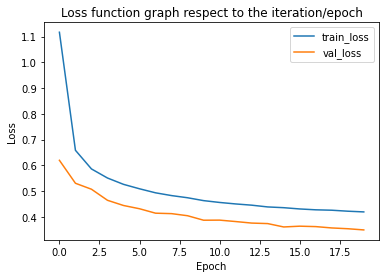

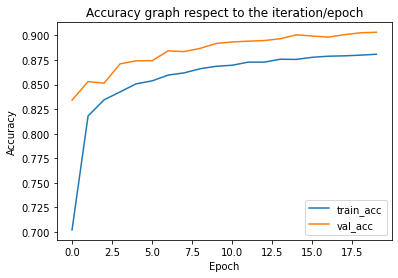

In [49]:
history = best_cnn_model.fit(ds_train_images, ds_train_labels, batch_size=128,
                             epochs=20,
                             validation_data=(new_val_ds, new_val_labels))


# plot the loss and accuracy graphs
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss function graph respect to the iteration/epoch')
plt.show()

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy graph respect to the iteration/epoch')
plt.show()

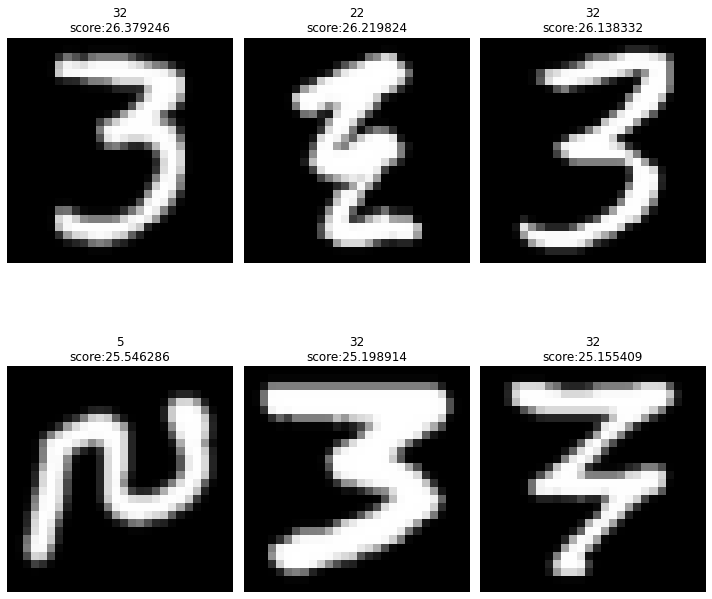

In [51]:
cnn_result = best_cnn_model.predict(ds_test_images)

cnn_result_val = [max(row) for row in result]
cnn_result_val = np.array(cnn_result_val)

# Getting indices of N = 6 maximum values
six_best = np.argsort(cnn_result_val)[::-1][:6]

# Getting N maximum values
# resultValue[six_best]

# Plot the images
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
axes = axes.flatten()
for img, label, value, ax in zip(ds_test_images[six_best], ds_test_labels[six_best], cnn_result_val[six_best], axes):
    ax.imshow(img, cmap='gray')
    ax.set_title(str(label) + "\nscore:" + str(value))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [52]:
# get the predicted labels
y_pred_labels = np.argmax(cnn_result, axis=1)

# calculate the confusion matrix
conf_mat = confusion_matrix(ds_test_labels, y_pred_labels)

# calculate the precision, recall, and F1 score
precision = precision_score(ds_test_labels, y_pred_labels, average='weighted')
recall = recall_score(ds_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(ds_test_labels, y_pred_labels, average='weighted')

# print the confusion matrix and the metrics
print(f"Confusion matrix:\n{conf_mat}\n")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Confusion matrix:
[[195   0   0 ...   0   0   0]
 [  0 290   1 ...   0   0   0]
 [  0   0 354 ...   0   0   0]
 ...
 [  0   1   0 ... 232   0   0]
 [  0   0   0 ...   0 378   3]
 [  0   0   0 ...   0   4 368]]

Precision: 0.880
Recall: 0.878
F1 Score: 0.876
